In [1]:
# imports
import astropy
import numpy as np
from astropy.io import fits
from astropy.io import votable
from astropy.table import Table
from scipy.spatial import KDTree
import matplotlib.pyplot as plt
import kdtree
from glob import glob
from statistics import median, mean
from scipy.stats.mstats import theilslopes

In [2]:
# read in file as table
t = Table.read('zone029_anyqual.txt', format = 'ascii', delimiter = '|')
#t = Table.read('zone029_simbad')
#vot = votable.parse_single_table('zone029_simbad', pedantic=False)

In [9]:
t

col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13
int64,str26,str3,str29,str16,str6,str6,str6,str6,str6,str11,int64,int64
1,BD-06 294,*,01 34 23.6679 -06 13 07.751,26.260 -9.026,~,11.356,10.370,~,~,~,1,0
2,TYC 4685-1805-1,*,01 36 11.8085 -02 35 22.264,25.662 -6.680,~,12.30,11.31,~,~,~,0,0
3,2MASS J01355756-0716131,*,01 35 57.56 -07 16 13.1,26.8 -36.7,~,~,12.68,~,~,~,0,0
4,UCAC2 29946467,*,01 53 35.025 -05 03 35.93,9.0 -5.4,~,13.01,12.16,12.04,11.26,~,0,0
5,BD-03 214,*,01 32 05.1668 -02 58 56.707,-27.60 -31.60,~,10.53,9.92,~,~,G3,0,0
6,GJ 3119,Fl*,01 51 04.05 -06 07 04.8,547 -263,~,16.290,14.49,13.00,11.16,M4.5Ve,27,0
7,2MASS J01353838-0631000,*,01 35 38.38 -06 31 00.0,43.8 1.0,~,13.3,12.8,~,~,~,0,0
8,TYC 4685-2501-1,*,01 43 58.6711 -03 31 48.647,1.393 -13.027,~,12.52,11.66,~,~,~,0,0
9,HD 11339,PM*,01 51 28.93032 -04 13 12.4041,152.82 -64.98,~,7.50,7.19,~,~,A9V,8,0


In [10]:
# rename columns from default to actual
t.rename_column('col1', '#')
t.rename_column('col2', 'identifier')
t.rename_column('col3', 'typ')
t.rename_column('col4', 'coord1 (ICRS,J2000/2000)')
t.rename_column('col5', 'pm')
t.rename_column('col6', 'Mag U')
t.rename_column('col7', 'Mag B')
t.rename_column('col8', 'Mag V')
t.rename_column('col9', 'Mag R')
t.rename_column('col10', 'Mag I')
t.rename_column('col11', 'spec. type')
t.rename_column('col12', '#bib')
t.rename_column('col13', '#not')

In [11]:
#check names
t

#,identifier,typ,"coord1 (ICRS,J2000/2000)",pm,Mag U,Mag B,Mag V,Mag R,Mag I,spec. type,#bib,#not
int64,str26,str3,str29,str16,str6,str6,str6,str6,str6,str11,int64,int64
1,BD-06 294,*,01 34 23.6679 -06 13 07.751,26.260 -9.026,~,11.356,10.370,~,~,~,1,0
2,TYC 4685-1805-1,*,01 36 11.8085 -02 35 22.264,25.662 -6.680,~,12.30,11.31,~,~,~,0,0
3,2MASS J01355756-0716131,*,01 35 57.56 -07 16 13.1,26.8 -36.7,~,~,12.68,~,~,~,0,0
4,UCAC2 29946467,*,01 53 35.025 -05 03 35.93,9.0 -5.4,~,13.01,12.16,12.04,11.26,~,0,0
5,BD-03 214,*,01 32 05.1668 -02 58 56.707,-27.60 -31.60,~,10.53,9.92,~,~,G3,0,0
6,GJ 3119,Fl*,01 51 04.05 -06 07 04.8,547 -263,~,16.290,14.49,13.00,11.16,M4.5Ve,27,0
7,2MASS J01353838-0631000,*,01 35 38.38 -06 31 00.0,43.8 1.0,~,13.3,12.8,~,~,~,0,0
8,TYC 4685-2501-1,*,01 43 58.6711 -03 31 48.647,1.393 -13.027,~,12.52,11.66,~,~,~,0,0
9,HD 11339,PM*,01 51 28.93032 -04 13 12.4041,152.82 -64.98,~,7.50,7.19,~,~,A9V,8,0


In [12]:
# This class emulates a tuple, but contains a useful payload
class Node(object):
    def __init__(self, ra, dec, data, idx = 0):
        self.coords = (ra, dec)
        self.data = data
        self.idx = idx

    def __len__(self):
        return len(self.coords)

    def __getitem__(self, i):
        return self.coords[i]
    
    def getdata(self):
        return self.data
    
    def get_index(self):
        return self.idx

    def __repr__(self):
        return 'Node({}, {}, {})'.format(self.coords[0], self.coords[1], self.data)

## RA, DEC and KD Tree

In [13]:
def calcRaDec(table):
    """ Calculates the decimal RA and Dec values from SIMBAD data. Also produces the KDTree. """
    coords = table['coord1 (ICRS,J2000/2000)']
    ra_vals = []
    dec_vals = []
    nodes = []
    for i in range(len(table)):
        arr = coords[i].split()
        ra_deg = (int(arr[0])*15) + (int(arr[1])/4) + (float(arr[2])/240)
        ra_vals.append(ra_deg)
        dec_deg = int(arr[3]) - (int(arr[4])/60) - (float(arr[5])/3600)
        dec_vals.append(dec_deg)
        curr = Node(ra_deg, dec_deg, table['identifier'][i], table['#'][i])
        nodes.append(curr)
    table['ra'] = ra_vals
    table['dec'] = dec_vals
    tree2 = kdtree.create(nodes)
    return tree2

In [14]:
# KDTree for zone029
tree2 = calcRaDec(t)

In [15]:
#check
t[1103]

#,identifier,typ,"coord1 (ICRS,J2000/2000)",pm,Mag U,Mag B,Mag V,Mag R,Mag I,spec. type,#bib,#not,ra,dec
int64,str26,str3,str29,str16,str6,str6,str6,str6,str6,str11,int64,int64,float64,float64
1104,[OHD2001] WD J0135-039,WD*,01 35 33.669 -03 57 18.06,454 -186,~,19.6,19.64,19.9,~,DA,6,0,23.8902875,-3.95501666667


# File import prepare

In [16]:
tiles = []
matches = []
def processTile(filename, tree):
    t = Table.read(filename)
    #print('Original:', len(t))
    #idx = np.where(t['CHI_NULL'] > 10)[0]
    #temp = t[np.where(t['N'] > 8)]
    t_s = t[np.where(t['SPREAD_MODEL'] < 0.01)]
    #print('N filt:', len(temp))
    #t_s = temp2[np.where(temp2['CHI_NULL'] > 30)]
    #t_s = t[idx]
    #print('Chi_null filt:', len(t_s))
    tiles.append(t_s)
    # add columns
    col = Table.Column(data=[''*len(t_s)], name = 'SIMBAD_MATCH', dtype='U50')
    t_s['SIMBAD_MATCH'] = col
    col3 = Table.Column(data=[0]*len(t_s), name = 'SIMBAD_#', dtype='i4')
    t_s['SIMBAD_#'] = col3
    col5 = Table.Column(data=[0]*len(t_s), name = 'MATCH_DIST', dtype='f8')
    t_s['MATCH_DIST'] = col5
    print('Tile number:', len(tiles))
    m1 = getMatches(t_s, tree)
    matches.append(m1)

## Func to find Simbad Matches

In [17]:
sim_num = []
def getMatches(tile, tree):
    count = 0
    match = []
    for i in range(len(tile)):
        tgt = Node(tile[i]['RA'], tile[i]['DEC'], '', 0)
        tup = tree.search_nn(tgt)
        # 25 arcseconds - 0.00005
        # 10 arcseconds - 0.000008
        if tup[1] < 0.000008:
            #print(tile['RA', 'DEC'][i])
            count +=1
            match.append(i)
            tile[i]['SIMBAD_MATCH'] = tup[0].data.getdata()
            tile[i]['MATCH_DIST'] = tup[1]
            tile[i]['SIMBAD_#'] = tup[0].data.get_index()
            sim_num.append(tup[0].data.get_index())
    print('Matches:', count)
    return match

## READ IN TABLES

In [12]:
# Read in tiles - all from zone029
path = '/Users/Suyog/Documents/GitHub/DES-Proper-Motion/'
filenames = glob(path+'*proper.fits')
for name in filenames:
    processTile(name, tree2)

Tile number: 1
Matches: 1
Tile number: 2
Matches: 1
Tile number: 3
Matches: 1
Tile number: 4
Matches: 3
Tile number: 5
Matches: 0
Tile number: 6
Matches: 3
Tile number: 7
Matches: 5
Tile number: 8
Matches: 2
Tile number: 9
Matches: 0
Tile number: 10
Matches: 1
Tile number: 11
Matches: 0
Tile number: 12
Matches: 1
Tile number: 13
Matches: 1
Tile number: 14
Matches: 1
Tile number: 15
Matches: 0
Tile number: 16
Matches: 1
Tile number: 17
Matches: 0
Tile number: 18
Matches: 0
Tile number: 19
Matches: 2
Tile number: 20
Matches: 0
Tile number: 21
Matches: 0
Tile number: 22
Matches: 0
Tile number: 23
Matches: 3
Tile number: 24
Matches: 1
Tile number: 25
Matches: 0
Tile number: 26
Matches: 0
Tile number: 27
Matches: 0
Tile number: 28
Matches: 4
Tile number: 29
Matches: 0
Tile number: 30
Matches: 20
Tile number: 31
Matches: 0
Tile number: 32
Matches: 2
Tile number: 33
Matches: 0
Tile number: 34
Matches: 1
Tile number: 35
Matches: 12
Tile number: 36
Matches: 2
Tile number: 37
Matches: 0
Tile num

In [13]:
tiles[33][matches[33]]

MATCH_ID,COADD_ID,SPREAD_MODEL,SPREADERR_MODEL,CHI2_RED,RA_0,RA_ERR,DEC_0,DEC_ERR,MU_RA,MU_RA_ERR,MU_DEC,MU_DEC_ERR,COV_MU_RA_MU_DEC,COV_RA_MU_RA,COV_RA_DEC,COV_RA_MU_DEC,COV_DEC_MU_RA,COV_DEC_MU_DEC,RA,DEC,N,CHI_NULL,VEL,SIGMA_VEL,SIMBAD_MATCH,SIMBAD_#,MATCH_DIST
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str50,int32,float64
1021.0,233004495.0,0.00492281327024,0.000178967762622,1.19084588522,23.8909943784,0.000270921240908,-3.9552800437,0.000246566427014,0.465738180219,1.91875070887e-06,-0.185338769113,1.74739020029e-06,1.96525863649e-07,-2.26909179961e-05,2.31531014693e-05,-2.12037406806e-06,-2.12783677889e-06,-2.06612148197e-05,23.892351,-3.955793,27.0,144490.457489,0.500230136448,0.00132663601792,[OHD2001] WD J0135-039,1104,4.86072569444e-06


## Match Finder

In [20]:
#for i in range(len(tiles)):
#    print(tiles[i][matches[i]]['SIMBAD_MATCH', 'RA', 'DEC', 'MATCH_DIST', 'CHI_NULL', 'N'])

In [21]:
t[sim_num]
# brightest Mag V matched is 10.45

#,identifier,typ,"coord1 (ICRS,J2000/2000)",pm,Mag U,Mag B,Mag V,Mag R,Mag I,spec. type,#bib,#not,ra,dec
int64,str26,str3,str29,str16,str6,str6,str6,str6,str6,str11,int64,int64,float64,float64
1021,2MASS J01364239-0727445,*,01 36 42.39 -07 27 44.6,-16.4 -1.8,~,13.7,13.2,13.300,~,~,0,0,24.176625,-7.46238888889
144,2MASS J01403123-0716198,*,01 40 31.23 -07 16 19.8,1.4 -10.0,~,13.4,12.8,~,~,~,0,0,25.130125,-7.27216666667
570,TYC 4686-1590-1,*,01 49 30.5523 -02 43 44.857,-20.754 -23.110,~,11.86,11.28,~,~,~,0,0,27.37730125,-2.72912694444
1128,TYC 4687-123-1,*,01 36 00.9333 -07 17 54.807,-14.063 -9.195,~,12.19,12.31,~,~,~,0,0,24.00388875,-7.2985575
1086,TYC 4687-1511-1,*,01 44 24.591 -05 17 10.73,6.1 -16.4,~,12.59,12.36,~,~,~,0,0,26.1024625,-5.28631388889
468,BD-04 284,*,01 51 24.8188 -03 22 42.082,19.419 -2.315,~,11.843,11.247,10.92,~,~,5,0,27.8534116667,-3.37835611111
755,TYC 4687-1044-1,*,01 35 08.109 -05 11 24.35,-8.7 -9.6,~,11.979,11.384,~,~,~,1,0,23.7837875,-5.19009722222
1028,TYC 4688-1450-1,*,01 52 42.5966 -05 25 59.406,1.050 -4.148,~,12.93,12.40,~,~,~,0,0,28.1774858333,-5.43316833333
1028,TYC 4688-1450-1,*,01 52 42.5966 -05 25 59.406,1.050 -4.148,~,12.93,12.40,~,~,~,0,0,28.1774858333,-5.43316833333


In [216]:
max(tiles[33]['RA'])

24.181082

In [217]:
min(tiles[33]['RA'])

23.444203999999999

In [24]:
from mpl_toolkits.mplot3d import Axes3D

### 3D Visualization

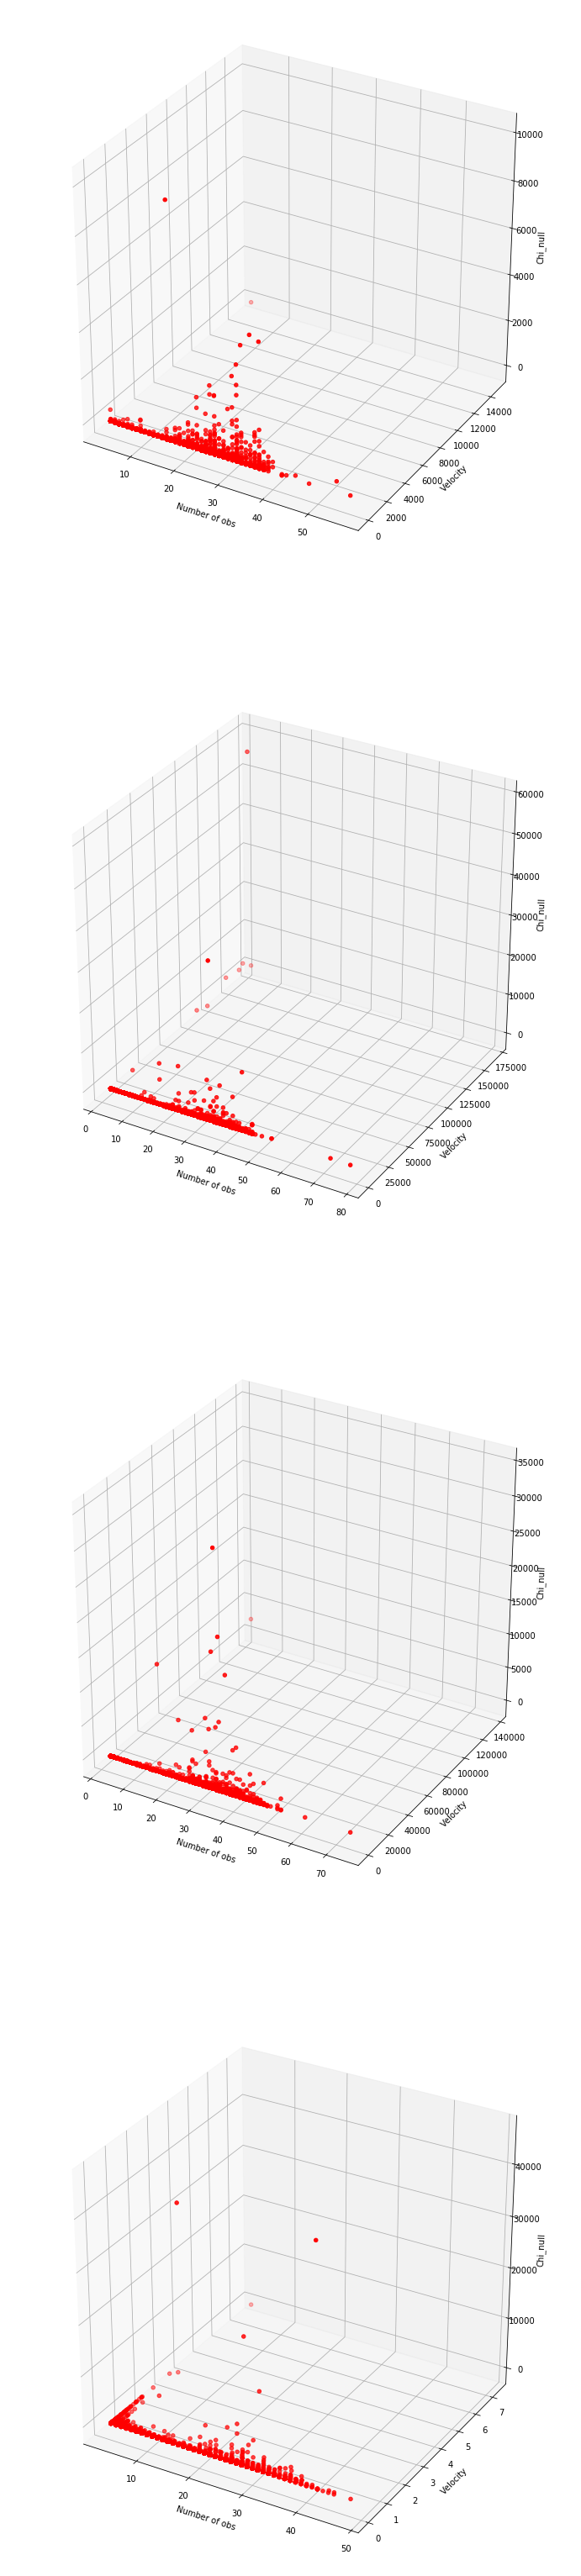

In [25]:
fig = plt.figure(figsize = (12, 56))
ax = fig.add_subplot(411, projection='3d')
ax.scatter(tiles[0]['N'], tiles[0]['VEL'], tiles[0]['CHI_NULL'], c='r', marker='o')
ax.set_xlabel('Number of obs')
ax.set_ylabel('Velocity')
ax.set_zlabel('Chi_null')

ax2 = fig.add_subplot(412, projection='3d')
ax2.scatter(tiles[1]['N'], tiles[1]['VEL'], tiles[1]['CHI_NULL'], c='r', marker='o')
ax2.set_xlabel('Number of obs')
ax2.set_ylabel('Velocity')
ax2.set_zlabel('Chi_null')

ax3 = fig.add_subplot(413, projection='3d')
ax3.scatter(tiles[2]['N'], tiles[2]['VEL'], tiles[2]['CHI_NULL'], c='r', marker='o')
ax3.set_xlabel('Number of obs')
ax3.set_ylabel('Velocity')
ax3.set_zlabel('Chi_null')

ax4 = fig.add_subplot(414, projection='3d')
ax4.scatter(tiles[3]['N'], tiles[3]['VEL'], tiles[3]['CHI_NULL'], c='r', marker='o')
ax4.set_xlabel('Number of obs')
ax4.set_ylabel('Velocity')
ax4.set_zlabel('Chi_null')

plt.show()

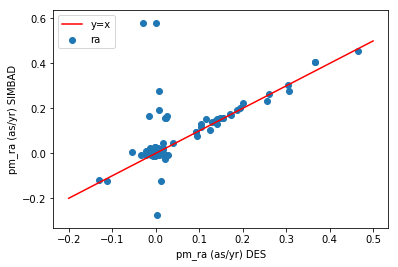

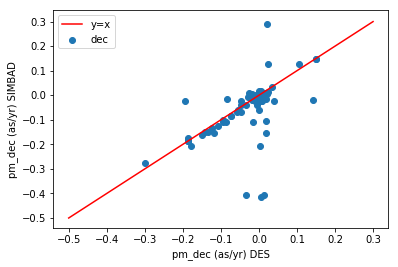

In [14]:
ra_des = []
dec_des = []
ra_sim = []
dec_sim = []
for i in range(len(tiles)):
    t_s = tiles[i]
    m1 = matches[i]
    # compare mu_ra and mu_dec and pmra and pmdec for matched objects
    for iden in t_s[m1]['SIMBAD_#']:
        arr = t[iden - 1]['pm'].split()
        ra_sim.append(float(arr[0])/1000)
        dec_sim.append(float(arr[1])/1000)
    for iden in t_s[m1]:
        ra_des.append(iden['MU_RA'])
        dec_des.append(iden['MU_DEC'])
        
plt.scatter(ra_des, ra_sim, label = 'ra')
plt.plot([-0.2, 0.5], [-0.2, 0.5], color = 'r', label = 'y=x')
plt.xlabel('pm_ra (as/yr) DES')
plt.ylabel('pm_ra (as/yr) SIMBAD')
plt.legend()
plt.show()
plt.scatter(dec_des, dec_sim, label = 'dec')
plt.plot([-0.5, 0.3], [-0.5, 0.3], color = 'r', label = 'y=x')
plt.xlabel('pm_dec (as/yr) DES')
plt.ylabel('pm_dec (as/yr) SIMBAD')
plt.legend()
plt.show()

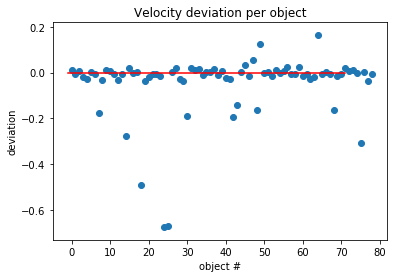

In [15]:
var = []
vels = []
pms = []
for i in range(len(tiles)):
    t_s = tiles[i]
    m1 = matches[i]
    # variation in velocities of objects and their matches
    for iden in t_s[m1]:
        num = iden['SIMBAD_#']
        arr = t[num - 1]['pm'].split()
        pmra = float(arr[0])/1000
        pmdec = float(arr[1])/1000
        pm2 = (pmra * np.cos(t[num - 1]['dec'] *np.pi/180))**2 + pmdec**2
        pm = np.sqrt(pm2)
        pms.append(pm)
        vels.append(iden['VEL'])
        var.append(iden['VEL'] - pm)
plt.title('Velocity deviation per object')
plt.scatter(range(len(var)), var)
plt.plot([-1, 71], [0, 0], color = 'r', label = '0 deviation')
plt.ylabel('deviation')
plt.xlabel('object #')
plt.show()

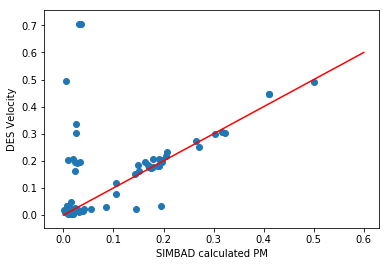

In [16]:
plt.scatter(vels, pms)
plt.plot([0, 0.6], [0, 0.6], color = 'r', label = '0 deviation')
plt.ylabel('DES Velocity')
plt.xlabel('SIMBAD calculated PM')
plt.show()

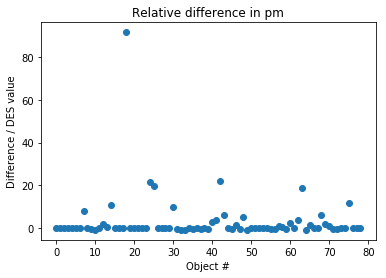

In [17]:
plt.title('Relative difference in pm')
plt.scatter(range(len(vels)), (np.array(pms) - np.array(vels))/np.array(vels))
plt.xlabel('Object #')
plt.ylabel('Difference / DES value')
#plt.ylim(-1, 1)
plt.show()

In [18]:
# group
t_match = tiles[0][matches[0]].group_by('SIMBAD_#')

In [19]:
t_match['SIMBAD_MATCH', 'RA', 'DEC', 'MATCH_DIST', 'CHI_NULL', 'N']

SIMBAD_MATCH,RA,DEC,MATCH_DIST,CHI_NULL,N
str50,float64,float64,float64,float64,float64
LP 648-64,27.115445,-3.954552,6.55431160493e-07,10063.2305873,17.0


In [20]:
# highest velocity t1
tiles[1][np.where(tiles[1]['VEL'] > 0.5)]

MATCH_ID,COADD_ID,SPREAD_MODEL,SPREADERR_MODEL,CHI2_RED,RA_0,RA_ERR,DEC_0,DEC_ERR,MU_RA,MU_RA_ERR,MU_DEC,MU_DEC_ERR,COV_MU_RA_MU_DEC,COV_RA_MU_RA,COV_RA_DEC,COV_RA_MU_DEC,COV_DEC_MU_RA,COV_DEC_MU_DEC,RA,DEC,N,CHI_NULL,VEL,SIGMA_VEL,SIMBAD_MATCH,SIMBAD_#,MATCH_DIST
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str50,int32,float64
5026.0,268793147.0,0.00939676165581,0.00410031015053,1.0888146993,26.1523885589,11.6767360277,-2.95285342445,11.6084100952,-0.657644131068,0.120609399762,-1.36776783464,0.119886166158,-0.000162447636807,-1.18663365507,-0.0155717175208,0.00159037837908,0.00159039145084,-1.17960395908,26.150494,-2.956588,3.0,19.210877609,1.51727849469,0.346258430193,,0,0.0
5165.0,266085206.0,-0.00896319653839,0.00531438877806,1.03509283693,25.4425987938,5.82767950699,-3.03915618229,5.77611231838,0.749007189963,0.0600667947998,0.110595992388,0.0595203515716,0.000258744022068,-0.591602466025,0.0244855452601,-0.00251707625784,-0.00251715023578,-0.586293959592,25.44465,-3.03885,4.0,9.53348771183,0.756086360435,0.245214159525,,0,0.0
5463.0,266089439.0,-0.00305959093384,0.00575280468911,0.0650186619866,25.8504561736,9.9073379993,-3.11830338621,9.89120535336,-0.230221923233,0.101592479322,-0.822155893683,0.101402734613,0.000274397050316,-1.00317551519,0.0263058673852,-0.0026865577759,-0.00268630813859,-1.00142188561,25.849804,-3.120516,3.0,7.17758068187,0.853689279147,0.318682935389,,0,0.0
8396.0,266074269.0,0.000544698850717,0.00519028771669,0.359105415791,25.6822131609,12.7517417857,-2.80887824453,12.6531145849,0.353371733192,0.130758480018,0.647177645761,0.129735430838,0.000287297226231,-1.2911888781,0.0271426503514,-0.00279270202445,-0.00279270372021,-1.28114441549,25.683157,-2.807069,3.0,4.17566098479,0.737164161263,0.360848283014,,0,0.0
9536.0,268805553.0,0.00244610826485,0.00382522190921,1.14427970724,26.154726243,4.79825303169,-3.19299059723,4.72104199565,-0.395884913737,0.0491396475412,-0.639417865366,0.0483451472108,1.67458796112e-05,-0.485545693412,0.00147928547175,-0.000157578782719,-0.00015755460761,-0.477713848712,26.153619,-3.194714,5.0,11.6428159026,0.751726892481,0.220408238692,,0,0.0
9711.0,266087834.0,-0.00262170052156,0.00429805973545,0.149834288349,25.5177605284,7.89364227059,-3.08871315283,7.79131899184,-0.535850406905,0.0803965540161,-0.148372384641,0.0793365820294,0.000312915494442,-0.79657775575,0.0297089463345,-0.00304910877822,-0.0030491090383,-0.78616387532,25.516276,-3.089101,3.0,3.84123084218,0.555262260816,0.283693528909,,0,0.0
10475.0,266088443.0,0.00974984653294,0.00438829837367,4.06942089885,25.4746313051,16.2825572013,-3.10274238144,16.1554640486,-0.985412073517,0.167387247298,0.0529290703362,0.16607677158,0.000337400554791,-1.65081675873,0.0322309037995,-0.0032976994021,-0.0032976296759,-1.63791170093,25.471849,-3.102559,3.0,5.81929911106,0.985390247699,0.409081009742,,0,0.0
10535.0,266087407.0,0.00681097153574,0.00493579171598,0.287776148595,25.5521022319,1.10564769099,-3.08184586993,1.10172987986,-0.190359610088,0.0107033061996,0.492618561511,0.0106676804814,7.26410804112e-06,-0.108708052341,0.000704382664606,-7.14700955184e-05,-7.14797537922e-05,-0.10833464489,25.551509,-3.080447,3.0,26.1459489855,0.528020060734,0.103283193286,,0,0.0
11476.0,266061205.0,0.00996143836528,0.00367670552805,1.43956290014,26.1242152809,11.0344306169,-2.53942402725,11.0228500212,0.614840638647,0.0672562159123,-0.299171648144,0.0671849882786,0.000124376734115,-0.861432348733,0.0204592864111,-0.00159512977151,-0.00159512979175,-0.860524170163,26.126386,-2.540459,4.0,6.96307729472,0.683220297844,0.25912281116,,0,0.0


In [21]:
# highest matched velocity t1
max(tiles[1]['VEL'][matches[1]])

0.19497671092109806

In [22]:
fin = Table.read('DES0135-0416_final.fits')
fin[np.where(fin['VERSION'] == 'COADD')]

RA,DEC,ERRAWIN_WORLD,XWIN_IMAGE,YWIN_IMAGE,SPREAD_MODEL,SPREADERR_MODEL,FLUX_AUTO,FLUXERR_AUTO,EXPNUM,IMAFLAGS_ISO,ERRBWIN_WORLD,A_IMAGE,ERRA_IMAGE,B_IMAGE,ERRB_IMAGE,THETA_IMAGE,ERRTHETAWIN_J2000,CHI2_MODEL,CHI2_PSF,CCDNUM,BAND,MJD_OBS,EXPTIME,MAG_ZERO,VERSION,X_GNOM,Y_GNOM,MAG_AUTO_G,MAG_AUTO_R,MAG_AUTO_I,MAG_AUTO_Z,MAG_AUTO_Y,COADD_OBJECT_ID,ALPHAWIN_J2000,DELTAWIN_J2000,FLUX_AUTO_G,FLUX_AUTO_R,FLUX_AUTO_I,FLUX_AUTO_Z,FLUX_AUTO_Y,MAGERR_AUTO_G,MAGERR_AUTO_R,MAGERR_AUTO_I,MAGERR_AUTO_Z,MAGERR_AUTO_Y,FLUXERR_AUTO_G,FLUXERR_AUTO_R,FLUXERR_AUTO_I,FLUXERR_AUTO_Y,SPREAD_MODEL_I,SPREADERR_MODEL_I,MATCH_ID,COLOR,NEW_RA,NEW_DEC
float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,int16,str5,float64,float64,float64,str30,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
23.478411,-3.915749,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,999999,999999,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,16959,N/A,1e+20,1e+20,1e+20,COADD,-2.76081693177,1.06027700015,23.3447284698,22.5147724152,22.0132274628,21.9903831482,22.0709075928,233002738,23.4784108165,-3.91574925081,459.313171387,986.486206055,1565.70300293,1598.9934082,1484.69348145,0.125666484237,0.089109711349,0.100008971989,0.124492883682,0.436510413885,53.1494216919,80.9442901611,144.18447876,596.762573242,0.00665117893368,0.0022047040984,0.0,1.33150100708,23.4784108165,-3.91574925081
23.476918,-3.922236,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,999999,999999,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,16959,N/A,1e+20,1e+20,1e+20,COADD,-2.76228290133,1.05377597333,21.8050785065,20.2067489624,18.8788890839,18.362947464,18.2619285583,233002478,23.4769178152,-3.92223565087,1896.56713867,8266.10058594,28083.0644531,45166.953125,49571.1210938,0.0274751670659,0.0120082842186,0.00693508423865,0.00428375974298,0.0123578952625,47.98204422,91.401184082,179.33555603,564.083557129,-0.0042734220624,0.000131767446874,1.0,0.61,23.4769178152,-3.92223565087
23.47002,-3.918203,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,999999,999999,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,16959,N/A,1e+20,1e+20,1e+20,COADD,-2.76919834328,1.05779224786,22.5204486847,21.3090381622,20.8085403442,20.4838180542,20.4631500244,233002553,23.4700203399,-3.91820262638,981.34161377,2994.91503906,4748.796875,6404.31787109,6527.3984375,0.047188591212,0.0253237225115,0.0277617312968,0.0316914319992,0.0971864983439,42.641002655,69.8364639282,121.394866943,584.139038086,0.0106297908351,0.000657015480101,2.0,1.71190834045,23.4700203399,-3.91820262638
23.483012,-3.916844,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,999999,999999,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,16959,N/A,1e+20,1e+20,1e+20,COADD,-2.75621028839,1.05919623614,23.2854347229,22.6950111389,22.2913284302,22.1755332947,21.7814445496,233002634,23.4830122283,-3.9168435297,485.094055176,835.593933105,1211.90515137,1348.30114746,1938.30688477,0.0850473195314,0.0772641003132,0.0943096727133,0.10841255635,0.283729910851,37.9889030457,59.4488182068,105.243438721,506.404815674,0.00328959245235,0.00215340894647,3.0,0.994106292725,23.4830122283,-3.9168435297
23.4453,-3.910053,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,999999,999999,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,16959,N/A,1e+20,1e+20,1e+20,COADD,-2.79395795271,1.06587261153,22.3699493408,22.0977363586,22.1503791809,22.1103286743,21.8544616699,227624387,23.4452996887,-3.91005258273,1127.25036621,1448.45751953,1379.90124512,1431.75561523,1812.23852539,0.0302624013275,0.034235753119,0.0678136497736,0.104264013469,0.244845211506,31.4118804932,45.6620941162,86.1658782959,408.580047607,-0.00321618909948,0.0014554518275,4.0,0.219570159912,23.4452996887,-3.91005258273
23.479058,-3.918865,1e+20

In [23]:
fin[np.where((fin['MATCH_ID'] == 1021))][22]

RA,DEC,ERRAWIN_WORLD,XWIN_IMAGE,YWIN_IMAGE,SPREAD_MODEL,SPREADERR_MODEL,FLUX_AUTO,FLUXERR_AUTO,EXPNUM,IMAFLAGS_ISO,ERRBWIN_WORLD,A_IMAGE,ERRA_IMAGE,B_IMAGE,ERRB_IMAGE,THETA_IMAGE,ERRTHETAWIN_J2000,CHI2_MODEL,CHI2_PSF,CCDNUM,BAND,MJD_OBS,EXPTIME,MAG_ZERO,VERSION,X_GNOM,Y_GNOM,MAG_AUTO_G,MAG_AUTO_R,MAG_AUTO_I,MAG_AUTO_Z,MAG_AUTO_Y,COADD_OBJECT_ID,ALPHAWIN_J2000,DELTAWIN_J2000,FLUX_AUTO_G,FLUX_AUTO_R,FLUX_AUTO_I,FLUX_AUTO_Z,FLUX_AUTO_Y,MAGERR_AUTO_G,MAGERR_AUTO_R,MAGERR_AUTO_I,MAGERR_AUTO_Z,MAGERR_AUTO_Y,FLUXERR_AUTO_G,FLUXERR_AUTO_R,FLUXERR_AUTO_I,FLUXERR_AUTO_Y,SPREAD_MODEL_I,SPREADERR_MODEL_I,MATCH_ID,COLOR,NEW_RA,NEW_DEC
float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,int16,str5,float64,float64,float64,str30,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
23.892351,-3.955793,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,999999,999999,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,16959,N/A,1e+20,1e+20,1e+20,COADD,-2.34681027515,1.02144849091,19.8256206512,19.6049842834,19.5392608643,19.5674915314,19.6212997437,233004495,23.8923509604,-3.95579257198,11742.2666016,14388.1982422,15286.0644531,14893.7148438,14173.6025391,0.00482006324455,0.00625082058832,0.00886201299727,0.0160920564085,0.0475238896906,52.1164512634,82.8158798218,124.737846375,620.243774414,0.00492281327024,0.000178967762622,1021.0,0.286359786987,23.8923509604,-3.95579257198


In [24]:
tiles[33][np.where(tiles[33]['MATCH_ID'] == 1021)]

MATCH_ID,COADD_ID,SPREAD_MODEL,SPREADERR_MODEL,CHI2_RED,RA_0,RA_ERR,DEC_0,DEC_ERR,MU_RA,MU_RA_ERR,MU_DEC,MU_DEC_ERR,COV_MU_RA_MU_DEC,COV_RA_MU_RA,COV_RA_DEC,COV_RA_MU_DEC,COV_DEC_MU_RA,COV_DEC_MU_DEC,RA,DEC,N,CHI_NULL,VEL,SIGMA_VEL,SIMBAD_MATCH,SIMBAD_#,MATCH_DIST
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str50,int32,float64
1021.0,233004495.0,0.00492281327024,0.000178967762622,1.19084588522,23.8909943784,0.000270921240908,-3.9552800437,0.000246566427014,0.465738180219,1.91875070887e-06,-0.185338769113,1.74739020029e-06,1.96525863649e-07,-2.26909179961e-05,2.31531014693e-05,-2.12037406806e-06,-2.12783677889e-06,-2.06612148197e-05,23.892351,-3.955793,27.0,144490.457489,0.500230136448,0.00132663601792,[OHD2001] WD J0135-039,1104,4.86072569444e-06


In [25]:
t[1103]

#,identifier,typ,"coord1 (ICRS,J2000/2000)",pm,Mag U,Mag B,Mag V,Mag R,Mag I,spec. type,#bib,#not,ra,dec
int64,str26,str3,str29,str16,str6,str6,str6,str6,str6,str11,int64,int64,float64,float64
1104,[OHD2001] WD J0135-039,WD*,01 35 33.669 -03 57 18.06,454 -186,~,19.6,19.64,19.9,~,DA,6,0,23.8902875,-3.95501666667


# ALL Match

In [26]:
t_all = Table.read('zone029_all.txt', format = 'ascii', delimiter = '|')

In [27]:
# rename columns from default to actual
t_all.rename_column('col1', '#')
t_all.rename_column('col2', 'identifier')
t_all.rename_column('col3', 'typ')
t_all.rename_column('col4', 'coord1 (ICRS,J2000/2000)')
t_all.rename_column('col5', 'pm')
t_all.rename_column('col6', 'Mag U')
t_all.rename_column('col7', 'Mag B')
t_all.rename_column('col8', 'Mag V')
t_all.rename_column('col9', 'Mag R')
t_all.rename_column('col10', 'Mag I')
t_all.rename_column('col11', 'spec. type')
t_all.rename_column('col12', '#bib')
t_all.rename_column('col13', '#not')

In [28]:
tree_all = calcRaDec(t_all)
mall = getMatches(tiles[29], tree_all)
tiles[29][mall]
#t_all[949]

Matches: 41


MATCH_ID,COADD_ID,SPREAD_MODEL,SPREADERR_MODEL,CHI2_RED,RA_0,RA_ERR,DEC_0,DEC_ERR,MU_RA,MU_RA_ERR,MU_DEC,MU_DEC_ERR,COV_MU_RA_MU_DEC,COV_RA_MU_RA,COV_RA_DEC,COV_RA_MU_DEC,COV_DEC_MU_RA,COV_DEC_MU_DEC,RA,DEC,N,CHI_NULL,VEL,SIGMA_VEL,SIMBAD_MATCH,SIMBAD_#,MATCH_DIST
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str50,int32,float64
51.0,269832086.0,-0.00243711099029,4.90478196298e-05,1.02128634586,24.0253919562,0.000143528956143,-6.81569705106,0.00012939721971,0.00329823706078,1.0368151698e-06,-0.00201985076904,9.63524864568e-07,1.93660974106e-07,-1.21586065243e-05,2.52674595337e-05,-2.20403729464e-06,-2.20502261926e-06,-1.1127717703e-05,24.025381,-6.815668,37.0,17.9844244987,0.00384772079015,0.000918456742676,PHL 7395,1842,1.14249611111e-06
54.0,269831248.0,0.000257954467088,7.05554775777e-05,1.06140138306,24.0071179284,0.0142937338171,-6.80574634994,0.0171491418279,0.0152188191232,0.000119917956041,-0.0291480430523,0.000143092038759,1.29224412642e-05,-0.0013074195156,0.00151210348978,-0.000139223931401,-0.000140444715292,-0.00156520033526,24.007146,-6.8058,7.0,8.62095357912,0.0328324270059,0.0112969993003,2MASS J01360132-0648257,2846,4.50193945678e-06
225.0,269834978.0,-0.0018517842982,0.000110442917503,1.09092835927,24.0852228635,0.000204989430745,-6.86186780402,0.000168293205536,-0.00419980464437,1.48746550973e-06,0.00398476841528,1.25573755896e-06,1.74115920981e-07,-1.74022452935e-05,2.25216922162e-05,-1.97016031875e-06,-1.97338242592e-06,-1.4482969268e-05,24.085187,-6.861816,37.0,28.0783866374,0.00576757858398,0.00109677610994,GALEX 2552276687843755189,496,1.46408179007e-08
987.0,269843304.0,-0.00288692652248,0.000306108064251,1.31751047076,24.5225293019,0.000760504163669,-6.99902502765,0.000519619200572,0.00334164014103,5.6069618473e-06,0.00391223318259,3.87195093075e-06,4.89988541293e-07,-6.49516043532e-05,7.28512542502e-05,-5.95477592332e-06,-5.97482596797e-06,-4.45835369987e-05,24.522506,-6.99897,17.0,5.41423941163,0.0051289695463,0.00225408071777,2MASX J01380553-0700051,1190,6.40510459568e-06
1163.0,269843137.0,0.00319107575342,2.21437148866e-05,0.575979585873,24.605695273,0.000967148100526,-6.99741781146,0.00283368184951,0.00244630381948,7.30726092599e-06,-0.0182220632087,2.07480223148e-05,2.92162217872e-06,-8.33543198086e-05,0.000475030845794,-3.78462289677e-05,-3.67325014129e-05,-0.000241105427705,24.605666,-6.997438,4.0,19.6467559081,0.0183831219743,0.00444392981321,2MASS J01382527-0659433,2628,4.45359290123e-06
1173.0,269842418.0,0.00437682121992,7.2782720963e-05,2.80421705506,24.6053210112,0.000915798751016,-6.99540457718,0.0027795028742,0.0162737359721,6.8410831977e-06,0.0101708380337,2.00947377567e-05,3.27626929424e-06,-7.8587170062e-05,0.000499414199339,-4.10273462044e-05,-3.96272452384e-05,-0.000235452583212,24.605332,-6.995375,5.0,39.0173930118,0.0190880130162,0.00368219337719,2MASS J01382527-0659433,2628,1.81967901244e-09
1449.0,269853290.0,-0.00275263958611,2.53380203503e-05,2.17765328899,24.1003506514,0.000127987895325,-7.19386457103,0.000111161848647,0.148795055503,9.49797370295e-07,-0.0340542928419,8.26528795554e-07,7.05602692139e-08,-1.09818793576e-05,1.1415300545e-05,-8.92691336538e-07,-8.9704658682e-07,-9.54564348934e-06,24.100782,-7.193938,30.0,25787.7213793,0.15150069899,0.000955332308979,LP 648-82,1730,3.84547012344e-07
1916.0,269850346.0,0.00703666824847,2.50092016358e-05,1.89577430545,24.5912490614,0.000263526649179,-7.13954331508,0.000132472537823,-0.00749925784578,1.94674423036e-06,-0.00539329004831,9.41308573988e-07,1.46925791572e-07,-2.25469932464e-05,2.14983969099e-05,-1.77679079212e-06,-1.75530346458e-06,-1.11193733015e-05,24.591198,-7.139527,17.0,53.9395802701,0.00919008830018,0.00131912799371,2MASS J01382186-0708219,133,1.75024444437e-08
1950.0,269846945.0,0.00673297606409,8.54418685776e-05,15.1007542637,24.6126505571,0.00051306765528,-

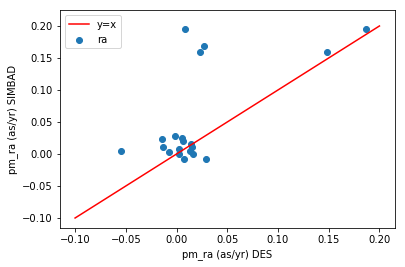

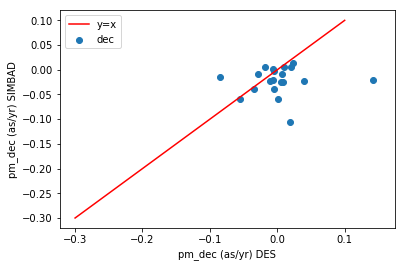

In [29]:
# Matches for ALL sources
ra_des_a = []
dec_des_a = []
ra_sim_a = []
dec_sim_a = []

t_s = tiles[29]
m1 = mall
# compare mu_ra and mu_dec and pmra and pmdec for matched objects
for iden in t_s[m1]:
    ide = iden['SIMBAD_#']
    arr = t_all[ide - 1]['pm'].split()
    if arr[0] != '~' and arr[1] != '~':
        ra_sim_a.append(float(arr[0])/1000)
        dec_sim_a.append(float(arr[1])/1000)
        ra_des_a.append(iden['MU_RA'])
        dec_des_a.append(iden['MU_DEC'])   
plt.scatter(ra_des_a, ra_sim_a, label = 'ra')
plt.plot([-0.1, 0.2], [-0.1, 0.2], color = 'r', label = 'y=x')
plt.xlabel('pm_ra (as/yr) DES')
plt.ylabel('pm_ra (as/yr) SIMBAD')
plt.legend()
plt.show()
plt.scatter(dec_des_a, dec_sim_a, label = 'dec')
plt.plot([-0.3, 0.1], [-0.3, 0.1], color = 'r', label = 'y=x')
plt.xlabel('pm_dec (as/yr) DES')
plt.ylabel('pm_dec (as/yr) SIMBAD')
plt.legend()
plt.show()

In [18]:
# g for gaia - gaia table
g = Table.read('Gaia-DR2-short.csv')#Table.read('Gaia-DR2-0135-0416-PM.csv')

In [19]:
g

designation,source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,phot_g_mean_mag,bp_rp,radial_velocity,radial_velocity_error,phot_variable_flag,teff_val,a_g_val
str28,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str13,float64,float64
Gaia DR2 2480805614485369856,2480805614485369856,23.7193128264,6.06592800877,-4.38497820752,3.69083905699,--,--,--,--,--,--,21.02541,--,--,--,NOT_AVAILABLE,--,--
Gaia DR2 2480800323082531712,2480800323082531712,23.835255954,0.351421115677,-4.48635761064,0.258317160211,5.1937178689,0.429202640412,-0.882672650352,0.847042529423,-22.6152619655,0.445897850361,16.81308,2.2442532,--,--,NOT_AVAILABLE,3828.0,0.1173
Gaia DR2 2480799361009851904,2480799361009851904,23.7357427338,5.63188045317,-4.5077850147,9.55284343762,--,--,--,--,--,--,21.04972,--,--,--,NOT_AVAILABLE,--,--
Gaia DR2 2480866469874274944,2480866469874274944,23.7793794132,0.151297356702,-4.09145292255,0.0820439638115,1.55214798509,0.16586813272,18.1571604306,0.282792476169,7.48433798508,0.139061608553,17.372198,2.0244884,--,--,NOT_AVAILABLE,--,--
Gaia DR2 2480802419026572288,2480802419026572288,23.7195264463,0.395369487139,-4.48478070059,0.305440787559,1.50041424277,0.477664697248,-7.66004863546,1.01572446507,-6.56433786552,0.599250392584,19.524183,2.182541,--,--,NOT_AVAILABLE,--,--
Gaia DR2 2480867255856044544,2480867255856044544,23.7530058878,1.69131689323,-4.0770972268,0.91724447153,-0.217786892902,1.60102149143,-1.13867636379,2.81475864676,-4.06298391624,1.97424004766,20.66389,0.6299896,--,--,NOT_AVAILABLE,--,--
Gaia DR2 2480857398903348480,2480857398903348480,23.6302381753,0.060060250475,-4.25556911347,0.0391857410681,1.0528091935,0.0685623421885,12.6475738859,0.12834908444,-11.7157667929,0.0773427489097,15.795444,1.044199,--,--,NOT_AVAILABLE,5091.5,0.0683
Gaia DR2 2480810802805864704,2480810802805864704,23.8117733993,1.02517051392,-4.3706883223,1.13440886657,1.8551119674,1.06723722027,90.0786243355,2.84758032639,-77.8094731516,2.66497199536,20.559452,--,--,--,NOT_AVAILABLE,--,--
Gaia DR2 2480864992405526144,2480864992405526144,23.6390325858,0.809171628766,-4.16014136788,0.539728977622,0.159490161542,1.13697466696,-0.912049728035,1.43191832316,-27.1378023634,0.816462983085,20.096645,1.8752022,--,--,NOT_AVAILABLE,--,--


In [20]:
def kdTreeGaia(table):
    """ Calculates the KDTree from Gaia data. """
    nodes = []
    for i in range(len(table)):
        ra_deg = table['ra'][i]
        dec_deg = table['dec'][i]
        curr = Node(ra_deg, dec_deg, table['designation'][i])
        nodes.append(curr)
    tree = kdtree.create(nodes)
    return tree

In [21]:
# test
g['ra'][5]
g['dec'][115]

-4.1699744111592851

In [22]:
tree = kdTreeGaia(g)

In [23]:
def getGaiaMatches(tile, tree):
    """ Matches the tile data to Gaia data using the Gaia KDTree provided """
    count = 0
    match = []
    col = Table.Column(data=[''*len(tile)], name = 'GAIA_MATCH', dtype='U50')
    tile['GAIA_MATCH'] = col
    col3 = Table.Column(data=[0]*len(tile), name = 'GAIA_MATCH_DIST', dtype='f8')
    tile['GAIA_MATCH_DIST'] = col3
    for i in range(len(tile)):
        tgt = Node(tile[i]['RA'], tile[i]['DEC'], '')
        tup = tree.search_nn(tgt)
        # 25 arcseconds - 0.00005
        # 10 arcseconds - 0.000008
        # 5 arcseconds - 0.0000019
        # 1 arcsecond - 7.7 x 10^-8
        #print(tup)
        if tup[1] < (7.7*10**-8):
            #print(tile['RA', 'DEC'][i])
            #print(tup)
            count +=1
            match.append(i)
            tile[i]['GAIA_MATCH'] = tup[0].data.getdata()
            tile[i]['GAIA_MATCH_DIST'] = tup[1]
            sim_num.append(tup[0].data.get_index())
    print('Matches:', count)
    return match

In [62]:
# running out of index names, so we will use 'cool' as the index for gaia matches
cool = getGaiaMatches(tiles[33], tree)
print('Tile length:', len(tiles[33]))
print('Gaia results:', len(g))
gr= tiles[33][cool].group_by('GAIA_MATCH')

Matches: 878
Tile length: 9524
Gaia results: 988


In [63]:
# Getting masked value test
g['pmra'][np.where(g['designation'] == 'Gaia DR2 2483887137553637248')]

<MaskedColumn name='pmra' dtype='float64' length=0>

In [64]:
# match first entry
g[np.where(g['designation'] == 'Gaia DR2 2483887137553637248')]

designation,source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,phot_g_mean_mag,bp_rp,radial_velocity,radial_velocity_error,phot_variable_flag,teff_val,a_g_val
str28,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str13,float64,float64


In [65]:
# check some more matches
g[np.where(g['designation'] == 'Gaia DR2 2483887133257938304')]

designation,source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,phot_g_mean_mag,bp_rp,radial_velocity,radial_velocity_error,phot_variable_flag,teff_val,a_g_val
str28,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str13,float64,float64


In [66]:
# ra doesn't agree either
g[np.where(g['designation'] == 'Gaia DR2 2480907628545387392')]

designation,source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,phot_g_mean_mag,bp_rp,radial_velocity,radial_velocity_error,phot_variable_flag,teff_val,a_g_val
str28,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str13,float64,float64


In [67]:
tiles[33][cool]

MATCH_ID,COADD_ID,SPREAD_MODEL,SPREADERR_MODEL,CHI2_RED,RA_0,RA_ERR,DEC_0,DEC_ERR,MU_RA,MU_RA_ERR,MU_DEC,MU_DEC_ERR,COV_MU_RA_MU_DEC,COV_RA_MU_RA,COV_RA_DEC,COV_RA_MU_DEC,COV_DEC_MU_RA,COV_DEC_MU_DEC,RA,DEC,N,CHI_NULL,VEL,SIGMA_VEL,SIMBAD_MATCH,SIMBAD_#,MATCH_DIST,GAIA_MATCH,GAIA_MATCH_DIST
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str50,int32,float64,str50,float64
273.0,233010050.0,-0.000259900058154,0.000114142654638,1.41917109267,23.5249910556,0.000183439563552,-4.07893486333,0.000117686575113,0.00890442654692,1.26363464837e-06,-0.000309037802398,8.5538611925e-07,1.54293661911e-08,-1.51635540465e-05,1.65194374618e-07,-9.30213046267e-08,-9.37173564097e-08,-9.97795457863e-06,23.524973,-4.07888,33.0,62.950704405,0.00888724699677,0.00112341826485,,0,0.0,Gaia DR2 2480878388408023936,5.85384497159e-09
283.0,233010038.0,-0.000279251398752,8.445236017e-05,2.28833083769,23.5165799731,0.00016292154048,-4.07680013147,9.02983140485e-05,0.0116057359847,1.12081505973e-06,0.00373960037255,6.67775850227e-07,1.33406144985e-09,-1.34585267358e-05,-2.02985638051e-06,8.16141044195e-08,8.28725129561e-08,-7.71882661974e-06,23.51657,-4.076733,31.0,140.961940053,0.0121654002178,0.00103864656539,,0,0.0,Gaia DR2 2480878079170378752,5.81206482357e-09
285.0,233009832.0,0.000574965262786,0.000293545483146,1.17169116035,23.5231662709,0.000287327901524,-4.07186037834,0.000262908370786,-0.00444361692035,2.02905880714e-06,0.00585052677312,1.88440274189e-06,5.64012404504e-08,-2.40386154407e-05,7.59014115576e-06,-6.45865836543e-07,-6.5024045199e-07,-2.21518633748e-05,23.523109,-4.071787,33.0,28.6865132023,0.00733994816056,0.00137217260058,,0,0.0,Gaia DR2 2480878457127535360,5.22067169739e-09
305.0,233008890.0,-0.000163720367709,2.07500597753e-05,0.923894502683,23.5083717593,0.000134177095215,-4.05552914441,7.53019383288e-05,-0.00683188975605,9.55005973493e-07,-0.0147782916018,6.04913174188e-07,-4.47258954796e-08,-1.12652137137e-05,-7.04957861129e-06,5.70715622586e-07,5.55627248807e-07,-6.70586741316e-06,23.508304,-4.05551,23.0,427.025959803,0.0162738798678,0.000795165534741,,0,0.0,Gaia DR2 2480881416360451840,6.67155545619e-09
308.0,233008126.0,1.89688671526e-06,0.000605558569077,0.794173331154,23.5123689992,0.000644767485425,-4.03629905111,0.000601423985394,-0.00914102785603,4.58250832821e-06,0.00351695473134,4.31509935242e-06,3.83713150964e-08,-5.4118032251e-05,5.15060113588e-06,-4.36391490474e-07,-4.40347281337e-07,-5.07064338863e-05,23.512294,-4.036235,29.0,21.2269919363,0.00977309475222,0.00212652589453,,0,0.0,Gaia DR2 2480881519439516416,5.06200591001e-09
312.0,233007987.0,-0.000707644154318,0.000245852803346,1.15260019312,23.5250121307,0.000323748454549,-4.0335545337,0.000276891640489,-0.00232473353016,2.24299477744e-06,-0.00640558999598,1.9582156898e-06,4.5559015232e-08,-2.68441732457e-05,5.44604475738e-06,-4.90452986071e-07,-4.96248337913e-07,-2.31835151975e-05,23.524956,-4.033519,33.0,23.0649859051,0.00681243200166,0.00142140032099,,0,0.0,Gaia DR2 2480881618226343168,5.84754212305e-09
313.0,233007701.0,-0.000536651758011,5.63328248973e-05,1.12611146486,23.5329943731,0.000111167269806,-4.03044478604,6.87779832268e-05,-0.0182097270046,7.67536720833e-07,-0.0455369645703,5.05389366346e-07,2.40075327751e-08,-9.19575263045e-06,1.82735816099e-06,-2.15656647433e-07,-2.14238648855e-07,-5.85956164356e-06,23.532891,-4.030527,33.0,4438.98376939,0.0490262286215,0.000746927152663,,0,0.0,Gaia DR2 2480881652583172736,6.16299499626e-09
320.0,233007906.0,-0.000315314944601,0.000516996253282,0.961555194324,23.5104597898,0.000594283840859,-4.03178228009,0.000544943142173,0.000477869894678,4.19166139308e-06,0.00257801401869,3.88748604115e-06,3.80210706162e-08,-4.97037008641e-05,4.87580140991e-06,-4.22188909809e-07,-4.26858289955e-07,-4.58217335448e-05,23.510414,-4.031719,29.0,1.75851481748,0.00262171452738,0.001977

In [42]:
gr.groups.keys

GAIA_MATCH
str50
Gaia DR2 2480600658642802432
Gaia DR2 2480601311477837824
Gaia DR2 2480601345837578368
Gaia DR2 2480601453212207616
Gaia DR2 2480601551996014336
Gaia DR2 2480703462980028544
Gaia DR2 2480703462980066944
Gaia DR2 2480703600418981632
Gaia DR2 2480703604714445056


In [43]:
tiles[33][cool]

MATCH_ID,COADD_ID,SPREAD_MODEL,SPREADERR_MODEL,CHI2_RED,RA_0,RA_ERR,DEC_0,DEC_ERR,MU_RA,MU_RA_ERR,MU_DEC,MU_DEC_ERR,COV_MU_RA_MU_DEC,COV_RA_MU_RA,COV_RA_DEC,COV_RA_MU_DEC,COV_DEC_MU_RA,COV_DEC_MU_DEC,RA,DEC,N,CHI_NULL,VEL,SIGMA_VEL,SIMBAD_MATCH,SIMBAD_#,MATCH_DIST,GAIA_MATCH,GAIA_MATCH_DIST
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str50,int32,float64,str50,float64
1.0,233002478.0,-0.0042734220624,0.000131767446874,1.37843460609,23.4768375692,0.000221680270862,-3.92225524133,0.000131409061113,0.0426937200483,1.53337085578e-06,-0.011207691703,9.79173802757e-07,-1.99064001881e-09,-1.83553342014e-05,-3.24517316047e-06,1.46791688905e-07,1.59112444321e-07,-1.12715526197e-05,23.476918,-3.922236,24.0,1315.74203038,0.0440435875492,0.00122411768526,,0,0.0,Gaia DR2 2483887137553637248,6.59948250834e-09
5.0,233002531.0,-0.00245652813464,0.000103799378849,6.5806882163,23.4790608038,0.000180727633582,-3.91889436287,0.000112155838147,0.0152927838907,1.2656074818e-06,-0.00634953378773,8.35814068168e-07,4.26570648959e-09,-1.50595121696e-05,-1.14672695446e-06,2.40940795174e-08,2.86785586721e-08,-9.62596981325e-06,23.479058,-3.918865,31.0,233.811595035,0.0165255391767,0.00109504841829,,0,0.0,Gaia DR2 2483887133257938304,5.37526759423e-09
18.0,229839052.0,-0.000278117891867,6.93347319611e-05,7.32361120758,23.4941090177,0.000173651522445,-3.90769075124,0.000151322399492,-0.00647177110349,1.19540324581e-06,-0.00391182957546,1.05201559178e-06,5.68541028831e-08,-1.43547445662e-05,6.42794136097e-06,-6.04645221491e-07,-6.0122640384e-07,-1.25653468076e-05,23.494041,-3.907651,31.0,47.4160102138,0.00754928567175,0.00109877047923,,0,0.0,Gaia DR2 2483887167617678464,5.27481419345e-09
20.0,233002582.0,-0.000317332887789,0.000343545660144,1.19321375913,23.4934414601,0.000467401621103,-3.9138461869,0.000419325580915,-0.0010517638924,3.27297914875e-06,0.00260196617992,2.98073119434e-06,5.18059912979e-08,-3.89571905008e-05,7.29846088712e-06,-6.04061167839e-07,-6.11817265921e-07,-3.5199938223e-05,23.493391,-3.913782,30.0,2.63910363931,0.00280558045828,0.00172790976897,,0,0.0,Gaia DR2 2483887167617677568,5.56113804341e-09
40.0,233003205.0,0.00230347272009,0.000144878038554,2.02400979314,23.7136930563,0.000174734171892,-3.92427667844,0.000106318829323,0.013259526659,1.16657722491e-06,-0.0299945633177,7.40615233182e-07,-3.65294596677e-09,-1.42208091146e-05,-2.45156126589e-06,1.29300429399e-07,1.28188942908e-07,-8.82486341047e-06,23.713685,-3.924318,28.0,1362.13361278,0.0327820893598,0.000901484088603,,0,0.0,Gaia DR2 2480904776687391744,5.40772009249e-09
53.0,233002713.0,0.00101531832479,2.29718334595e-05,3.75111869436,23.7686599862,0.000110382651843,-3.91644111729,5.41054122097e-05,0.0147060160458,7.53306074457e-07,-0.00183628733726,3.96498715702e-07,-1.93647311561e-09,-9.07818337579e-06,-2.02154050385e-06,9.80441212209e-08,1.01650533109e-07,-4.60103614706e-06,23.768659,-3.916398,29.0,295.248221434,0.0147861412626,0.000865031939796,,0,0.0,Gaia DR2 2480904677903334656,4.57374886215e-09
54.0,233002673.0,0.000764322874602,9.50821704464e-05,1.0902479571,23.624961589,0.000174861521174,-3.9154671293,0.000111945757015,0.0178779956211,1.17893247722e-06,-0.0144757569689,7.82940425435e-07,1.57798004123e-08,-1.43039225461e-05,4.66757075852e-07,-1.09968636909e-07,-1.08182959208e-07,-9.31455350666e-06,23.624967,-3.915461,30.0,547.750081915,0.0229712850896,0.00100311393231,,0,0.0,Gaia DR2 2480907628545387392,5.49359513704e-09
59.0,229839074.0,0.000173782391357,4.42959862994e-05,0.91846464792,23.6924133864,0.000121845820898,-3.90903214831,6.38936567257e-05,-0.0124805550296,8.22041087524e-07,0.00142286236818,4.55232312924e-07,6.63450162155e-09,-9.96743639116e-06,-1.00417670078e-06,3.79268290845e-09,9.51933081593e-09,-5.3608076513e-06,23.692326,-3.90898,30.0,194.584567579,0.0125325534623,0.000903225474187,,0,0.0,Gaia DR2 24809

In [44]:
len(tiles[33])

9524

## Streamlined Graph stats function

In [45]:
def comparePM(tile, match, gaia):
    ra_des = []
    ra_des_err = []
    dec_des = []
    dec_des_err = []
    ra_gaia = []
    ra_gaia_err = []
    dec_gaia = []
    dec_gaia_err = []
    diff_ra = []
    diff_dec = []
    chi2_red = []
    for iden in tile[match]:
        ident = iden['GAIA_MATCH']
        #print(gaia['pmra'][np.where(gaia['designation'] == ident)].data.data[0])
        pmra = (gaia['pmra'][np.where(gaia['designation'] == ident)])
        if len(pmra == 1):
            ra_gaia.append(pmra.data.data[0]/1000)
            dec_gaia.append((gaia['pmdec'][np.where(gaia['designation'] == ident)]).data.data[0]/1000)
            ra_gaia_err.append((gaia['pmra_error'][np.where(gaia['designation'] == ident)]).data.data[0]/1000)
            dec_gaia_err.append((gaia['pmdec_error'][np.where(gaia['designation'] == ident)]).data.data[0]/1000)
            ra_des.append(iden['MU_RA'])
            ra_des_err.append(np.sqrt(iden['MU_RA_ERR']))
            dec_des.append(iden['MU_DEC'])  
            dec_des_err.append(np.sqrt(iden['MU_DEC_ERR']))
            chi2_red.append(iden['CHI2_RED'])
    # make plots
    for i in range(len(ra_des)):
        plt.errorbar(ra_des[i], ra_gaia[i], fmt = 'go' if chi2_red[i] < 10 else 'co' ,yerr = ra_gaia_err[i],xerr = ra_des_err[i], label = 'pmra')
    plt.plot([-0.1, 0.2], [-0.1, 0.2], color = 'r', label = 'y=x')
    plt.xlabel('pm_ra (as/yr) DES')
    plt.ylabel('pm_ra (as/yr) Gaia')
    #plt.legend()
    plt.show()
    #concat plot
    for i in range(len(ra_des)):
        plt.errorbar(ra_des[i], ra_gaia[i], fmt = 'go' if chi2_red[i] < 10 else 'co' ,yerr = ra_gaia_err[i],xerr = ra_des_err[i], label = 'pmra')
    plt.plot([-0.1, 0.2], [-0.1, 0.2], color = 'r', label = 'y=x')
    plt.xlim(-0.2, 0.2)
    plt.xlabel('pm_ra (as/yr) DES')
    plt.ylabel('pm_ra (as/yr) Gaia')
    #plt.legend()
    plt.show()
    for i in range(len(dec_des)):
        plt.errorbar(dec_des[i], dec_gaia[i], fmt = 'go' if chi2_red[i] < 10 else 'co', yerr = dec_gaia_err[i],xerr = dec_des_err[i], label = 'pmdec')
    plt.plot([-0.2, 0.1], [-0.2, 0.1], color = 'r', label = 'y=x')
    plt.xlabel('pm_dec (as/yr) DES')
    plt.ylabel('pm_dec (as/yr) Gaia')
    #plt.legend()
    plt.show()
    #concat plot
    for i in range(len(dec_des)):
        plt.errorbar(dec_des[i], dec_gaia[i], fmt = 'go' if chi2_red[i] < 10 else 'co', yerr = dec_gaia_err[i],xerr = dec_des_err[i], label = 'pmdec')
    plt.plot([-0.2, 0.1], [-0.2, 0.1], color = 'r', label = 'y=x')
    plt.xlim(-0.2, 0.2)
    plt.xlabel('pm_dec (as/yr) DES')
    plt.ylabel('pm_dec (as/yr) Gaia')
    #plt.legend()
    plt.show()
    # differences
    diff_ra = np.array(ra_gaia) - np.array(ra_des)
    diff_dec = np.array(dec_gaia) - np.array(dec_des)
    # median stats
    print('mu RA error (Gaia): median:', median(ra_gaia_err), 'mean:', mean(ra_gaia_err))
    print('mu Dec error (Gaia): median:', median(dec_gaia_err), 'mean:', mean(dec_gaia_err))
    print('mu RA difference: median:', median(diff_ra), 'mean:', mean(diff_ra))
    print('mu Dec difference: median:', median(diff_dec), 'mean:', mean(diff_dec))
    # make and return dict
    lists = {'des_ra': ra_des, 'des_dec': dec_des,'gaia_ra':ra_gaia, 'gaia_dec': dec_gaia, 'gaia_ra_err':ra_gaia_err, 'gaia_dec_err': dec_gaia_err,'diff_ra':diff_ra, 'diff_dec':diff_dec, 'des_ra_err':ra_des_err, 'des_dec_err': dec_des_err}
    return lists

In [195]:
dicts = []

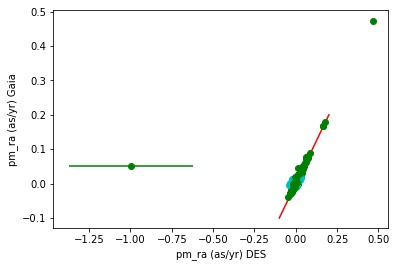

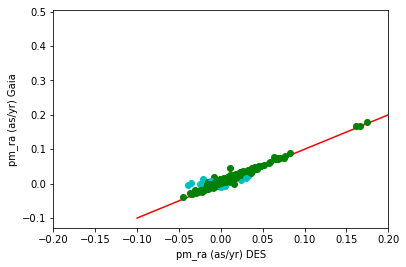

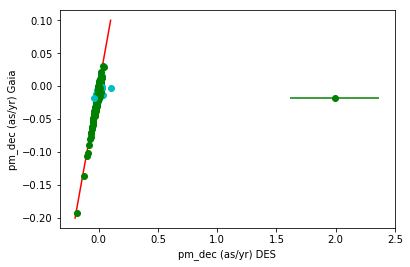

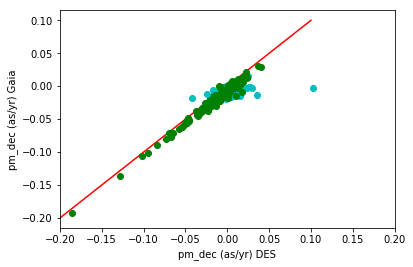

mu RA error (Gaia): median: 0.000847042529423 mean: 0.00108942841705
mu Dec error (Gaia): median: 0.000471644593689 mean: 0.000738336638845
mu RA difference: median: 0.0051534792435 mean: 0.00614825333093
mu Dec difference: median: -0.00636874998015 mean: -0.00851373802962


In [196]:
dicts.append(comparePM(tiles[33], cool, g))

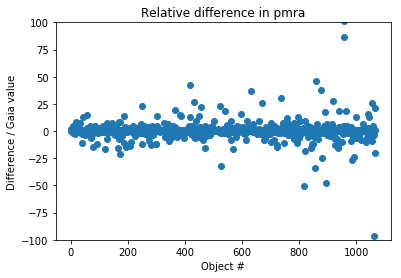

In [60]:

plt.title('Relative difference in pmra')
plt.scatter(range(len(dicts[0]['gaia_ra'])), (dicts[0]['diff_ra'])/np.array(dicts[0]['gaia_ra']))
plt.xlabel('Object #')
plt.ylabel('Difference / Gaia value')
plt.ylim(-100, 100)
plt.show()

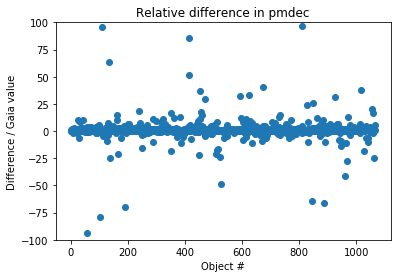

In [61]:

plt.title('Relative difference in pmdec')
plt.scatter(range(len(dicts[0]['gaia_dec'])), (dicts[0]['diff_dec'])/np.array(dicts[0]['gaia_dec']))
plt.xlabel('Object #')
plt.ylabel('Difference / Gaia value')
plt.ylim(-100, 100)
plt.show()

### WD J0135-039

In [62]:
g[650]

designation,source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,phot_g_mean_mag,bp_rp,radial_velocity,radial_velocity_error,teff_val,a_g_val
str28,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
Gaia DR2 2480893128736076544,2480893128736076544,23.8924849589,0.457066970722,-3.95587411054,0.311576094345,7.13998990079,0.512000087351,473.861003311,0.908930378412,-191.907913476,0.588725795975,19.567295,0.6945343,--,--,--,--


In [63]:
tiles[33][matches[33]]

MATCH_ID,COADD_ID,SPREAD_MODEL,SPREADERR_MODEL,CHI2_RED,RA_0,RA_ERR,DEC_0,DEC_ERR,MU_RA,MU_RA_ERR,MU_DEC,MU_DEC_ERR,COV_MU_RA_MU_DEC,COV_RA_MU_RA,COV_RA_DEC,COV_RA_MU_DEC,COV_DEC_MU_RA,COV_DEC_MU_DEC,RA,DEC,N,CHI_NULL,VEL,SIGMA_VEL,SIMBAD_MATCH,SIMBAD_#,MATCH_DIST,GAIA_MATCH,GAIA_MATCH_DIST
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str50,int32,float64,str50,float64
1021.0,233004495.0,0.00492281327024,0.000178967762622,1.19084588522,23.8909943784,0.000270921240908,-3.9552800437,0.000246566427014,0.465738180219,1.91875070887e-06,-0.185338769113,1.74739020029e-06,1.96525863649e-07,-2.26909179961e-05,2.31531014693e-05,-2.12037406806e-06,-2.12783677889e-06,-2.06612148197e-05,23.892351,-3.955793,27.0,144490.457489,0.500230136448,0.00132663601792,[OHD2001] WD J0135-039,1104,4.86072569444e-06,Gaia DR2 2480893128736076544,2.45239139379e-08


## Zone 55 Gaia

In [24]:
z55 = Table.read('zone055/DES0304-1749_proper.fits')

In [25]:
max(z55['RA']) #46.621
min(z55['RA']) # 45.84
max(z55['DEC']) # -17.46
min(z55['DEC']) # -18.2

-18.197403999999999

In [26]:
# g for gaia - gaia table
g2 = Table.read('zone055/Gaia-0304-1749.csv')

In [27]:
tree_c = kdTreeGaia(g2)

In [28]:
processTile('zone055/DES0304-1749_proper.fits', tree2)

Tile number: 1
Matches: 0


In [69]:
tiles[-1]

MATCH_ID,COADD_ID,SPREAD_MODEL,SPREADERR_MODEL,CHI2_RED,RA_0,RA_ERR,DEC_0,DEC_ERR,MU_RA,MU_RA_ERR,MU_DEC,MU_DEC_ERR,COV_MU_RA_MU_DEC,COV_RA_MU_RA,COV_RA_DEC,COV_RA_MU_DEC,COV_DEC_MU_RA,COV_DEC_MU_DEC,RA,DEC,N,CHI_NULL,VEL,SIGMA_VEL,SIMBAD_MATCH,SIMBAD_#,MATCH_DIST
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str50,int32,float64
3.0,343958491.0,-0.000145258454722,0.000328589609126,1.43523017065,46.0462563133,0.00226633737552,-17.6424980825,0.0019602966425,-0.00639930837428,1.55098561769e-05,-0.017264424709,1.34441271239e-05,-7.97734279269e-09,-0.000187120165594,1.94899363563e-06,-2.1026437514e-08,-1.74140842129e-08,-0.000162051076467,46.046196,-17.642531,20.0,24.8190937471,0.0183098308043,0.00369706229454,,0,0.0
4.0,343958208.0,0.000667351880111,0.000768247060478,1.27090650605,46.0511959499,0.00354683836181,-17.6365242306,0.00332595043232,-0.00912672577279,2.43601012488e-05,-0.00692154354631,2.28018602514e-05,1.24664241379e-07,-0.000293224812551,2.36146891954e-05,-1.72927095976e-06,-1.72555322137e-06,-0.000274727803694,46.051132,-17.636521,26.0,5.49225223076,0.0111156917621,0.00488645072428,,0,0.0
5.0,343957669.0,0.000269018812105,0.000316035730066,1.23222785721,46.0902137276,0.00110632969815,-17.6265170786,0.000960753193109,-0.00049099468422,7.77746496622e-06,0.00275871785805,6.76756221453e-06,-1.46782924924e-07,-9.25223902802e-05,-2.00550458212e-05,1.71587010618e-06,1.7157116528e-06,-8.04367350493e-05,46.090176,-17.626483,34.0,1.14847126049,0.00279812343524,0.00261614401739,,0,0.0
6.0,343957456.0,-0.000194323933101,0.000256912171608,2.46970485234,46.0903269394,0.000638667654297,-17.6222400162,0.000492771892659,0.00422431047435,4.52996752028e-06,-0.00415762941535,3.48436791824e-06,8.5557867114e-08,-5.3644291603e-05,1.62882248804e-05,-1.19514695352e-06,-1.18494925695e-06,-4.13320189188e-05,46.090307,-17.622231,34.0,9.09487860267,0.00578750220248,0.00197606946365,,0,0.0
7.0,343957244.0,7.78695830377e-05,8.52160956129e-05,3.32004087185,46.060296939,0.000298331373545,-17.6186646449,0.000180380762079,-0.00104470871642,2.14856317469e-06,0.00193669624208,1.30404862378e-06,8.99989215664e-08,-2.52483704634e-05,1.58410832513e-05,-1.20480626391e-06,-1.19205110499e-06,-1.5298872532e-05,46.060261,-17.618636,34.0,3.52441258971,0.00217766351687,0.00118634383407,,0,0.0
8.0,343957186.0,-0.00018953246763,0.000208281999221,1.86830012748,46.0737080979,0.000642989686412,-17.6168550263,0.00050152598523,-0.00828386049624,4.55275959507e-06,-0.00508835758618,3.56391059551e-06,-6.68666989382e-08,-5.39635439267e-05,-8.18616169118e-06,7.42143459405e-07,7.43010044716e-07,-4.21726824838e-05,46.073646,-17.616846,34.0,22.6912403673,0.00939298246917,0.00204979933288,,0,0.0
9.0,343956779.0,-0.000116029528726,5.34884748049e-05,5.71391347196,46.0848810994,0.000261218275988,-17.6105571254,0.000146955132414,-0.00106079790635,1.88489351413e-06,0.00871539315846,1.06684768487e-06,1.46279174972e-08,-2.21280091824e-05,4.2931000163e-06,-2.6797372556e-07,-2.6367418489e-07,-1.24888010615e-05,46.084843,-17.610505,34.0,71.9377821863,0.00877384570387,0.00103651449858,,0,0.0
10.0,343956922.0,0.000388658430893,0.000231605765293,1.99446042019,46.0691491697,0.000506663362234,-17.6119065596,0.000354873499298,-0.0063867630777,3.60067474598e-06,0.00601456611635,2.51171100607e-06,1.42961946688e-07,-4.25939541027e-05,2.55469149229e-05,-1.92538458674e-06,-1.91412096886e-06,-2.97768086928e-05,46.069095,-17.611865,33.0,27.0066621582,0.00855753935922,0.00170874078674,,0,0.0
11.0,343956821.0,-0.00101262319367,0.000530059274752,1.49652578711,46.0771513694,0.00224812671029,-17.609374827,0.00209844276726,-0.0085516895105,1.56761625224e-05,0.00295951238336,1.4651342742e-05,-1.86132549132e-07,-0.000187243922038,-2.601086682e-05,2.19913833635e-06,2.19872509507e-06,-0.000174899734171,46.077088,-17.609341,32.0,5.22270999753,0.00867162087609,0.0

In [29]:
cool_c = getGaiaMatches(tiles[-1], tree_c)
print('Matches found:', len(tiles[-1][cool_c]))
print('Gaia results:', len(g2))

Matches: 1014
Matches found: 1014
Gaia results: 1164


In [71]:
g2[np.where(g2['designation'] == 'Gaia DR2 5152771117978774272')]

designation,source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,phot_g_mean_mag,bp_rp,radial_velocity,radial_velocity_error,teff_val,a_g_val
str28,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
Gaia DR2 5152771117978774272,5152771117978774272,45.9706739212,0.252682262837,-17.6422170238,0.321345632409,0.488663969307,0.325132024729,9.49335461457,0.580821536582,-26.0133560239,0.697218998163,19.119236,1.8910084,--,--,--,--


In [30]:
tiles[-1][cool_c]

MATCH_ID,COADD_ID,SPREAD_MODEL,SPREADERR_MODEL,CHI2_RED,RA_0,RA_ERR,DEC_0,DEC_ERR,MU_RA,MU_RA_ERR,MU_DEC,MU_DEC_ERR,COV_MU_RA_MU_DEC,COV_RA_MU_RA,COV_RA_DEC,COV_RA_MU_DEC,COV_DEC_MU_RA,COV_DEC_MU_DEC,RA,DEC,N,CHI_NULL,VEL,SIGMA_VEL,SIMBAD_MATCH,SIMBAD_#,MATCH_DIST,GAIA_MATCH,GAIA_MATCH_DIST
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str50,int32,float64,str50,float64
6.0,343957456.0,-0.000194323933101,0.000256912171608,2.46970485234,46.0903269394,0.000638667654297,-17.6222400162,0.000492771892659,0.00422431047435,4.52996752028e-06,-0.00415762941535,3.48436791824e-06,8.5557867114e-08,-5.3644291603e-05,1.62882248804e-05,-1.19514695352e-06,-1.18494925695e-06,-4.13320189188e-05,46.090307,-17.622231,34.0,9.09487860267,0.00578750220248,0.00197606946365,,0,0.0,Gaia DR2 5152759714840548480,1.99089855873e-09
7.0,343957244.0,7.78695830377e-05,8.52160956129e-05,3.32004087185,46.060296939,0.000298331373545,-17.6186646449,0.000180380762079,-0.00104470871642,2.14856317469e-06,0.00193669624208,1.30404862378e-06,8.99989215664e-08,-2.52483704634e-05,1.58410832513e-05,-1.20480626391e-06,-1.19205110499e-06,-1.5298872532e-05,46.060261,-17.618636,34.0,3.52441258971,0.00217766351687,0.00118634383407,,0,0.0,Gaia DR2 5152759744905384704,1.79715664802e-09
8.0,343957186.0,-0.00018953246763,0.000208281999221,1.86830012748,46.0737080979,0.000642989686412,-17.6168550263,0.00050152598523,-0.00828386049624,4.55275959507e-06,-0.00508835758618,3.56391059551e-06,-6.68666989382e-08,-5.39635439267e-05,-8.18616169118e-06,7.42143459405e-07,7.43010044716e-07,-4.21726824838e-05,46.073646,-17.616846,34.0,22.6912403673,0.00939298246917,0.00204979933288,,0,0.0,Gaia DR2 5152759783560063616,2.37666407997e-09
9.0,343956779.0,-0.000116029528726,5.34884748049e-05,5.71391347196,46.0848810994,0.000261218275988,-17.6105571254,0.000146955132414,-0.00106079790635,1.88489351413e-06,0.00871539315846,1.06684768487e-06,1.46279174972e-08,-2.21280091824e-05,4.2931000163e-06,-2.6797372556e-07,-2.6367418489e-07,-1.24888010615e-05,46.084843,-17.610505,34.0,71.9377821863,0.00877384570387,0.00103651449858,,0,0.0,Gaia DR2 5152759779265127808,2.04469730058e-09
10.0,343956922.0,0.000388658430893,0.000231605765293,1.99446042019,46.0691491697,0.000506663362234,-17.6119065596,0.000354873499298,-0.0063867630777,3.60067474598e-06,0.00601456611635,2.51171100607e-06,1.42961946688e-07,-4.25939541027e-05,2.55469149229e-05,-1.92538458674e-06,-1.91412096886e-06,-2.97768086928e-05,46.069095,-17.611865,33.0,27.0066621582,0.00855753935922,0.00170874078674,,0,0.0,Gaia DR2 5152759779265126528,1.7654929294e-09
12.0,343957184.0,-0.000107789644971,7.46633304516e-05,4.36075462086,46.0578135639,0.000299178110192,-17.6173145837,0.000180314420405,-0.000827436783607,2.14868567309e-06,-0.000329332171434,1.30364962455e-06,1.84337141426e-09,-2.52844770502e-05,2.19497955325e-06,-1.0314622803e-07,-1.0007854744e-07,-1.52925209242e-05,46.057778,-17.617292,34.0,0.401476192841,0.000854632160273,0.00142285402732,,0,0.0,Gaia DR2 5152759951063815296,2.08077797612e-09
15.0,343955573.0,-0.000326720328303,3.49282745447e-05,9.08322911841,46.0543748889,0.000303122515781,-17.5872267914,0.000163950340389,0.00785382831803,2.23566372819e-06,0.000810268798457,1.21627819473e-06,-8.9567030447e-08,-2.59698553137e-05,-9.40911818753e-06,9.26969574674e-07,9.28572921307e-07,-1.40894558748e-05,46.054368,-17.5872,31.0,28.6337879696,0.00753044518647,0.00148482287821,,0,0.0,Gaia DR2 5152760058438506368,2.08120889992e-09
16.0,343950070.0,-0.00192645785864,0.000167533609783,2.71538718767,45.9577610468,0.000832551584691,-17.5042562544,0.00058370945843,0.0089766901533,5.86253843309e-06,0.00762060684906,4.16184520318e-06,-1.28124328702e-07,-6.9698528405e-05,-1.92451136533e-05,1.58723795288e-06,1.56296163676e-06,-4.91797384236e-05,45.957765,-17.504199,27.0,28.4364674108,0.0114614473675,0.0022323609456

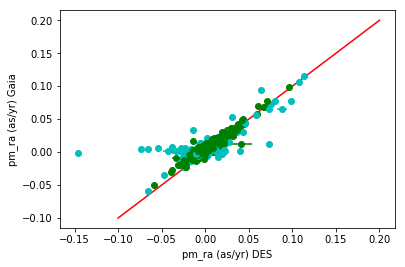

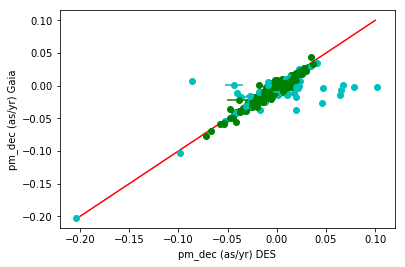

mu RA error (Gaia): median: 0.000549903114933 mean: 0.000779694402915
mu Dec error (Gaia): median: 0.000636663347664 mean: 0.000950578253095
mu RA difference: median: 0.00419293717482 mean: 0.00455460851338
mu Dec difference: median: -0.00326871174446 mean: -0.00379061467625


In [192]:
# more plots
dicts.append(comparePM(tiles[-1], cool_c, g2))

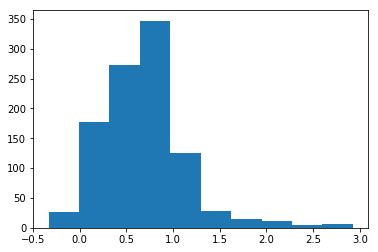

In [74]:
plt.hist(np.log10(tiles[-1][cool_c]['CHI2_RED']))
plt.show()

In [31]:
tiles[-1][cool_c][np.where(tiles[-1][cool_c]['MU_DEC'] > 0.05)]

MATCH_ID,COADD_ID,SPREAD_MODEL,SPREADERR_MODEL,CHI2_RED,RA_0,RA_ERR,DEC_0,DEC_ERR,MU_RA,MU_RA_ERR,MU_DEC,MU_DEC_ERR,COV_MU_RA_MU_DEC,COV_RA_MU_RA,COV_RA_DEC,COV_RA_MU_DEC,COV_DEC_MU_RA,COV_DEC_MU_DEC,RA,DEC,N,CHI_NULL,VEL,SIGMA_VEL,SIMBAD_MATCH,SIMBAD_#,MATCH_DIST,GAIA_MATCH,GAIA_MATCH_DIST
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str50,int32,float64,str50,float64
327.0,343950072.0,-0.000763258372899,1.66918107425e-05,566.299832429,46.5698294349,0.000251221515237,-17.5075332352,0.000121766099064,-0.0653144202634,1.80048204134e-06,0.0789228243464,8.83734277241e-07,8.07035497269e-09,-2.12168216406e-05,3.48917434747e-06,-1.8479101596e-07,-2.00034595883e-07,-1.0346420511e-05,46.569582,-17.507241,32.0,9470.31533956,0.100542180779,0.00110803862393,,0,0.0,Gaia DR2 5152741572899281920,9.69522162437e-10
1331.0,343968115.0,-0.000274141028058,2.17700035137e-05,717.826743002,45.8878923745,0.000254677537866,-17.8369561599,0.000125183073011,-0.0544127971484,1.8323270277e-06,0.0646295817737,9.12821605738e-07,-1.89432689976e-08,-2.15343901838e-05,3.25957926213e-07,9.7849367272e-08,9.9121141125e-08,-1.06573012123e-05,45.887663,-17.836702,28.0,6113.39930719,0.0828248097768,0.00113619281675,,0,0.0,Gaia DR2 5152380108451564800,2.1013284344e-09
2607.0,344114255.0,0.00155430077575,4.45595178462e-05,741.089331405,45.8833054067,0.00104591359855,-18.1708756792,0.00059008289816,0.0124457448824,8.03307603132e-06,0.102150755933,4.53629795617e-06,-7.79114821073e-08,-9.15131111238e-05,-1.58245493471e-06,5.06925455574e-07,5.53224560516e-07,-5.16646274374e-05,45.883299,-18.170509,15.0,2325.39083097,0.102832923433,0.00213652470221,,0,0.0,Gaia DR2 5152318290986898048,3.26834732603e-09
2820.0,344114389.0,0.00604342389852,0.000205919655855,717.172024218,46.4457306485,0.000713488943472,-18.174665157,0.00050840620378,-0.00286964708051,5.05406385208e-06,0.0667761143042,3.60129152112e-06,1.71809189085e-07,-5.98298886793e-05,2.40721980558e-05,-2.02621905918e-06,-2.02627245949e-06,-4.26333845602e-05,46.445674,-18.174448,28.0,1245.44750158,0.066831752606,0.00189465108973,,0,0.0,Gaia DR2 5152681099758928000,1.54826095387e-08
4816.0,343951064.0,-6.66863707011e-05,1.8770351744e-05,382.777989069,46.2760970563,0.000436259021557,-17.4862843219,0.000235479698908,0.0138965569161,3.16020935958e-06,0.0650984591644,1.7037176184e-06,3.08422870731e-07,-3.70614492861e-05,4.55715498151e-05,-3.73781844531e-06,-3.748619615e-06,-1.99891957017e-05,46.276117,-17.486034,23.0,2488.82616171,0.0664340914525,0.0013719647394,,0,0.0,Gaia DR2 5152767682005002496,1.72730707192e-09


In [76]:
g2[np.where(g2['designation'] == 'Gaia DR2 5152741572899281920')]

designation,source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,phot_g_mean_mag,bp_rp,radial_velocity,radial_velocity_error,teff_val,a_g_val
str28,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
Gaia DR2 5152741572899281920,5152741572899281920,46.5696049175,0.0568003952035,-17.5072620786,0.0572350511228,0.341842898601,0.077622394618,4.56269187004,0.0922298965256,-1.56469412103,0.109180332506,16.049347,0.8785238,--,--,5972.925,--


## Zone 9

In [77]:
z9 = Table.read('zone009/DES2205+0209_proper.fits')

In [78]:
max(z9['RA']) # 331.80482
#min(z9['RA']) # 331.06966
#max(z9['DEC']) # 2.51525
#min(z9['DEC']) # 1.79110

331.80481600000002

In [79]:
# g for gaia - gaia table
g3 = Table.read('zone009/Gaia-2205+0209.csv')
tree_b = kdTreeGaia(g3)

In [80]:
processTile('zone009/DES2205+0209_proper.fits', tree2)
cool_b = getGaiaMatches(tiles[-1], tree_b)

Tile number: 50
Matches: 0
Matches: 1652


In [81]:
tiles[-1][cool_b]

MATCH_ID,COADD_ID,SPREAD_MODEL,SPREADERR_MODEL,CHI2_RED,RA_0,RA_ERR,DEC_0,DEC_ERR,MU_RA,MU_RA_ERR,MU_DEC,MU_DEC_ERR,COV_MU_RA_MU_DEC,COV_RA_MU_RA,COV_RA_DEC,COV_RA_MU_DEC,COV_DEC_MU_RA,COV_DEC_MU_DEC,RA,DEC,N,CHI_NULL,VEL,SIGMA_VEL,SIMBAD_MATCH,SIMBAD_#,MATCH_DIST,GAIA_MATCH,GAIA_MATCH_DIST
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str50,int32,float64,str50,float64
1.0,70518088.0,0.00117960618809,0.000149226383655,3.01893037589,331.803620003,0.00031483829205,2.29366027014,0.00020819283906,0.00167153081622,2.55044261565e-06,-0.00222813638251,1.58873151655e-06,3.91039056414e-08,-2.81350614954e-05,1.68224094312e-05,-9.37331979351e-07,-9.9211464385e-07,-1.80483389185e-05,331.803622,2.29368,13.0,4.29388557468,0.00278462416856,0.00137737865821,,0,0.0,Gaia DR2 2682454225950626304,8.80742292377e-10
5.0,70522382.0,0.000549925782252,0.000143108802149,0.987664911688,331.803546956,0.000221486972412,2.19810081547,0.000153784379231,-0.00595343231955,1.89004349973e-06,0.000769172522331,1.21574167741e-06,-7.45199249052e-08,-2.03162517929e-05,-4.11431126835e-07,4.44421237788e-07,4.17530346196e-07,-1.35635561262e-05,331.803525,2.198132,17.0,18.9881784755,0.00599856992884,0.00137764644088,,0,0.0,Gaia DR2 2682452336164986112,8.42837213637e-10
6.0,70521502.0,0.000784999981988,0.000358805264113,1.24637364894,331.803111241,0.000338354234571,2.21773973311,0.000267651865741,0.00198524474788,2.86209083594e-06,0.00468043330381,2.15978326033e-06,-1.00104038827e-07,-3.089249901e-05,-2.3942743536e-06,6.70908244202e-07,6.51021601482e-07,-2.38510322073e-05,331.803112,2.217783,17.0,11.8400692285,0.00508347819458,0.00148148564006,,0,0.0,Gaia DR2 2682452576683162752,8.6412078172e-10
7.0,70521380.0,0.000652747927234,0.000238785185502,1.17274901385,331.801580543,0.000264964999715,2.21962575187,0.000195330963923,0.00461262095051,2.25087467299e-06,0.00479228337705,1.55905486016e-06,-8.58052851926e-08,-2.42465918676e-05,-1.20609366786e-06,5.41221115433e-07,5.16554173154e-07,-1.7310614093e-05,331.801588,2.219671,17.0,25.3172596665,0.00664908534088,0.00134378356086,,0,0.0,Gaia DR2 2682452576683163776,9.4716144248e-10
9.0,70519758.0,0.0,0.0,1.65191345528,331.797837129,0.000278117051766,2.25498472586,0.000212093032611,-0.00188920231724,2.27520740343e-06,-0.00312285750337,1.59614423539e-06,-4.92328313098e-08,-2.49746664827e-05,4.07283159043e-06,1.09072091541e-07,7.71706090326e-08,-1.8263319712e-05,331.797827,2.255007,14.0,7.84375830904,0.00364908190287,0.00131692136847,,0,0.0,Gaia DR2 2682453813633756928,1.32027478517e-09
15.0,70518659.0,0.0014442052925,3.05873982143e-05,2.86042558221,331.804322942,0.000168931905618,2.27742380872,0.000116266022399,-0.012354859061,1.46717146044e-06,-0.000966166511221,9.08984194338e-07,-5.46328021528e-08,-1.56209854578e-05,1.4144673747e-06,2.31334418445e-07,2.48815230111e-07,-1.01969604084e-05,331.804284,2.277452,16.0,106.281455884,0.0123828499981,0.00120634733733,,0,0.0,Gaia DR2 2682453989727431808,9.64960069934e-10
22.0,70530798.0,0.0,0.0,1.90097560778,331.796978031,0.000191643344917,2.00615302674,0.000143403479684,0.00242372556128,1.6120218825e-06,0.00852605968467,1.08101657203e-06,-3.79404885683e-08,-1.74541351177e-05,3.95929790298e-06,4.1020724971e-08,3.20636646983e-08,-1.23601977248e-05,331.796983,2.006208,15.0,71.8490092498,0.00886346094634,0.00104915514954,,0,0.0,Gaia DR2 2682427906390925952,9.11987315887e-10
26.0,70527630.0,0.0,0.0,121.073607873,331.796461586,0.0014758153319,2.06901641491,0.00163567011951,-0.0592418506937,1.44990227466e-05,-0.00916806889286,1.63421997642e-05,4.87744221239e-06,-0.000146056598008,0.000483664959603,-4.86012748437e-05,-4.84466073969e-05,-0.000163244615411,331.796282,2.069024,10.0,249.933863109,0.0599088954086,0.00400217801507,,0,0.0,Gaia DR2 2682441581566824704,1.46363764078e-09
31.0,70526692.0,-1.5064647414e-05,5.15376304975e-05,0.946310368247,3

In [82]:
print('Matches found', len(tiles[-1][cool_b]))
print('Gaia results', len(g3))

Matches found 1652
Gaia results 2000


In [83]:
g3[np.where(g3['designation'] == 'Gaia DR2 2682399181651172736')]

designation,source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,phot_g_mean_mag,bp_rp,teff_val,a_g_val
str28,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
Gaia DR2 2682399181651172736,2682399181651172736,331.760373731,0.592474403213,1.83578723509,0.577349386466,1.67952251922,0.658762556704,44.3173054758,0.958352315955,-23.7070246412,0.966901559113,20.003822,1.840107,--,--


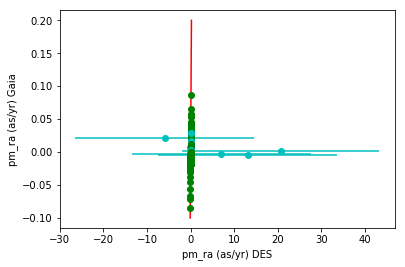

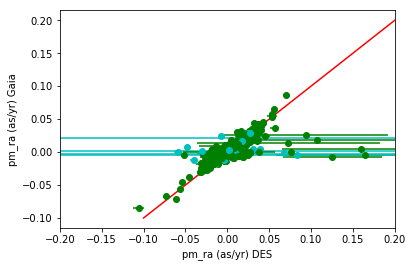

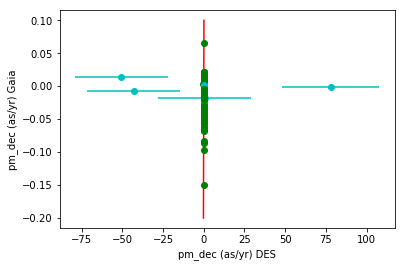

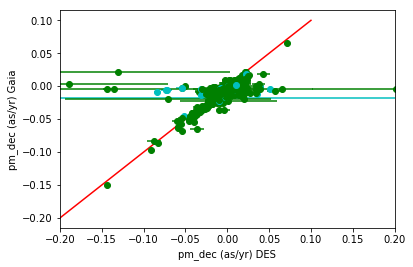

mu RA error (Gaia): median: 0.00061658229829 mean: 0.000627345560822
mu Dec error (Gaia): median: 0.000734028760005 mean: 0.000714516521134
mu RA difference: median: 0.00173175864109 mean: -0.0202024350667
mu Dec difference: median: -0.00535277519949 mean: 0.00389955167449


In [197]:
# more plots
dicts.append(comparePM(tiles[-1], cool_b, g3))

## Unmatched Gaia data

In [68]:
def Diff(li1, li2):
    li_dif = [i for i in li1 + li2 if i not in li1 or i not in li2]
    return li_dif

In [74]:
unmatched = Diff(list(tiles[33][cool]['GAIA_MATCH']), list(g['designation']))
print(len(unmatched))

110


In [70]:
ra_um = []
dec_um = []
photg_um = []
ra_m = []
dec_m = []
photg_m = []
for iden in g:
    if iden['designation'] in unmatched:
        ra_um.append(iden['ra'])
        dec_um.append(iden['dec'])
        photg_um.append(iden['phot_g_mean_mag'])
    else:
        ra_m.append(iden['ra'])
        dec_m.append(iden['dec'])
        photg_m.append(iden['phot_g_mean_mag'])

In [78]:
idx_um = [i for i,iden in enumerate(g) if iden['designation'] in unmatched]

In [82]:
g[idx_um][np.where(g[idx_um]['phot_g_mean_mag'] > 16)]

designation,source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,phot_g_mean_mag,bp_rp,radial_velocity,radial_velocity_error,phot_variable_flag,teff_val,a_g_val
str28,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str13,float64,float64
Gaia DR2 2480867255856044544,2480867255856044544,23.7530058878,1.69131689323,-4.0770972268,0.91724447153,-0.217786892902,1.60102149143,-1.13867636379,2.81475864676,-4.06298391624,1.97424004766,20.66389,0.6299896,--,--,NOT_AVAILABLE,--,--
Gaia DR2 2480786033726278528,2480786033726278528,23.7982033399,3.75861886506,-4.59559408781,3.5970427561,--,--,--,--,--,--,20.00986,1.6595039,--,--,NOT_AVAILABLE,--,--
Gaia DR2 2480879732733282304,2480879732733282304,23.6859799514,0.445867892669,-4.00885193507,0.271980142872,1.88650744183,0.495703760486,17.8416740634,0.811134717205,-13.4083038239,0.410359718381,18.16675,2.3911037,--,--,NOT_AVAILABLE,--,--
Gaia DR2 2480862273690926080,2480862273690926080,23.7691885002,3.45671786881,-4.19096719228,1.98343483345,--,--,--,--,--,--,20.371529,1.88974,--,--,NOT_AVAILABLE,--,--
Gaia DR2 2480852038783622784,2480852038783622784,23.5431238214,0.31948524141,-4.36064263045,0.20623021461,0.575974438144,0.339648925933,0.984016311093,0.98331368584,-11.0421772846,0.466907927855,18.635159,--,--,--,NOT_AVAILABLE,--,--
Gaia DR2 2480881416359920000,2480881416359920000,23.5190190116,0.855653175824,-4.06020299244,0.63721548312,1.65138636624,0.988956686349,-22.8799843515,2.07728867118,-15.3266928161,1.46046800067,20.518604,1.687706,--,--,NOT_AVAILABLE,--,--
Gaia DR2 2480802251523273344,2480802251523273344,23.6901450507,0.136340954151,-4.5036384897,0.095138254982,0.223960789075,0.15580011616,-0.9363594221,0.299900068399,-0.0786794673447,0.166421140434,16.71128,1.1084404,--,--,NOT_AVAILABLE,5095.6333,--
Gaia DR2 2480892342756801792,2480892342756801792,23.8920047076,3.05149772477,-3.98122417909,1.5895325538,--,--,--,--,--,--,19.475813,1.4494038,--,--,NOT_AVAILABLE,--,--
Gaia DR2 2480861900029089664,2480861900029089664,23.8476108998,2.72170638295,-4.19107016261,1.78302300223,--,--,--,--,--,--,19.59795,1.4146233,--,--,NOT_AVAILABLE,--,--


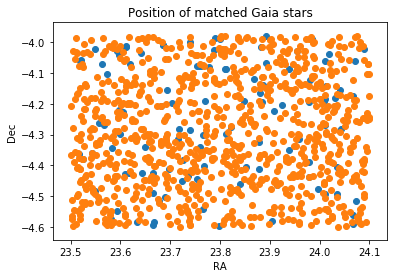

In [75]:
plt.scatter(ra_um, dec_um)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.title('Position of unmatched Gaia stars')
#plt.show()
#plot 2
plt.scatter(ra_m, dec_m)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.title('Position of matched Gaia stars')
plt.show()

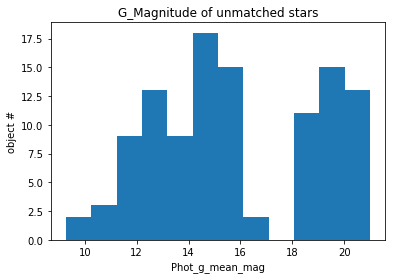

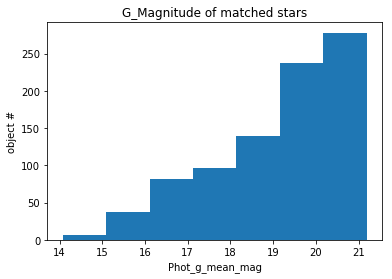

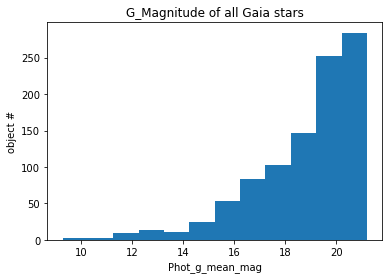

In [73]:
#plot 1
plt.hist(photg_um, bins = 12)
plt.ylabel('object #')
plt.xlabel('Phot_g_mean_mag')
plt.title('G_Magnitude of unmatched stars')
plt.show()
#plot 2
plt.hist(photg_m, bins = 7)
plt.ylabel('object #')
plt.xlabel('Phot_g_mean_mag')
plt.title('G_Magnitude of matched stars')
plt.show()
# plot 3
plt.hist([i for i in g['phot_g_mean_mag']], bins = 12)
plt.ylabel('object #')
plt.xlabel('Phot_g_mean_mag')
plt.title('G_Magnitude of all Gaia stars')
plt.show()

In [77]:
unmatched

['Gaia DR2 2480867255856044544',
 'Gaia DR2 2480864339570497024',
 'Gaia DR2 2480857742500732032',
 'Gaia DR2 2480809462772926208',
 'Gaia DR2 2480880076330667008',
 'Gaia DR2 2480786033726278528',
 'Gaia DR2 2480879870172237184',
 'Gaia DR2 2480804068294004480',
 'Gaia DR2 2480790461837611392',
 'Gaia DR2 2480880213769619584',
 'Gaia DR2 2480879732733282304',
 'Gaia DR2 2480814586669357184',
 'Gaia DR2 2480811288134475264',
 'Gaia DR2 2480814449230404096',
 'Gaia DR2 2480862273690926080',
 'Gaia DR2 2480859284393648000',
 'Gaia DR2 2480812456365563904',
 'Gaia DR2 2480805206460771200',
 'Gaia DR2 2480805069021818240',
 'Gaia DR2 2480804313107574400',
 'Gaia DR2 2480852038783622784',
 'Gaia DR2 2480807336764563840',
 'Gaia DR2 2480881416359920000',
 'Gaia DR2 2480885642608300928',
 'Gaia DR2 2480886398522544512',
 'Gaia DR2 2480887223156264832',
 'Gaia DR2 2480798330217562368',
 'Gaia DR2 2480804003869439872',
 'Gaia DR2 2480890452971670912',
 'Gaia DR2 2480802526401180160',
 'Gaia DR2

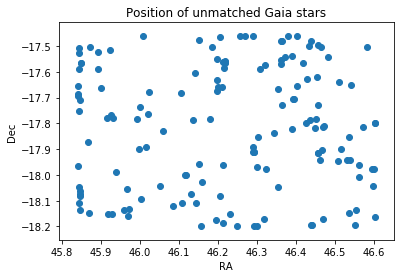

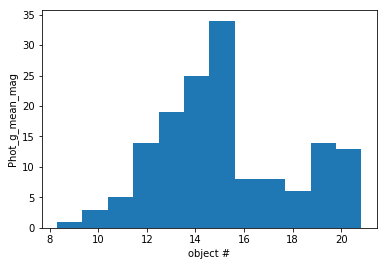

In [90]:
unmatched2 = Diff(list(tiles[-2][cool_c]['GAIA_MATCH']), list(g2['designation']))
ra_um = []
dec_um = []
photg_um = []
for iden in g2:
    if iden['designation'] in unmatched2:
        ra_um.append(iden['ra'])
        dec_um.append(iden['dec'])
        photg_um.append(iden['phot_g_mean_mag'])
plt.scatter(ra_um, dec_um)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.title('Position of unmatched Gaia stars')
plt.show()
#plot 2
plt.hist(photg_um, bins = 12)
plt.xlabel('object #')
plt.ylabel('Phot_g_mean_mag')
plt.show()

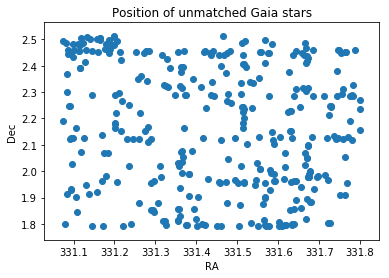

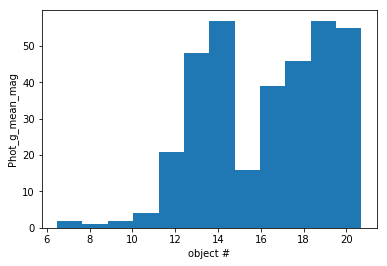

In [91]:
unmatched3 = Diff(list(tiles[-1][cool_b]['GAIA_MATCH']), list(g3['designation']))
ra_um = []
dec_um = []
photg_um = []
for iden in g3:
    if iden['designation'] in unmatched3:
        ra_um.append(iden['ra'])
        dec_um.append(iden['dec'])
        photg_um.append(iden['phot_g_mean_mag'])
plt.scatter(ra_um, dec_um)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.title('Position of unmatched Gaia stars')
plt.show()
#plot 2
plt.hist(photg_um, bins = 12)
plt.xlabel('object #')
plt.ylabel('Phot_g_mean_mag')
plt.show()

In [92]:
# g for gaia - gaia table
g_all = Table.read('Gaia-DR2-0135-0416.csv')

In [93]:
g_all

designation,source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,phot_g_mean_mag,bp_rp,radial_velocity,radial_velocity_error,teff_val,a_g_val
str28,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
Gaia DR2 2483888129690588160,2483888129690588160,23.4181099614,0.897393509445,-3.89342542138,0.481883525806,-1.15134427805,0.980300752486,-9.98393894353,1.5891830909,-10.0741654378,0.785249320168,20.10274,2.2814713,--,--,--,--
Gaia DR2 2483885449633358720,2483885449633358720,23.4649164982,1.38997036652,-3.95773263776,0.664852042531,0.558885724231,1.50157470679,-4.88229377169,1.94211787895,-13.6551126438,1.69223772334,20.56618,1.6265488,--,--,--,--
Gaia DR2 2483888099625694976,2483888099625694976,23.4115334397,0.563251770018,-3.90911636886,0.370402030846,1.43058076267,0.604905263456,21.3438489747,1.2007636247,6.04171121159,0.625341942492,19.773136,--,--,--,--,--
Gaia DR2 2483887545574764544,2483887545574764544,23.4976124236,0.0443120121204,-3.90383516176,0.0246102169708,1.99156841297,0.0485529158424,8.02156059971,0.0772188625921,5.22454302253,0.0465162482603,14.421044,1.1576614,--,--,4889.2524,0.2795
Gaia DR2 2483885758868638720,2483885758868638720,23.4162229918,1.02624656358,-3.93842507306,0.665589414104,0.202233242883,1.12016460193,15.3389424033,2.01516160366,-40.9367789709,1.04361560261,20.22315,2.0960178,--,--,--,--
Gaia DR2 2483887034474422272,2483887034474422272,23.464861045,1.97689875374,-3.93080900308,1.12900532868,--,--,--,--,--,--,18.760096,1.5204163,--,--,--,--
Gaia DR2 2483887137553637248,2483887137553637248,23.4769770742,0.734167680941,-3.92229176483,0.400280170014,0.871165441501,0.7742664751,43.9485632067,1.36620631413,-20.0763821032,0.714676897831,19.823349,2.1291637,--,--,--,--
Gaia DR2 2483887549870497536,2483887549870497536,23.4979327374,0.127937921604,-3.90372572092,0.0832481614206,1.76908320749,0.119960439005,7.98584547765,0.279821868876,5.42827344609,0.213737671385,16.797697,--,--,--,--,--
Gaia DR2 2483885385207011968,2483885385207011968,23.4271986073,2.6887717914,-3.96844095128,1.15373726146,--,--,--,--,--,--,20.716951,2.0223656,--,--,--,--


In [94]:
tree5 = kdTreeGaia(g_all)

In [95]:
cool_all = getGaiaMatches(tiles[33], tree5)

Matches: 1247


In [96]:
tiles[33][cool_all]

MATCH_ID,COADD_ID,SPREAD_MODEL,SPREADERR_MODEL,CHI2_RED,RA_0,RA_ERR,DEC_0,DEC_ERR,MU_RA,MU_RA_ERR,MU_DEC,MU_DEC_ERR,COV_MU_RA_MU_DEC,COV_RA_MU_RA,COV_RA_DEC,COV_RA_MU_DEC,COV_DEC_MU_RA,COV_DEC_MU_DEC,RA,DEC,N,CHI_NULL,VEL,SIGMA_VEL,SIMBAD_MATCH,SIMBAD_#,MATCH_DIST,GAIA_MATCH,GAIA_MATCH_DIST
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str50,int32,float64,str50,float64
1.0,233002478.0,-0.0042734220624,0.000131767446874,1.37843460609,23.4768375692,0.000221680270862,-3.92225524133,0.000131409061113,0.0426937200483,1.53337085578e-06,-0.011207691703,9.79173802757e-07,-1.99064001881e-09,-1.83553342014e-05,-3.24517316047e-06,1.46791688905e-07,1.59112444321e-07,-1.12715526197e-05,23.476918,-3.922236,24.0,1315.74203038,0.0440435875492,0.00122411768526,,0,0.0,Gaia DR2 2483887137553637248,6.59948250834e-09
5.0,233002531.0,-0.00245652813464,0.000103799378849,6.5806882163,23.4790608038,0.000180727633582,-3.91889436287,0.000112155838147,0.0152927838907,1.2656074818e-06,-0.00634953378773,8.35814068168e-07,4.26570648959e-09,-1.50595121696e-05,-1.14672695446e-06,2.40940795174e-08,2.86785586721e-08,-9.62596981325e-06,23.479058,-3.918865,31.0,233.811595035,0.0165255391767,0.00109504841829,,0,0.0,Gaia DR2 2483887133257938304,5.37526759423e-09
10.0,233002270.0,-0.00131305796094,0.000379893841455,0.672834630217,23.5262695658,0.000370524026893,-3.92444121235,0.000333066578023,-0.00358323928223,2.5687747766e-06,0.00179461368836,2.33451936053e-06,5.3840477098e-08,-3.07230454125e-05,7.71110702855e-06,-6.35337051091e-07,-6.401555194e-07,-2.77601761944e-05,23.526214,-3.924382,32.0,6.49651846731,0.00400001264758,0.00157430801432,,0,0.0,Gaia DR2 2480885054197278976,4.89150967577e-09
18.0,229839052.0,-0.000278117891867,6.93347319611e-05,7.32361120758,23.4941090177,0.000173651522445,-3.90769075124,0.000151322399492,-0.00647177110349,1.19540324581e-06,-0.00391182957546,1.05201559178e-06,5.68541028831e-08,-1.43547445662e-05,6.42794136097e-06,-6.04645221491e-07,-6.0122640384e-07,-1.25653468076e-05,23.494041,-3.907651,31.0,47.4160102138,0.00754928567175,0.00109877047923,,0,0.0,Gaia DR2 2483887167617678464,5.27481419345e-09
20.0,233002582.0,-0.000317332887789,0.000343545660144,1.19321375913,23.4934414601,0.000467401621103,-3.9138461869,0.000419325580915,-0.0010517638924,3.27297914875e-06,0.00260196617992,2.98073119434e-06,5.18059912979e-08,-3.89571905008e-05,7.29846088712e-06,-6.04061167839e-07,-6.11817265921e-07,-3.5199938223e-05,23.493391,-3.913782,30.0,2.63910363931,0.00280558045828,0.00172790976897,,0,0.0,Gaia DR2 2483887167617677568,5.56113804341e-09
22.0,233002550.0,-0.00137291115243,0.000399222422857,1.09743803354,23.4686774955,0.00043040723667,-3.91779206436,0.000421897584738,-0.00628399849004,3.19228915301e-06,0.00462750454666,3.14885356463e-06,9.78587124376e-08,-3.68874413645e-05,1.33573045231e-05,-1.13400565748e-06,-1.13593623038e-06,-3.62685180321e-05,23.468609,-3.917724,29.0,19.7555173223,0.00779218173494,0.00175597725884,,0,0.0,Gaia DR2 2483887339416368768,5.55565883477e-09
40.0,233003205.0,0.00230347272009,0.000144878038554,2.02400979314,23.7136930563,0.000174734171892,-3.92427667844,0.000106318829323,0.013259526659,1.16657722491e-06,-0.0299945633177,7.40615233182e-07,-3.65294596677e-09,-1.42208091146e-05,-2.45156126589e-06,1.29300429399e-07,1.28188942908e-07,-8.82486341047e-06,23.713685,-3.924318,28.0,1362.13361278,0.0327820893598,0.000901484088603,,0,0.0,Gaia DR2 2480904776687391744,5.40772009249e-09
53.0,233002713.0,0.00101531832479,2.29718334595e-05,3.75111869436,23.7686599862,0.000110382651843,-3.91644111729,5.41054122097e-05,0.0147060160458,7.53306074457e-07,-0.00183628733726,3.96498715702e-07,-1.93647311561e-09,-9.07818337579e-06,-2.02154050385e-06,9.80441212209e-08,1.01650533109e-07,-4.60103614706e-06,23.768659,-3.916398,29.0,295.248221434,0.0147861412626,0.000865031939796,,0,0.0,Gaia DR2

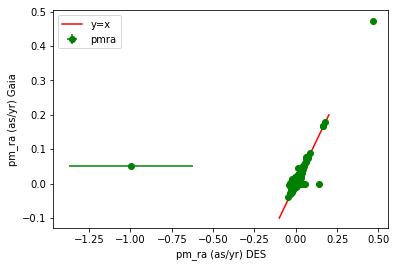

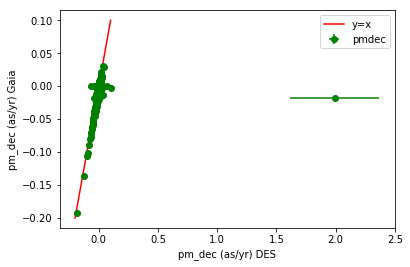

mu RA error (Gaia): median: 0.000662409509985 mean: 0.000932173312743
mu Dec error (Gaia): median: 0.000364461738979 mean: 0.00063176037983
mu RA difference: median: 0.00504105373987 mean: 0.00526849158498
mu Dec difference: median: -0.00610933411225 mean: -0.0074853737264


In [97]:
all_d = comparePM(tiles[33], cool_all, g_all)

## PM for galaxies

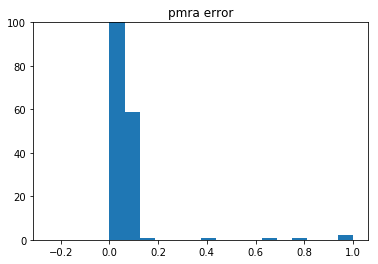

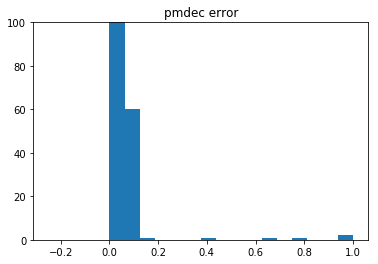

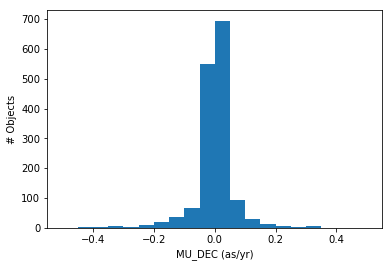

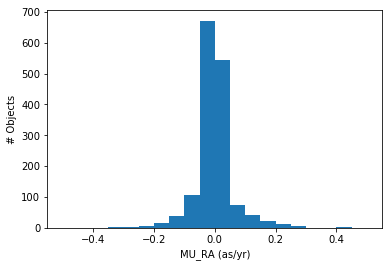

In [6]:
#
gals = Table.read('zone055/DES0304-1749_proper.fits')
#some[np.where(some['SPREAD_MODEL'] > 0.01)]['SPREAD_MODEL']
gal = np.where(gals['SPREAD_MODEL'] > 0.02)
plt.hist(np.sqrt(gals[np.where(gals['SPREAD_MODEL'] > 0.02)]['MU_RA_ERR']), range =(-0.25, 1), bins = 20)
plt.ylim(0, 100)
plt.title('pmra error')
plt.show()
plt.hist(np.sqrt(gals[np.where(gals['SPREAD_MODEL'] > 0.02)]['MU_DEC_ERR']), range =(-0.25, 1), bins = 20)
plt.ylim(0, 100)
plt.title('pmdec error')
plt.show()
plt.hist(gals[np.where(gals['SPREAD_MODEL'] > 0.02)]['MU_DEC'], range =(-0.5, 0.5), bins = 20)
#plt.ylim(0, 100)
plt.xlabel('MU_DEC (as/yr)')
plt.ylabel('# Objects')
#plt.title('pmdec')
plt.show()
plt.hist(gals[np.where(gals['SPREAD_MODEL'] > 0.02)]['MU_RA'], range =(-0.5, 0.5), bins = 20)
#plt.ylim(0, 100)
plt.xlabel('MU_RA (as/yr)')
plt.ylabel('# Objects')
#plt.title('pmra')
plt.show()


In [99]:
0.1/np.sqrt(len(gals[np.where(gals['SPREAD_MODEL'] > 0.02)]))

0.0025294174537134734

In [41]:
gal_m = getGaiaMatches(gals[gal], tree_c)

Matches: 63


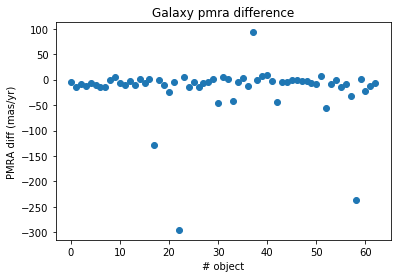

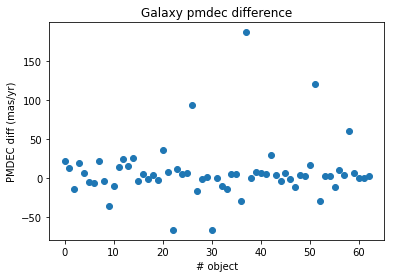

PMRA Diff Galaxies median: [-6.37498733]
PMDEC Diff Galaxies median: [ 3.14101893]


In [64]:
dpmra = []
dpmdec = []
for iden in gals[gal][gal_m]:
    g_id = iden['GAIA_MATCH']
    row = g2[np.where(g2['designation'] == g_id)]
    dpmra.append(iden['MU_RA']/1000 - row['pmra'])
    dpmdec.append(iden['MU_DEC']/1000 - row['pmdec'])
plt.scatter(range(len(dpmra)),dpmra)
plt.title('Galaxy pmra difference')
plt.xlabel('# object')
plt.ylabel('PMRA diff (mas/yr)')
plt.show()
plt.scatter(range(len(dpmdec)),dpmdec)
plt.title('Galaxy pmdec difference')
plt.xlabel('# object')
plt.ylabel('PMDEC diff (mas/yr)')
plt.show()
print('PMRA Diff Galaxies median:', median(dpmra).data)
print('PMDEC Diff Galaxies median:', median(dpmdec).data)

In [7]:
print('pmdec mean:', mean(gals[np.where(gals['SPREAD_MODEL'] > 0.02)]['MU_DEC']))
print('pmdec median:', median(gals[np.where(gals['SPREAD_MODEL'] > 0.02)]['MU_DEC']))
print('pmra mean:', mean(gals[np.where(gals['SPREAD_MODEL'] > 0.02)]['MU_RA']))
print('pmra median:', median(gals[np.where(gals['SPREAD_MODEL'] > 0.02)]['MU_RA']))
print('pmra error median:', median(np.sqrt(gals[np.where(gals['SPREAD_MODEL'] > 0.02)]['MU_RA_ERR']))/np.sqrt(len(gals[np.where(gals['SPREAD_MODEL'] > 0.02)])))
print('pmdec error median:', median(np.sqrt(gals[np.where(gals['SPREAD_MODEL'] > 0.02)]['MU_DEC_ERR']))/np.sqrt(len(gals[np.where(gals['SPREAD_MODEL'] > 0.02)])))
gals[np.where(gals['SPREAD_MODEL'] > 0.05)]

pmdec mean: 7.42360276956
pmdec median: 0.00227151825869
pmra mean: 34.0960377687
pmra median: -0.00173688577943
pmra error median: 0.000345532781477
pmdec error median: 0.000344804792441


MATCH_ID,COADD_ID,SPREAD_MODEL,SPREADERR_MODEL,CHI2_RED,RA_0,RA_ERR,DEC_0,DEC_ERR,MU_RA,MU_RA_ERR,MU_DEC,MU_DEC_ERR,COV_MU_RA_MU_DEC,COV_RA_MU_RA,COV_RA_DEC,COV_RA_MU_DEC,COV_DEC_MU_RA,COV_DEC_MU_DEC,RA,DEC,N,CHI_NULL,VEL,SIGMA_VEL
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
4597.0,344113207.0,1.0,1.0,8.48447492929,46.2312119041,0.000662839897933,-18.1497680259,0.000322049779783,-0.00385444668991,4.57817219472e-06,-0.0104580143371,2.26145387689e-06,-2.95186733925e-07,-5.48401154149e-05,-5.25547773151e-05,3.93258482532e-06,3.94826230026e-06,-2.68630956227e-05,46.231148,-18.149792,9.0,54.3639587402,0.0110808490962,0.00152656409994
4624.0,344114893.0,1.0,1.0,2.15176723879,46.5978044223,0.00242389593851,-18.1817629536,0.0020510201404,-0.00647466087794,1.61699279736e-05,0.0141191250219,1.35610263216e-05,-4.17440645205e-07,-0.000197301371692,-7.24790516504e-05,5.50110734251e-06,5.51180833843e-06,-0.00016621220787,46.597735,-18.181719,12.0,16.9581554329,0.0154009516717,0.00377927825309
4654.0,344114551.0,1.0,1.0,1.19233113928,46.5910949609,0.0106939975955,-18.1750410463,0.0103207529398,0.00816153428353,6.94538232068e-05,0.000731442382162,6.68319681714e-05,-3.66887244202e-07,-0.00085865325941,-5.71234472367e-05,4.56160815695e-06,4.56135117895e-06,-0.000827505421171,46.591067,-18.175034,9.0,0.96804076008,0.00778876041717,0.00832839099827
12390.0,343952298.0,1.0,1.0,0.535294489913,46.3595909131,0.0145773849772,-17.5188170818,0.0137529212635,0.0284208674405,8.95224274478e-05,0.00909285891901,8.43097656503e-05,-2.81690943436e-06,-0.0011400111595,-0.00048119897646,3.68029602935e-05,3.68060257966e-05,-0.00107463250823,46.3597,-17.51879,8.0,10.2071314069,0.0285873083571,0.00934324118372
12440.0,343952610.0,1.0,1.0,1.05893683338,46.3621895839,0.395552290353,-17.5256028961,0.393963832968,0.021379799316,0.00251657148839,-0.0494447970155,0.00250665369777,1.48636955779e-06,-0.0314785585676,0.000272853561955,-2.02498937043e-05,-2.02503247565e-05,-0.0313532315654,46.362135,-17.52586,4.0,1.1574523107,0.0534830154314,0.0500704224939
13574.0,344114270.0,1.0,1.0,0.963326376806,46.2607238539,0.148450724138,-18.1687966926,0.147773709333,0.00781807921521,0.00105261465667,0.0265815739345,0.0010474391775,5.41266223631e-07,-0.0124480179688,8.50908188394e-05,-6.76467134093e-06,-6.76467993539e-06,-0.0123890097089,46.26069,-18.168703,5.0,0.732441946821,0.0275999919808,0.0323742903581
13729.0,344114421.0,1.0,1.0,1.07311241716,46.5888142997,0.0547195040699,-18.1711917745,0.0541775252021,0.0102725423697,0.000376729654367,-0.0382944191298,0.000372708400398,7.87958631845e-07,-0.00452113318705,0.000122656917511,-9.79736460015e-06,-9.79739442436e-06,-0.00447462229635,46.588799,-18.171306,6.0,4.21915309854,0.0395186626701,0.0193022415774
16379.0,344113063.0,0.059134349227,0.0172256622463,0.997847298011,46.6058290827,0.161653123489,-18.1433256959,0.161572958215,0.0394370179693,0.00111848843831,0.0322596152129,0.00111760799041,-7.82073892059e-07,-0.0134185863469,-0.000107990645941,9.2059097069e-06,9.20917049307e-06,-0.0134100904323,46.605909,-18.143213,7.0,2.32328089243,0.0494484826435,0.0334266411798
17389.0,344114140.0,1.0,1.0,0.227492032955,46.2605570668,0.141974084369,-18.1660220314,0.14108465822,0.0845601047388,0.000961435679699,0.0115703547644,0.000955332899506,1.91344332397e-06,-0.0116348341402,0.000329829118735,-2.51194239795e-05,-2.51194451737e-05,-0.0115614694145,46.260771,-18.165984,3.0,7.57330890403,0.0811742369125,0.0310137323565


In [101]:
fin

RA,DEC,ERRAWIN_WORLD,XWIN_IMAGE,YWIN_IMAGE,SPREAD_MODEL,SPREADERR_MODEL,FLUX_AUTO,FLUXERR_AUTO,EXPNUM,IMAFLAGS_ISO,ERRBWIN_WORLD,A_IMAGE,ERRA_IMAGE,B_IMAGE,ERRB_IMAGE,THETA_IMAGE,ERRTHETAWIN_J2000,CHI2_MODEL,CHI2_PSF,CCDNUM,BAND,MJD_OBS,EXPTIME,MAG_ZERO,VERSION,X_GNOM,Y_GNOM,MAG_AUTO_G,MAG_AUTO_R,MAG_AUTO_I,MAG_AUTO_Z,MAG_AUTO_Y,COADD_OBJECT_ID,ALPHAWIN_J2000,DELTAWIN_J2000,FLUX_AUTO_G,FLUX_AUTO_R,FLUX_AUTO_I,FLUX_AUTO_Z,FLUX_AUTO_Y,MAGERR_AUTO_G,MAGERR_AUTO_R,MAGERR_AUTO_I,MAGERR_AUTO_Z,MAGERR_AUTO_Y,FLUXERR_AUTO_G,FLUXERR_AUTO_R,FLUXERR_AUTO_I,FLUXERR_AUTO_Y,SPREAD_MODEL_I,SPREADERR_MODEL_I,MATCH_ID,COLOR,NEW_RA,NEW_DEC
float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,int16,str5,float64,float64,float64,str30,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
23.478404,-3.915761,3.88414009649e-05,1855.63549805,3244.83349609,0.00696353986859,0.00509651005268,1672.68005371,238.104003906,232010,0,3.87397994928e-05,1.32693994045,-9999.0,0.493640989065,-9999.0,-3.66163992882,31.235200882,-9999.0,6.40577979549e-10,14,g,56544.3527767,90.0,31.3410968781,y4a1_v1.5,-2.76069554821,1.06016292751,1e+20,1e+20,1e+20,1e+20,1e+20,999999,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,0.0,1.33150100708,23.4785317028,-3.91586355064
23.478411,-3.915749,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,999999,999999,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,16959,N/A,1e+20,1e+20,1e+20,COADD,-2.76081693177,1.06027700015,23.3447284698,22.5147724152,22.0132274628,21.9903831482,22.0709075928,233002738,23.4784108165,-3.91574925081,459.313171387,986.486206055,1565.70300293,1598.9934082,1484.69348145,0.125666484237,0.089109711349,0.100008971989,0.124492883682,0.436510413885,53.1494216919,80.9442901611,144.18447876,596.762573242,0.00665117893368,0.0022047040984,0.0,1.33150100708,23.4784108165,-3.91574925081
23.478413,-3.915745,2.91511005344e-05,1765.3170166,3214.4855957,0.00550682004541,0.00538084004074,4603.02001953,759.780029297,370652,0,2.90657008009e-05,1.07752001286,-9999.0,0.831077992916,-9999.0,-50.2812004089,32.6792984009,-9999.0,2.02810997163e-11,14,i,56953.232467,90.0,31.1961688995,y4a1_v1.5,-2.76079209166,1.06026468929,1e+20,1e+20,1e+20,1e+20,1e+20,999999,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,0.0,1.33150100708,23.4784356011,-3.9157616248
23.478442,-3.915774,1.54458994075e-05,1549.00012207,2631.30102539,0.0162247996777,0.00339853996411,4987.29980469,588.918029785,372595,0,1.5373199858e-05,1.53030002117,-9999.0,1.4470499754,-9999.0,-33.7636985779,-31.3174991608,-9999.0,6.30964031023e-11,12,r,56959.2592162,90.0,31.6641025543,y4a1_v1.5,-2.76074429493,1.06020892373,1e+20,1e+20,1e+20,1e+20,1e+20,999999,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,0.0,1.33150100708,23.4784831566,-3.91581746345
23.478373,-3.915751,1.63110998983e-05,1514.23071289,2621.20385742,0.0112754004076,0.00373074994422,6820.75,902.994995117,379937,0,1.62625001394e-05,1.2553999424,-9999.0,1.14918994904,-9999.0,21.997800827,-29.9393005371,-9999.0,6.56333017449e-12,12,i,56982.1064331,90.0,31.6891498566,y4a1_v1.5,-2.76080592056,1.0602349838,1e+20,1e+20,1e+20,1e+20,1e+20,999999,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,0.0,1.33150100708,23.4784216499,-3.91579123999
23.478436,-3.915771,1.90248993022e-05,289.773071289,2461.18066406,0.0144705995917,0.00442619016394,6124.04003906,854.236999512,600486,0,1.89628008229e-05,1.3665599823,-9999.0,0.992020010948,-9999.0,35.689201355,-14.7565002441,-9999.0,1.94596005976e-11,27,i,57729.0947371,90.0,3

In [102]:
print('pmra error median:', median(np.sqrt(some[np.where(some['SPREAD_MODEL'] > 0.02)]['MU_RA_ERR'])))
print('pmdec error median:', median(np.sqrt(some[np.where(some['SPREAD_MODEL'] > 0.02)]['MU_DEC_ERR'])))

pmra error median: 0.0136605676129
pmdec error median: 0.0136317867157


## Gaia stars proper motions

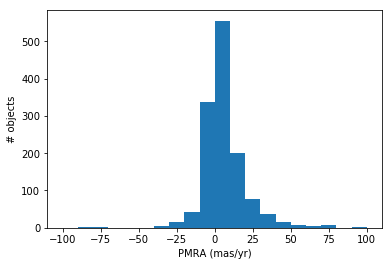

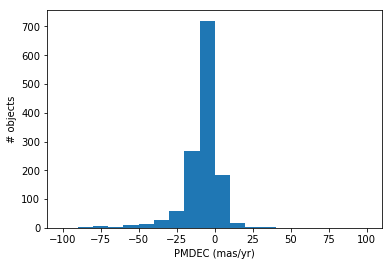

Median PMRA: 3.34806931619
Median PMDEC: -5.6148114673


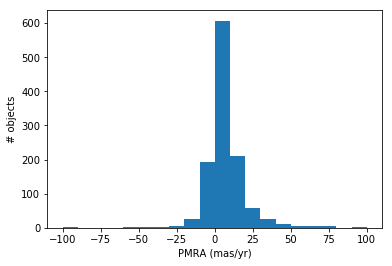

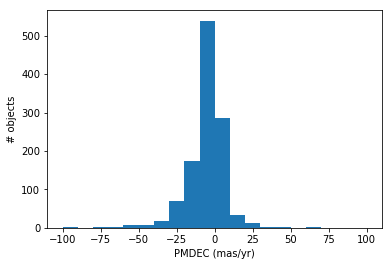

Median PMRA: 4.84367814198
Median PMDEC: -3.26532228848


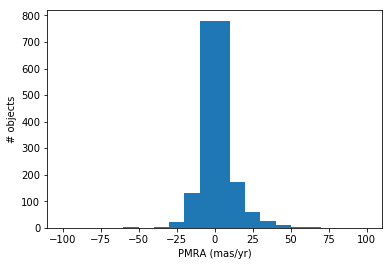

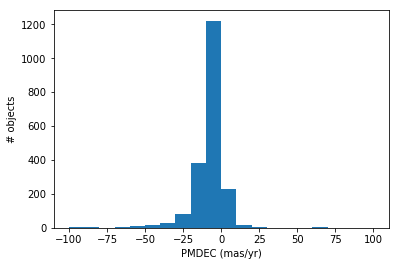

Median PMRA: 0.28161444114
Median PMDEC: -5.73819546652


In [103]:
def ProperMotionHist(gaia):
    plt.hist(gaia['pmra'], range = (-100, 100), bins = 20)
    plt.xlabel('PMRA (mas/yr)')
    plt.ylabel('# objects')
    #plt.title('Zone ')
    plt.show()
    #
    plt.hist(gaia['pmdec'], range = (-100, 100), bins = 20)
    plt.xlabel('PMDEC (mas/yr)')
    plt.ylabel('# objects')
    #plt.title('Zone 055')
    plt.show()
    print('Median PMRA:', median(gaia['pmra']))
    print('Median PMDEC:', median(gaia['pmdec']))
    
ProperMotionHist(g)
ProperMotionHist(g2)
ProperMotionHist(g3)

In [68]:
def matchedGaiaPMDiff(tile, gaia):
    dpmra = []
    dpmdec = []
    for iden in tile:
        g_id = iden['GAIA_MATCH']
        row = gaia[np.where(gaia['designation'] == g_id)]
        dpmra.append(iden['MU_RA']/1000 - row['pmra'])
        dpmdec.append(iden['MU_DEC']/1000 - row['pmdec'])
    print('PMRA Diff median:', median(dpmra).data)
    print('PMDEC Diff median:', median(dpmdec).data)

In [69]:
matchedGaiaPMDiff(tiles[0][cool_c],g2)
matchedGaiaPMDiff(gals[gal][gal_m], g2)

PMRA Diff median: [-4.711827093913573]
PMDEC Diff median: [3.2961306144742895]
PMRA Diff median: [-6.37498733]
PMDEC Diff median: [ 3.14101893]


## DES tile magnitudes

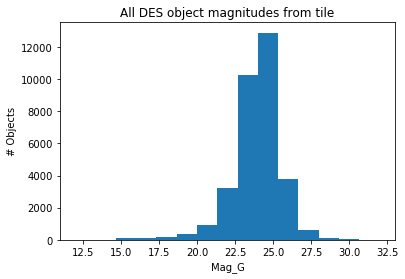

In [104]:
coadds = fin[np.where(fin['VERSION'] == 'COADD')]
plt.hist(coadds['MAG_AUTO_G'], range = (12, 32), bins = 15)
plt.xlabel('Mag_G')
plt.ylabel('# Objects')
plt.title('All DES object magnitudes from tile')
plt.show()

In [105]:
# unmatched DES
uncool = Diff(list(range(9524)), cool)
des_um = list(tiles[33][uncool]['MATCH_ID'])
des_um_l = []
for iden in coadds:
    if iden['MATCH_ID'] in des_um:   
        des_um_l.append(iden['MAG_AUTO_G'])


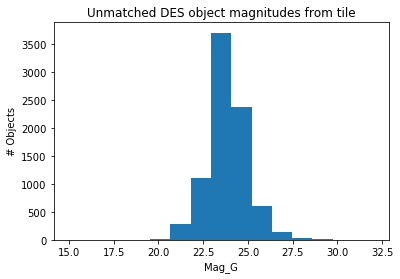

In [106]:
plt.hist(des_um_l, range = (15, 32), bins = 15)
plt.xlabel('Mag_G')
plt.ylabel('# Objects')
plt.title('Unmatched DES object magnitudes from tile')
plt.show()

In [107]:
fin2 = Table.read('zone055/DES0304-1749_final.fits')
outliers = tiles[-2][cool_c][np.where(tiles[-2][cool_c]['MU_DEC'] > 0.05)]

In [211]:
def posOverTime(match_id, final):
    pec = final[np.where(final['MATCH_ID'] == match_id)]
    pec2 = pec[np.where(pec['VERSION'] != 'COADD')]
    ra_1, dec_1 = predictPositions(match_id, final, pec2['MJD_OBS'])
    ts1 = theilslopes(pec2['NEW_DEC'], pec2['NEW_RA'])
    abline_values = [ts1[0] * i + ts1[1] for i in pec2['NEW_RA']]
    #
    
    plt.plot(pec2['NEW_RA'], abline_values, '--')
    plt.plot(ra_1, dec_1)
    plt.errorbar(pec2['NEW_RA'], pec2['NEW_DEC'],fmt ='bo', markersize = 2, xerr = pec2['ERRAWIN_WORLD'], yerr = pec2['ERRBWIN_WORLD'])
    plt.title('Plot for: %s' % str(match_id))
    plt.xlim(min(pec2['NEW_RA']) - 10**-5, max(pec2['NEW_RA']) + 10**-5)
    plt.ylim(min(pec2['NEW_DEC']) - 10**-5, max(pec2['NEW_DEC']) + 10**-5)
    plt.xlabel('RA')
    plt.ylabel('DEC')
    plt.show()
    #
    ts2 = theilslopes(pec2['NEW_RA'], pec2['MJD_OBS'])
    line2 = [ts2[0] * i + ts2[1] for i in pec2['MJD_OBS']]
    print('MU_RA', ts2[0] * 3600 *365.25)
    plt.scatter(pec2['MJD_OBS'], pec2['NEW_RA'])
    plt.plot(pec2['MJD_OBS'], line2, '--')
    plt.plot(pec2['MJD_OBS'], np.array(ra_1))
    plt.ylim(min(pec2['NEW_RA']) - 10**-5, max(pec2['NEW_RA']) + 10**-5)
    plt.ylabel('RA')
    plt.xlabel('Time')
    #for i in pec2:
        #plt.text(i['MJD_OBS'], i['NEW_RA'], i['MJD_OBS'])
    plt.show()
    #
    ts3 = theilslopes(pec2['NEW_DEC'], pec2['MJD_OBS'])
    line3 = [ts3[0] * i + ts3[1] for i in pec2['MJD_OBS']]
    print('MU_DEC', ts3[0] * 3600 * 365.25)
    plt.scatter(pec2['MJD_OBS'], pec2['NEW_DEC'])
    plt.plot(pec2['MJD_OBS'], line3, '--')
    plt.plot(pec2['MJD_OBS'], np.array(dec_1))
    plt.ylim(min(pec2['NEW_DEC']) - 10**-5, max(pec2['NEW_DEC']) + 10**-5)
    plt.ylabel('DEC')
    plt.xlabel('Time')
    for i in pec2:
        #plt.text(i['MJD_OBS'], i['NEW_DEC'], i['MJD_OBS'])
        pass
    plt.show()

In [109]:
pec = fin2[np.where(fin2['MATCH_ID'] == 327.0)]
pec2 = pec[np.where(pec['VERSION'] != 'COADD')]

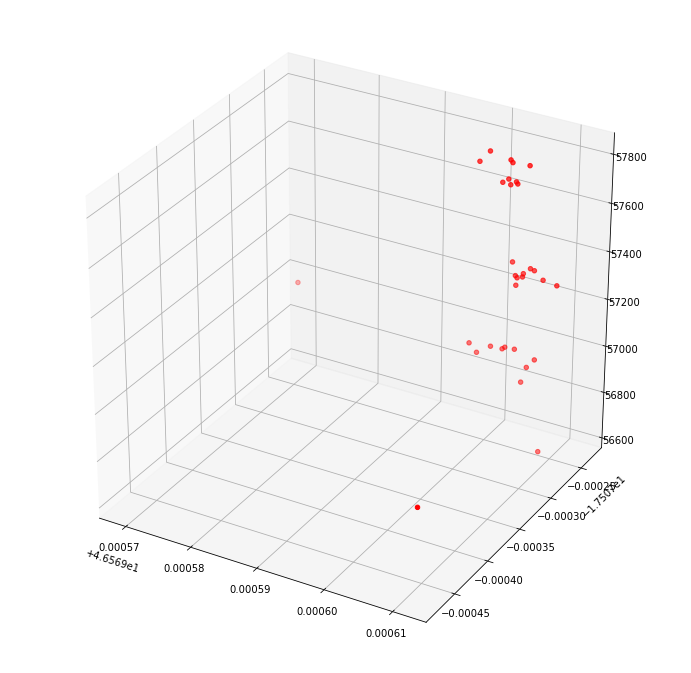

In [110]:
bx = plt.figure(figsize = (12, 12)).add_subplot(111, projection='3d')
bx.scatter(pec2['NEW_RA'], pec2['NEW_DEC'], pec2['MJD_OBS'], c='r', marker='o')
plt.show()

In [111]:
def predictPositions(match_id, final, mjd):
    pec = final[np.where(final['MATCH_ID'] == match_id)]
    pec2 = pec[np.where(pec['VERSION'] != 'COADD')]
    # get time range
    time0 = min(mjd)
    time_max = max(mjd)
    time = list(mjd)
    #time = np.linspace(np.ceil(time0), np.ceil(time_max), n = time_max - time0)
    # get mu_ra and mu_dec using match id
    pmra = tiles[-2][np.where(tiles[-2]['MATCH_ID'] == match_id)]['MU_RA'] / 3600
    pmdec = tiles[-2][np.where(tiles[-2]['MATCH_ID'] == match_id)]['MU_DEC'] / 3600
    # get earliest position
    ra0, dec0 = pec2[np.where(mjd == min(mjd))]['NEW_RA'], pec2[np.where(mjd == min(mjd))]['NEW_DEC']
    # ra and dec calc
    ra = []
    dec = []
    # calculate cumulative array
    for t in time:
        dt = (t - time0) / 365.25
        ra.append(ra0 + (pmra*dt))
        dec.append(dec0 + (pmdec*dt))
    return ra, dec

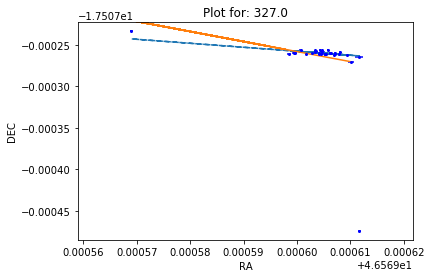

MU_RA -0.00269304043923


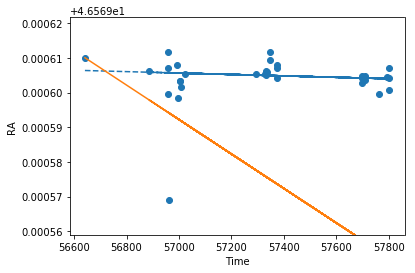

MU_DEC 0.00127610629046


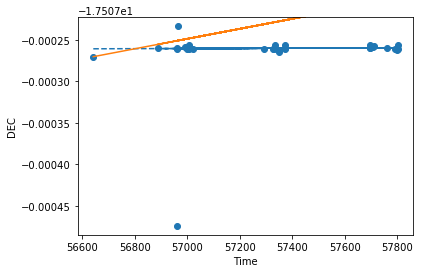

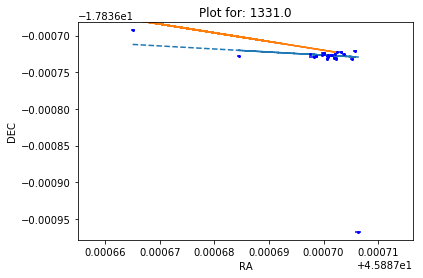

MU_RA 0.00177637592037


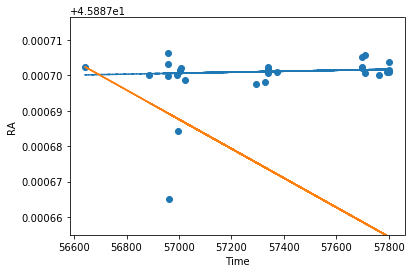

MU_DEC -0.00496256956917


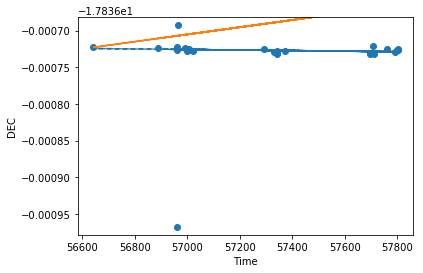

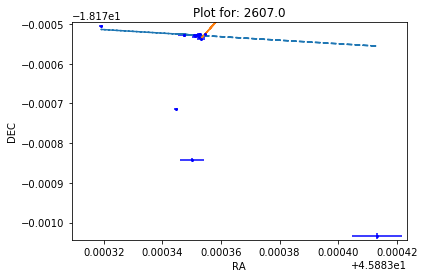

MU_RA -0.00145148711227


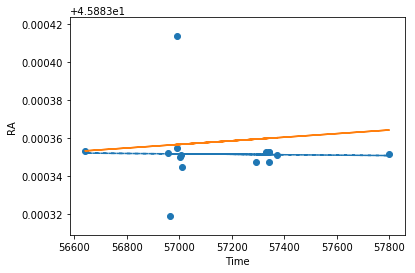

MU_DEC 0.00707517494625


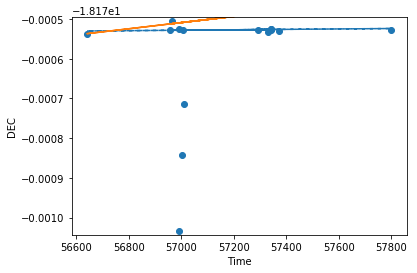

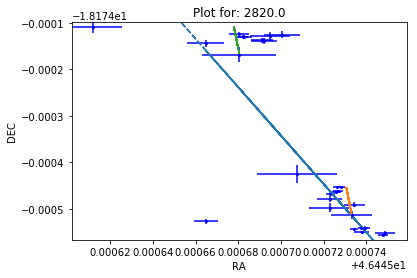

MU_RA -0.00172855597513


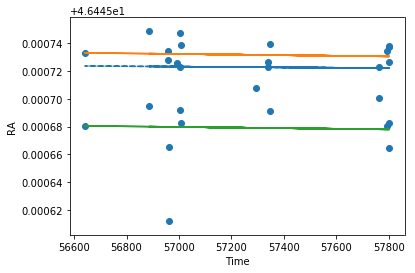

MU_DEC 0.00184416587411


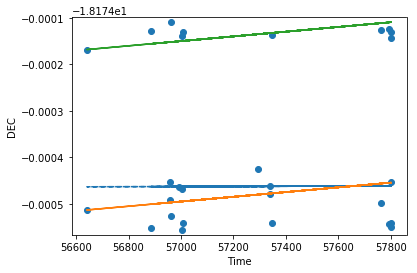

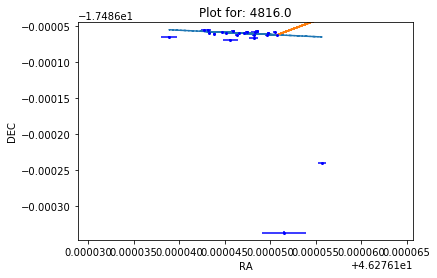

MU_RA -0.00653472202559


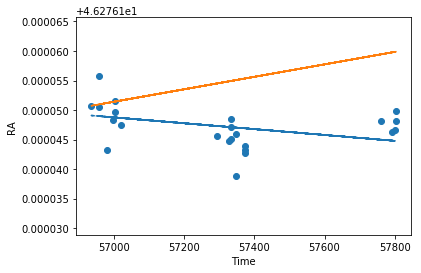

MU_DEC 0.00158555312062


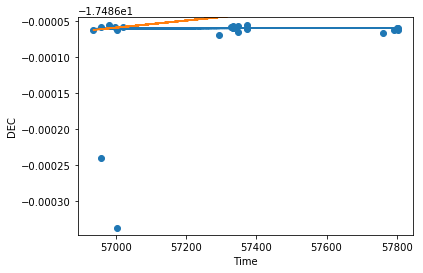

In [213]:
for i in outliers:
    posOverTime(i['MATCH_ID'], fin2)

## let's try animation

In [113]:
from matplotlib import animation

0


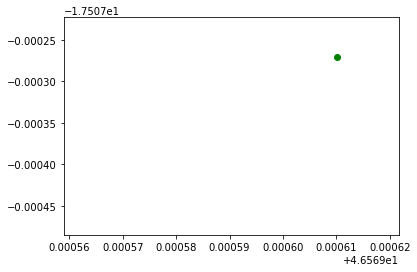

In [114]:

fig = plt.figure()
ax = plt.axes(xlim=(min(pec2['NEW_RA']) - 10**-5, max(pec2['NEW_RA']) + 10**-5), ylim=(min(pec2['NEW_DEC']) - 10**-5, max(pec2['NEW_DEC']) + 10**-5))
line = ax.plot(pec2['NEW_RA'][0], pec2['NEW_DEC'][0], 'go', animated = True)

# animation function.  This is called sequentially
def animate(i, line):
    print(i)
    x = pec2['NEW_RA'][0:i]
    y = pec2['NEW_DEC'][0:i]
    line.xdata = np.array(x)
    line.ydata = np.array(y)
    return line,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate,
                               frames=200, interval=2, blit=False, fargs = (line))
plt.show()

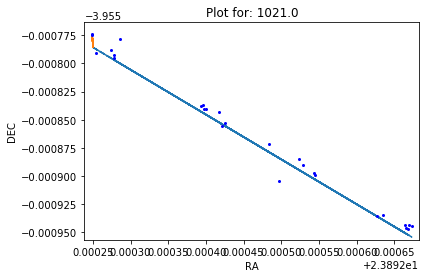

MU_RA 0.465594434626


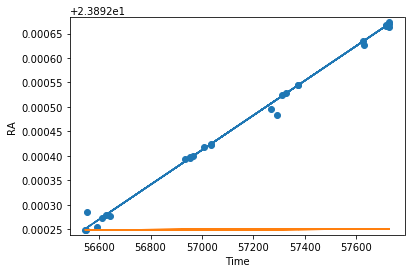

MU_DEC -0.185215692218


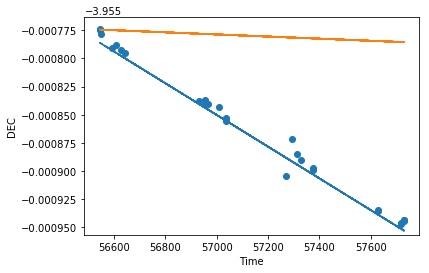

In [115]:
def predictPositions2(match_id, final, mjd):
    pec = final[np.where(final['MATCH_ID'] == match_id)]
    pec2 = pec[np.where(pec['VERSION'] != 'COADD')]
    # get time range
    time0 = min(mjd)
    time_max = max(mjd)
    time = list(mjd)
    #time = np.linspace(np.ceil(time0), np.ceil(time_max))
    # get mu_ra and mu_dec using match id
    pmra = tiles[33][np.where(tiles[33]['MATCH_ID'] == match_id)]['MU_RA'] / 3600
    pmdec = tiles[33][np.where(tiles[33]['MATCH_ID'] == match_id)]['MU_DEC'] / 3600
    print(pmra)
    print(pmdec)
    # get earliest position
    ra0, dec0 = pec2[np.where(pec2['MJD_OBS'] == min(pec2['MJD_OBS']))]['NEW_RA'], pec2[np.where(pec2['MJD_OBS'] == min(pec2['MJD_OBS']))]['NEW_DEC']
    # ra and dec calc
    ra = []
    dec = []
    # calculate cumulative array
    for t in time:
        dt = (t - time0) / 365.25
        ra.append(ra0 + (pmra*dt))
        dec.append(dec0 + (pmdec*dt))
    return ra, dec
posOverTime(1021.0, fin)

In [116]:
tiles[33][np.where(tiles[33]['MATCH_ID'] == 1021)]

MATCH_ID,COADD_ID,SPREAD_MODEL,SPREADERR_MODEL,CHI2_RED,RA_0,RA_ERR,DEC_0,DEC_ERR,MU_RA,MU_RA_ERR,MU_DEC,MU_DEC_ERR,COV_MU_RA_MU_DEC,COV_RA_MU_RA,COV_RA_DEC,COV_RA_MU_DEC,COV_DEC_MU_RA,COV_DEC_MU_DEC,RA,DEC,N,CHI_NULL,VEL,SIGMA_VEL,SIMBAD_MATCH,SIMBAD_#,MATCH_DIST,GAIA_MATCH,GAIA_MATCH_DIST
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str50,int32,float64,str50,float64
1021.0,233004495.0,0.00492281327024,0.000178967762622,1.19084588522,23.8909943784,0.000270921240908,-3.9552800437,0.000246566427014,0.465738180219,1.91875070887e-06,-0.185338769113,1.74739020029e-06,1.96525863649e-07,-2.26909179961e-05,2.31531014693e-05,-2.12037406806e-06,-2.12783677889e-06,-2.06612148197e-05,23.892351,-3.955793,27.0,144490.457489,0.500230136448,0.00132663601792,[OHD2001] WD J0135-039,1104,4.86072569444e-06,Gaia DR2 2480893128736076544,2.45239139379e-08


In [117]:
alg = fin2[np.where(fin2['MATCH_ID'] == 2820)]
tiles[-2][np.where(tiles[-2]['MATCH_ID'] == 2820)]

MATCH_ID,COADD_ID,SPREAD_MODEL,SPREADERR_MODEL,CHI2_RED,RA_0,RA_ERR,DEC_0,DEC_ERR,MU_RA,MU_RA_ERR,MU_DEC,MU_DEC_ERR,COV_MU_RA_MU_DEC,COV_RA_MU_RA,COV_RA_DEC,COV_RA_MU_DEC,COV_DEC_MU_RA,COV_DEC_MU_DEC,RA,DEC,N,CHI_NULL,VEL,SIGMA_VEL,SIMBAD_MATCH,SIMBAD_#,MATCH_DIST,GAIA_MATCH,GAIA_MATCH_DIST
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str50,int32,float64,str50,float64
2820.0,344114389.0,0.00604342389852,0.000205919655855,717.172024218,46.4457306485,0.000713488943472,-18.174665157,0.00050840620378,-0.00286964708051,5.05406385208e-06,0.0667761143042,3.60129152112e-06,1.71809189085e-07,-5.98298886793e-05,2.40721980558e-05,-2.02621905918e-06,-2.02627245949e-06,-4.26333845602e-05,46.445674,-18.174448,28.0,1245.44750158,0.066831752606,0.00189465108973,,0,0.0,Gaia DR2 5152681099758928000,1.54826095387e-08


In [118]:
tiles[33]

MATCH_ID,COADD_ID,SPREAD_MODEL,SPREADERR_MODEL,CHI2_RED,RA_0,RA_ERR,DEC_0,DEC_ERR,MU_RA,MU_RA_ERR,MU_DEC,MU_DEC_ERR,COV_MU_RA_MU_DEC,COV_RA_MU_RA,COV_RA_DEC,COV_RA_MU_DEC,COV_DEC_MU_RA,COV_DEC_MU_DEC,RA,DEC,N,CHI_NULL,VEL,SIGMA_VEL,SIMBAD_MATCH,SIMBAD_#,MATCH_DIST,GAIA_MATCH,GAIA_MATCH_DIST
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str50,int32,float64,str50,float64
0.0,233002738.0,0.00665117893368,0.0022047040984,1.17760930097,23.4784746589,0.0159229205179,-3.91582058861,0.0158176325229,-0.00515528422675,0.000116386117955,0.00628026398081,0.000115660282547,-2.06006981511e-08,-0.00135525153675,-4.34491522058e-06,3.12280102984e-07,3.12172218153e-07,-0.00134652589513,23.478411,-3.915749,19.0,0.569265996818,0.0081175569345,0.0107690232158,,0,0.0,,0.0
1.0,233002478.0,-0.0042734220624,0.000131767446874,1.37843460609,23.4768375692,0.000221680270862,-3.92225524133,0.000131409061113,0.0426937200483,1.53337085578e-06,-0.011207691703,9.79173802757e-07,-1.99064001881e-09,-1.83553342014e-05,-3.24517316047e-06,1.46791688905e-07,1.59112444321e-07,-1.12715526197e-05,23.476918,-3.922236,24.0,1315.74203038,0.0440435875492,0.00122411768526,,0,0.0,Gaia DR2 2483887137553637248,6.59948250834e-09
3.0,233002634.0,0.00328959245235,0.00215340894647,1.24983932751,23.4830809402,0.0106483380646,-3.91689417654,0.0105885284156,-0.0082097115419,7.7548367112e-05,0.000746642830775,7.71655847994e-05,-4.13644834258e-08,-0.000904296678921,-6.33202489567e-06,5.14399681336e-07,5.14186862093e-07,-0.00089951159846,23.483012,-3.916844,22.0,0.87626670681,0.0082244969091,0.00880640061319,,0,0.0,,0.0
4.0,227624387.0,-0.00321618909948,0.0014554518275,0.959069039032,23.4452264119,0.0025836315636,-3.91006500118,0.00255346644265,0.0394970711265,1.9893046276e-05,-0.0138922633122,1.97186345702e-05,3.90799770902e-08,-0.000225493424493,4.29239173008e-06,-4.0452526272e-07,-4.05371056869e-07,-0.000223181127107,23.4453,-3.910053,25.0,88.3174149491,0.0417822886109,0.00445525037819,,0,0.0,,0.0
5.0,233002531.0,-0.00245652813464,0.000103799378849,6.5806882163,23.4790608038,0.000180727633582,-3.91889436287,0.000112155838147,0.0152927838907,1.2656074818e-06,-0.00634953378773,8.35814068168e-07,4.26570648959e-09,-1.50595121696e-05,-1.14672695446e-06,2.40940795174e-08,2.86785586721e-08,-9.62596981325e-06,23.479058,-3.918865,31.0,233.811595035,0.0165255391767,0.00109504841829,,0,0.0,Gaia DR2 2483887133257938304,5.37526759423e-09
6.0,233002490.0,-0.00123213988263,0.000224185001571,1.40820442376,23.4709602539,0.000416135659542,-3.92177826539,0.000338076403604,0.0177785427473,2.91495237959e-06,0.027259274636,2.4375782937e-06,4.50032390306e-08,-3.46871026652e-05,4.11247103582e-06,-4.2853554049e-07,-4.3543602138e-07,-2.85717771493e-05,23.47096,-3.92164,27.0,407.248615288,0.0325217803048,0.00161886261022,,0,0.0,,0.0
10.0,233002270.0,-0.00131305796094,0.000379893841455,0.672834630217,23.5262695658,0.000370524026893,-3.92444121235,0.000333066578023,-0.00358323928223,2.5687747766e-06,0.00179461368836,2.33451936053e-06,5.3840477098e-08,-3.07230454125e-05,7.71110702855e-06,-6.35337051091e-07,-6.401555194e-07,-2.77601761944e-05,23.526214,-3.924382,32.0,6.49651846731,0.00400001264758,0.00157430801432,,0,0.0,Gaia DR2 2480885054197278976,4.89150967577e-09
11.0,233002838.0,-0.00326508120634,0.00212778849527,0.787835101207,23.5320568259,0.00607559093108,-3.91121434314,0.00601033265549,0.0016373841295,4.43368088519e-05,-0.00555486524944,4.39171548307e-05,4.44947485529e-10,-0.000516471332226,-4.26479720726e-07,2.16110287535e-08,2.09799328552e-08,-0.000511238015326,23.532016,-3.911178,25.0,0.763081331832,0.00579008471408,0.00662950359219,,0,0.0,,0.0
12.0,233002643.0,0.00401662476361,0.00152660673484,0.978496176151,23.5215228312,0.0054037623142,-3.91734740263,0.00530646310183,-0.0192806632531,3.93268603396e-05,0.00772324568414,3.86934700463e-05,-6.739153744

In [119]:
outliers

MATCH_ID,COADD_ID,SPREAD_MODEL,SPREADERR_MODEL,CHI2_RED,RA_0,RA_ERR,DEC_0,DEC_ERR,MU_RA,MU_RA_ERR,MU_DEC,MU_DEC_ERR,COV_MU_RA_MU_DEC,COV_RA_MU_RA,COV_RA_DEC,COV_RA_MU_DEC,COV_DEC_MU_RA,COV_DEC_MU_DEC,RA,DEC,N,CHI_NULL,VEL,SIGMA_VEL,SIMBAD_MATCH,SIMBAD_#,MATCH_DIST,GAIA_MATCH,GAIA_MATCH_DIST
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str50,int32,float64,str50,float64
327.0,343950072.0,-0.000763258372899,1.66918107425e-05,566.299832429,46.5698294349,0.000251221515237,-17.5075332352,0.000121766099064,-0.0653144202634,1.80048204134e-06,0.0789228243464,8.83734277241e-07,8.07035497269e-09,-2.12168216406e-05,3.48917434747e-06,-1.8479101596e-07,-2.00034595883e-07,-1.0346420511e-05,46.569582,-17.507241,32.0,9470.31533956,0.100542180779,0.00110803862393,,0,0.0,Gaia DR2 5152741572899281920,9.69522162437e-10
1331.0,343968115.0,-0.000274141028058,2.17700035137e-05,717.826743002,45.8878923745,0.000254677537866,-17.8369561599,0.000125183073011,-0.0544127971484,1.8323270277e-06,0.0646295817737,9.12821605738e-07,-1.89432689976e-08,-2.15343901838e-05,3.25957926213e-07,9.7849367272e-08,9.9121141125e-08,-1.06573012123e-05,45.887663,-17.836702,28.0,6113.39930719,0.0828248097768,0.00113619281675,,0,0.0,Gaia DR2 5152380108451564800,2.1013284344e-09
2607.0,344114255.0,0.00155430077575,4.45595178462e-05,741.089331405,45.8833054067,0.00104591359855,-18.1708756792,0.00059008289816,0.0124457448824,8.03307603132e-06,0.102150755933,4.53629795617e-06,-7.79114821073e-08,-9.15131111238e-05,-1.58245493471e-06,5.06925455574e-07,5.53224560516e-07,-5.16646274374e-05,45.883299,-18.170509,15.0,2325.39083097,0.102832923433,0.00213652470221,,0,0.0,Gaia DR2 5152318290986898048,3.26834732603e-09
2820.0,344114389.0,0.00604342389852,0.000205919655855,717.172024218,46.4457306485,0.000713488943472,-18.174665157,0.00050840620378,-0.00286964708051,5.05406385208e-06,0.0667761143042,3.60129152112e-06,1.71809189085e-07,-5.98298886793e-05,2.40721980558e-05,-2.02621905918e-06,-2.02627245949e-06,-4.26333845602e-05,46.445674,-18.174448,28.0,1245.44750158,0.066831752606,0.00189465108973,,0,0.0,Gaia DR2 5152681099758928000,1.54826095387e-08
4816.0,343951064.0,-6.66863707011e-05,1.8770351744e-05,382.777989069,46.2760970563,0.000436259021557,-17.4862843219,0.000235479698908,0.0138965569161,3.16020935958e-06,0.0650984591644,1.7037176184e-06,3.08422870731e-07,-3.70614492861e-05,4.55715498151e-05,-3.73781844531e-06,-3.748619615e-06,-1.99891957017e-05,46.276117,-17.486034,23.0,2488.82616171,0.0664340914525,0.0013719647394,,0,0.0,Gaia DR2 5152767682005002496,1.72730707192e-09


In [120]:
g2[np.where(g2['designation'] == 'Gaia DR2 5152767682005002496')]

designation,source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,phot_g_mean_mag,bp_rp,radial_velocity,radial_velocity_error,teff_val,a_g_val
str28,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
Gaia DR2 5152767682005002496,5152767682005002496,46.2761473257,0.0548830312304,-17.4860624193,0.0590331489225,0.379719129394,0.071273581501,1.73890785383,0.10386547102,-5.88378169977,0.120972592605,16.292864,0.80847263,--,--,5836.0,0.094


In [121]:
tiles[-2]['MU_RA_NEW'] = Table.Column(data=[0]*len(tiles[-2]), dtype ='f8')
tiles[-2]['MU_DEC_NEW'] = Table.Column(data=[0]*len(tiles[-2]), dtype ='f8')
# func
def calcPMs(tile, final):
    mura = []
    mudec = []
    cnt = 0
    for i in tile:
        match_id = tile['MATCH_ID'][cnt]
        cnt +=1
        pec = final[np.where(final['MATCH_ID'] == match_id)]
        pec2 = pec[np.where(pec['VERSION'] != 'COADD')]
        ts2 = theilslopes(pec2['NEW_RA'], pec2['MJD_OBS'])
        mura.append(ts2[0] * 365.25 * 3600)
        ts3 = theilslopes(pec2['NEW_DEC'], pec2['MJD_OBS'])
        mudec.append(ts3[0] * 365.25 * 3600)
    # add columns
    tile['MU_RA_NEW'] = Table.Column(data=mura, name = 'MU_RA_NEW', dtype='f8')
    tile['MU_DEC_NEW'] = Table.Column(data=mudec, name = 'MU_DEC_NEW', dtype='f8')
    return tile
# add data


In [122]:
tiles[-2] = calcPMs(tiles[-2], fin2)
tiles[-2][cool_c]

MATCH_ID,COADD_ID,SPREAD_MODEL,SPREADERR_MODEL,CHI2_RED,RA_0,RA_ERR,DEC_0,DEC_ERR,MU_RA,MU_RA_ERR,MU_DEC,MU_DEC_ERR,COV_MU_RA_MU_DEC,COV_RA_MU_RA,COV_RA_DEC,COV_RA_MU_DEC,COV_DEC_MU_RA,COV_DEC_MU_DEC,RA,DEC,N,CHI_NULL,VEL,SIGMA_VEL,SIMBAD_MATCH,SIMBAD_#,MATCH_DIST,GAIA_MATCH,GAIA_MATCH_DIST,MU_RA_NEW,MU_DEC_NEW
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str50,int32,float64,str50,float64,float64,float64
6.0,343957456.0,-0.000194323933101,0.000256912171608,2.46970485234,46.0903269394,0.000638667654297,-17.6222400162,0.000492771892659,0.00422431047435,4.52996752028e-06,-0.00415762941535,3.48436791824e-06,8.5557867114e-08,-5.3644291603e-05,1.62882248804e-05,-1.19514695352e-06,-1.18494925695e-06,-4.13320189188e-05,46.090307,-17.622231,34.0,9.09487860267,0.00578750220248,0.00197606946365,,0,0.0,Gaia DR2 5152759714840548480,1.99089855873e-09,0.00121429638732,-0.00659683748688
7.0,343957244.0,7.78695830377e-05,8.52160956129e-05,3.32004087185,46.060296939,0.000298331373545,-17.6186646449,0.000180380762079,-0.00104470871642,2.14856317469e-06,0.00193669624208,1.30404862378e-06,8.99989215664e-08,-2.52483704634e-05,1.58410832513e-05,-1.20480626391e-06,-1.19205110499e-06,-1.5298872532e-05,46.060261,-17.618636,34.0,3.52441258971,0.00217766351687,0.00118634383407,,0,0.0,Gaia DR2 5152759744905384704,1.79715664802e-09,-0.00508581482281,0.00163218907868
8.0,343957186.0,-0.00018953246763,0.000208281999221,1.86830012748,46.0737080979,0.000642989686412,-17.6168550263,0.00050152598523,-0.00828386049624,4.55275959507e-06,-0.00508835758618,3.56391059551e-06,-6.68666989382e-08,-5.39635439267e-05,-8.18616169118e-06,7.42143459405e-07,7.43010044716e-07,-4.21726824838e-05,46.073646,-17.616846,34.0,22.6912403673,0.00939298246917,0.00204979933288,,0,0.0,Gaia DR2 5152759783560063616,2.37666407997e-09,-0.011375595017,-0.00449612449329
9.0,343956779.0,-0.000116029528726,5.34884748049e-05,5.71391347196,46.0848810994,0.000261218275988,-17.6105571254,0.000146955132414,-0.00106079790635,1.88489351413e-06,0.00871539315846,1.06684768487e-06,1.46279174972e-08,-2.21280091824e-05,4.2931000163e-06,-2.6797372556e-07,-2.6367418489e-07,-1.24888010615e-05,46.084843,-17.610505,34.0,71.9377821863,0.00877384570387,0.00103651449858,,0,0.0,Gaia DR2 5152759779265127808,2.04469730058e-09,-0.00243299866751,0.00736359017495
10.0,343956922.0,0.000388658430893,0.000231605765293,1.99446042019,46.0691491697,0.000506663362234,-17.6119065596,0.000354873499298,-0.0063867630777,3.60067474598e-06,0.00601456611635,2.51171100607e-06,1.42961946688e-07,-4.25939541027e-05,2.55469149229e-05,-1.92538458674e-06,-1.91412096886e-06,-2.97768086928e-05,46.069095,-17.611865,33.0,27.0066621582,0.00855753935922,0.00170874078674,,0,0.0,Gaia DR2 5152759779265126528,1.7654929294e-09,-0.00944608033491,0.00256614308057
12.0,343957184.0,-0.000107789644971,7.46633304516e-05,4.36075462086,46.0578135639,0.000299178110192,-17.6173145837,0.000180314420405,-0.000827436783607,2.14868567309e-06,-0.000329332171434,1.30364962455e-06,1.84337141426e-09,-2.52844770502e-05,2.19497955325e-06,-1.0314622803e-07,-1.0007854744e-07,-1.52925209242e-05,46.057778,-17.617292,34.0,0.401476192841,0.000854632160273,0.00142285402732,,0,0.0,Gaia DR2 5152759951063815296,2.08077797612e-09,-0.00308505830343,-0.00163097542631
15.0,343955573.0,-0.000326720328303,3.49282745447e-05,9.08322911841,46.0543748889,0.000303122515781,-17.5872267914,0.000163950340389,0.00785382831803,2.23566372819e-06,0.000810268798457,1.21627819473e-06,-8.9567030447e-08,-2.59698553137e-05,-9.40911818753e-06,9.26969574674e-07,9.28572921307e-07,-1.40894558748e-05,46.054368,-17.5872,31.0,28.6337879696,0.00753044518647,0.00148482287821,,0,0.0,Gaia DR2 5152760058438506368,2.08120889992e-09,0.0030216737605,0.00170571824759
16.0,343950070.0,-0.00192645785864,0.000167533609783,2.71538718767,45.9577610468,0.000832551584691,-17

In [123]:
def comparePMnew(tile, match, gaia):
    ra_des = []
    ra_des_err = []
    dec_des = []
    dec_des_err = []
    ra_gaia = []
    ra_gaia_err = []
    dec_gaia = []
    dec_gaia_err = []
    diff_ra = []
    diff_dec = []
    for iden in tile[match]:
        ident = iden['GAIA_MATCH']
        #print(gaia['pmra'][np.where(gaia['designation'] == ident)].data.data[0])
        pmra = (gaia['pmra'][np.where(gaia['designation'] == ident)])
        if len(pmra == 1):
            ra_gaia.append(pmra.data.data[0]/1000)
            dec_gaia.append((gaia['pmdec'][np.where(gaia['designation'] == ident)]).data.data[0]/1000)
            ra_gaia_err.append((gaia['pmra_error'][np.where(gaia['designation'] == ident)]).data.data[0]/1000)
            dec_gaia_err.append((gaia['pmdec_error'][np.where(gaia['designation'] == ident)]).data.data[0]/1000)
            ra_des.append(iden['MU_RA_NEW'])
            ra_des_err.append(np.sqrt(iden['MU_RA_ERR']))
            dec_des.append(iden['MU_DEC_NEW'])  
            dec_des_err.append(np.sqrt(iden['MU_DEC_ERR']))
    # make plots
    plt.errorbar(ra_des, ra_gaia, fmt = 'go',yerr = ra_gaia_err,xerr = ra_des_err, label = 'pmra')
    plt.plot([-0.1, 0.2], [-0.1, 0.2], color = 'r', label = 'y=x')
    plt.xlabel('pm_ra (as/yr) DES')
    plt.ylabel('pm_ra (as/yr) Gaia')
    plt.legend()
    plt.show()
    plt.errorbar(dec_des, dec_gaia, fmt = 'go', yerr = dec_gaia_err,xerr = dec_des_err, label = 'pmdec')
    plt.plot([-0.2, 0.1], [-0.2, 0.1], color = 'r', label = 'y=x')
    plt.xlabel('pm_dec (as/yr) DES')
    plt.ylabel('pm_dec (as/yr) Gaia')
    plt.legend()
    plt.show()
    # differences
    diff_ra = np.array(ra_gaia) - np.array(ra_des)
    diff_dec = np.array(dec_gaia) - np.array(dec_des)
    # median stats
    print('mu RA error (Gaia): median:', median(ra_gaia_err), 'mean:', mean(ra_gaia_err))
    print('mu Dec error (Gaia): median:', median(dec_gaia_err), 'mean:', mean(dec_gaia_err))
    print('mu RA difference: median:', median(diff_ra), 'mean:', mean(diff_ra))
    print('mu Dec difference: median:', median(diff_dec), 'mean:', mean(diff_dec))
    # make and return dict
    lists = {'des_ra': ra_des, 'des_dec': dec_des,'gaia_ra':ra_gaia, 'gaia_dec': dec_gaia, 'gaia_ra_err':ra_gaia_err, 'gaia_dec_err': dec_gaia_err,'diff_ra':diff_ra, 'diff_dec':diff_dec, 'des_ra_err':ra_des_err, 'des_dec_err': dec_des_err}
    return lists

Matches: 1082


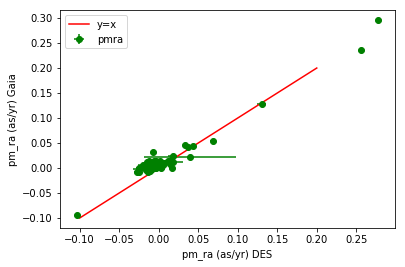

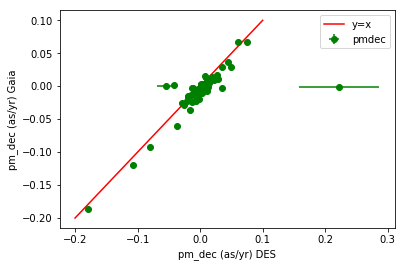

mu RA error (Gaia): median: 6.48069106973e-05 mean: 8.76119765823e-05
mu Dec error (Gaia): median: 7.41899055297e-05 mean: 9.80873203369e-05
mu RA difference: median: 0.00764057203744 mean: 0.00851362569667
mu Dec difference: median: -0.00500392805854 mean: -0.00811679936724


In [124]:
cool_full = getGaiaMatches(z55, tree_c)
z55['MU_RA_NEW'] = Table.Column(data=[0]*len(z55), dtype ='f8')
z55['MU_DEC_NEW'] = Table.Column(data=[0]*len(z55), dtype ='f8')
calcPMs(z55, fin2)
hjkl = comparePMnew(z55, gal, g2)

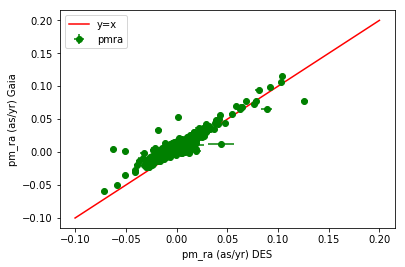

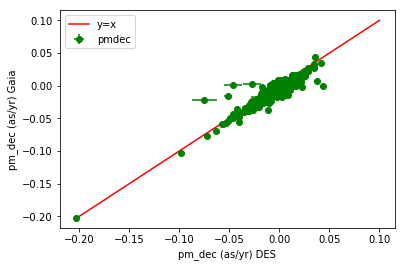

mu RA error (Gaia): median: 0.000549903114933 mean: 0.000779694402915
mu Dec error (Gaia): median: 0.000636663347664 mean: 0.000950578253095
mu RA difference: median: 0.00641379082302 mean: 0.0066904965107
mu Dec difference: median: -0.00402497399127 mean: -0.00401175611161


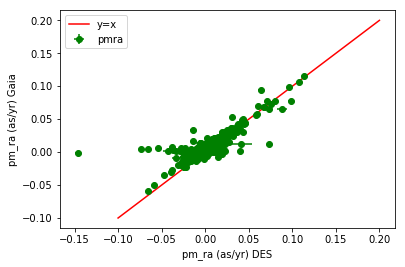

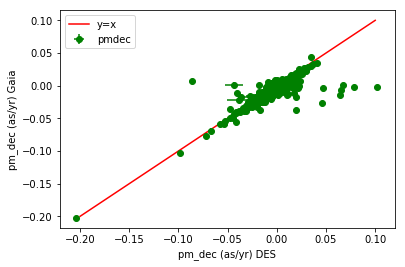

mu RA error (Gaia): median: 0.000549903114933 mean: 0.000779694402915
mu Dec error (Gaia): median: 0.000636663347664 mean: 0.000950578253095
mu RA difference: median: 0.00419293717482 mean: 0.00455460851338
mu Dec difference: median: -0.00326871174446 mean: -0.00379061467625


In [125]:
some = comparePMnew(tiles[-2], cool_c, g2)
some2 = comparePM(tiles[-2], cool_c, g2)

In [126]:
src1 = fin[np.where(fin['MATCH_ID'] == 1021)]['MATCH_ID','CCDNUM', 'BAND', 'EXPNUM', 'VERSION', 'NEW_RA', 'NEW_DEC', 'MJD_OBS']

In [127]:
tiles[-2][cool_c][np.where(tiles[-2][cool_c]['VEL'] > 0.2)]

MATCH_ID,COADD_ID,SPREAD_MODEL,SPREADERR_MODEL,CHI2_RED,RA_0,RA_ERR,DEC_0,DEC_ERR,MU_RA,MU_RA_ERR,MU_DEC,MU_DEC_ERR,COV_MU_RA_MU_DEC,COV_RA_MU_RA,COV_RA_DEC,COV_RA_MU_DEC,COV_DEC_MU_RA,COV_DEC_MU_DEC,RA,DEC,N,CHI_NULL,VEL,SIGMA_VEL,SIMBAD_MATCH,SIMBAD_#,MATCH_DIST,GAIA_MATCH,GAIA_MATCH_DIST,MU_RA_NEW,MU_DEC_NEW
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str50,int32,float64,str50,float64,float64,float64
2348.0,344111137.0,0.00494525767863,1.35945783768e-05,11.8516268613,46.2976991823,0.000450900162352,-18.111439829,0.000206259980209,0.107177277616,3.44793927637e-06,-0.203826958939,1.56953735011e-06,1.25014193742e-07,-3.93290256007e-05,2.11247693036e-05,-1.63441692451e-06,-1.61216558856e-06,-1.79492559258e-05,46.29798,-18.112072,22.0,30899.9451155,0.227864538174,0.00135829226719,,0,0.0,Gaia DR2 5152685394727074048,4.47441341259e-09,0.102539446038,-0.202919763466


In [128]:
g2[np.where(g2['designation'] == 'Gaia DR2 5152685394727074048')]

designation,source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,phot_g_mean_mag,bp_rp,radial_velocity,radial_velocity_error,teff_val,a_g_val
str28,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
Gaia DR2 5152685394727074048,5152685394727074048,46.2980437768,0.047630669927,-18.1120921726,0.0479494516833,5.47922985162,0.0549417948054,106.798871495,0.103887338663,-202.467675413,0.108916322359,15.923773,1.8821268,--,--,3915.5,0.1385


In [129]:
fin2[np.where(fin2['MATCH_ID'] == 2348)]['MATCH_ID','CCDNUM', 'BAND', 'EXPNUM', 'VERSION'][:15]

MATCH_ID,CCDNUM,BAND,EXPNUM,VERSION
float64,int16,str5,int64,str30
2348.0,4,Y,479565,y4a1_v1.5
2348.0,62,g,380060,y4a1_v1.5
2348.0,28,i,621171,y4a1_v1.5
2348.0,4,g,493258,y4a1_v1.5
2348.0,46,r,387438,y4a1_v1.5
2348.0,16959,N/A,999999,COADD
2348.0,4,i,493257,y4a1_v1.5
2348.0,16,g,374306,y4a1_v1.5
2348.0,62,i,366114,y4a1_v1.5


In [130]:
tiles[-1][cool_b][np.where(tiles[-1][cool_b]['VEL'] > 0.2)]

MATCH_ID,COADD_ID,SPREAD_MODEL,SPREADERR_MODEL,CHI2_RED,RA_0,RA_ERR,DEC_0,DEC_ERR,MU_RA,MU_RA_ERR,MU_DEC,MU_DEC_ERR,COV_MU_RA_MU_DEC,COV_RA_MU_RA,COV_RA_DEC,COV_RA_MU_DEC,COV_DEC_MU_RA,COV_DEC_MU_DEC,RA,DEC,N,CHI_NULL,VEL,SIGMA_VEL,SIMBAD_MATCH,SIMBAD_#,MATCH_DIST,GAIA_MATCH,GAIA_MATCH_DIST
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str50,int32,float64,str50,float64
354.0,69137813.0,-0.00049346749438,0.000409043685067,1.57125657421,331.664572118,1.07797075189,1.91106429324,0.962737632381,0.164411549949,0.0113586153863,0.202171061869,0.010144342302,0.00112476368333,-0.110652957722,0.107061716999,-0.0109736419163,-0.0109733122403,-0.0988240899741,331.665048,1.91166,9.0,5.8239691378,0.260526804564,0.108297806613,,0,0.0,Gaia DR2 2682415300661660672,3.64666686627e-09
2597.0,69118780.0,0.0,0.0,81.229570378,331.654159069,39706.8517335,2.52842712402,75867.7230283,13.1180259981,421.484092526,-43.1131286547,805.333958128,32.6538039352,-4090.94198966,3076.15644109,-316.935646357,-316.935910802,-7816.57557093,331.689524,2.412164,3.0,2.83403294455,45.0612876508,27.4715687131,,0,0.0,Gaia DR2 2683210866044211968,1.6549402921e-10
3597.0,69124525.0,0.0,0.0,106.918521125,331.35371089,39684.3604679,2.38888549805,75850.8767107,-5.9827640187,421.245351856,-50.6321484223,805.155135544,32.7234752957,-4088.62475431,3082.72027428,-317.611894875,-317.611895212,-7814.83991485,331.337574,2.25243,3.0,3.22068713172,50.9838467589,28.4165073842,,0,0.0,Gaia DR2 2683213065067390720,1.86208736336e-09
7545.0,69137989.0,0.0,0.0,341.70091575,331.511214852,48188.7591486,1.69577789307,84429.5701399,20.7201652229,511.516037949,77.9088009149,896.214402309,20.3400183588,-4964.80846992,1916.06014989,-197.415034528,-197.415038906,-8698.67787131,331.567066,1.905895,3.0,7.47550600802,80.61409078,29.6804194264,,0,0.0,Gaia DR2 2682415850417800832,4.51654233299e-09
7662.0,69137022.0,0.0,0.0,156.106409637,331.456879139,39688.2232381,1.92105102539,75849.9686862,7.08689043531,421.286356099,0.455549731851,805.145500407,32.6648282757,-4089.02273673,3077.19509208,-317.042654878,-317.042512396,-7814.74637907,331.476022,1.922311,3.0,0.119226856618,7.09753677837,20.6652411705,,0,0.0,Gaia DR2 2682417568404730240,1.38030594188e-09
9263.0,69140429.0,0.0,0.0,0.463031365761,331.621580246,0.848866686822,1.84961430961,1.3265769085,0.159443729106,0.00894893399414,-0.189241647581,0.0139592792596,0.00206561901546,-0.0871568426699,0.195323605104,-0.0200862997764,-0.0200862800477,-0.136079787514,331.622046,1.849149,3.0,6.63064681933,0.247402977751,0.0992217525839,,0,0.0,Gaia DR2 2682401449392318976,3.51786328496e-09


In [131]:
#last
g3[np.where(g3['designation'] == 'Gaia DR2 2682401449392318976')]

designation,source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,phot_g_mean_mag,bp_rp,teff_val,a_g_val
str28,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
Gaia DR2 2682401449392318976,2682401449392318976,331.622010824,0.466252525612,1.84910124524,0.664013489268,1.87462609899,0.321610542153,5.46116812032,0.665086411521,3.4932433243,1.03839673418,18.70259,2.6022415,--,--


In [132]:
tiles[0][np.where(tiles[0]['VEL'] > 0.5)]

MATCH_ID,COADD_ID,SPREAD_MODEL,SPREADERR_MODEL,CHI2_RED,RA_0,RA_ERR,DEC_0,DEC_ERR,MU_RA,MU_RA_ERR,MU_DEC,MU_DEC_ERR,COV_MU_RA_MU_DEC,COV_RA_MU_RA,COV_RA_DEC,COV_RA_MU_DEC,COV_DEC_MU_RA,COV_DEC_MU_DEC,RA,DEC,N,CHI_NULL,VEL,SIGMA_VEL,SIMBAD_MATCH,SIMBAD_#,MATCH_DIST
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str50,int32,float64
16044.0,254528679.0,-0.000134703994263,0.00346354977228,1.91509563005,27.2220219412,16.9597229367,-4.15212269765,17.0833028871,1.40827758364,0.144295901854,0.356902359027,0.145343198564,0.000433418385447,-1.56433698169,0.0509753609678,-0.00470033816556,-0.0047003512967,-1.57571347327,27.226244,-4.150995,7.0,14.6000571692,1.44921827442,0.380218783592,,0,0.0
16062.0,254522390.0,0.000435455265688,0.00911587662995,2.63776907604,27.0588319696,100.846827857,-4.02869942371,101.786856389,2.13728454144,0.866794987083,-0.0754392352491,0.874804168143,0.00311086890256,-9.34944803482,0.363335702654,-0.0336195628558,-0.0336196182429,-9.43621716118,27.065261,-4.028935,3.0,5.27786774022,2.1333369215,0.930905541062,,0,0.0
16096.0,254533267.0,0.00554030993953,0.00506526092067,2.06014640299,27.0914471993,109.209524416,-4.24073170079,110.928470708,-1.17827693319,0.934745915803,1.39686791943,0.949392444153,0.00368065314446,-10.1035577261,0.432395015468,-0.039893434126,-0.0398941243915,-10.2622291201,27.087879,-4.236503,3.0,3.5542136933,1.82537665726,0.969379548597,,0,0.0
16229.0,254539693.0,0.00893594324589,0.00369468308054,0.810893909778,27.2770812214,39.3326418517,-4.36744342605,39.6579955687,0.413893996108,0.334756813986,1.96126563119,0.337512863126,0.000991947257748,-3.62857617985,0.116273657045,-0.0107393977807,-0.0107397813577,-3.65852096476,27.278301,-4.36149,5.0,11.89437833,2.0042156488,0.581201997679,,0,0.0
16352.0,254808280.0,-0.00534077081829,0.0041434224695,1.51767530293,27.2921781797,16.7090078155,-4.51779690664,16.8204146125,0.0394176269682,0.141992825995,0.643885592057,0.142925410198,0.000417584634232,-1.54027783498,0.049143344878,-0.00452995714048,-0.00453019192075,-1.55047096987,27.292254,-4.515807,4.0,2.91065739603,0.645083539695,0.378117348945,,0,0.0
16533.0,254525534.0,-0.00262953387573,0.00523939635605,0.27618625424,27.5756966533,72.8667224001,-4.09407401457,71.9131182193,-0.035118153189,0.622509518079,2.17966289908,0.614388834455,0.000697574931001,-6.73496857013,0.0808584013283,-0.00751031218807,-0.00751031203132,-6.64696912689,27.575536,-4.087496,3.0,7.73504478266,2.17994435072,0.783816634114,,0,0.0
17802.0,254518904.0,0.00928594637662,0.00368983391672,4.6404365912,27.4857769209,80.1471477328,-3.96563240071,80.4195830221,2.65419009529,0.678899245043,2.94554202459,0.681205989071,0.00223682864167,-7.37637624301,0.265242742934,-0.0243576622355,-0.0243576289347,-7.40144474581,27.493783,-3.956741,3.0,23.0378649,3.96073222456,0.826074589704,,0,0.0
18002.0,254524266.0,0.00550149939954,0.00381127884611,0.657051980806,27.4341130637,45.3467355217,-4.0707262936,45.5062725992,-2.33467250669,0.382935709583,1.89240369469,0.384281589705,0.00187850993193,-4.16708335866,0.223030615075,-0.0204685186623,-0.0204685078048,-4.18173650925,27.427021,-4.06497,4.0,23.666524348,3.00074947694,0.617763871735,,0,0.0
18141.0,254523616.0,0.00347407627851,0.00388185563497,0.458470900253,27.5878760314,79.5682136085,-4.06057894055,79.8414720084,-0.0668139731559,0.675417139299,2.53797533928,0.677732359287,0.00224633204176,-7.330827911,0.266163781601,-0.0244517329289,-0.0244516533489,-7.35598038464,27.58766,-4.052899,3.0,9.51260059125,2.53885025754,0.823172441478,,0,0.0


In [133]:
#wget -i [TEXT-FILE-NAME]
#The above command shall facilitate downloading of multiple files in a hassle-free manner.

In [134]:
src1#src1[np.where(src1['BAND'] == 'g')]

MATCH_ID,CCDNUM,BAND,EXPNUM,VERSION,NEW_RA,NEW_DEC,MJD_OBS
float64,int16,str5,int64,str30,float64,float64,float64
1021.0,22,g,247172,y4a1_v1.5,23.8922541644,-3.95579067332,56592.1040673
1021.0,56,r,567919,y4a1_v1.5,23.8926355516,-3.95593431346,57626.3514093
1021.0,28,g,596511,y4a1_v1.5,23.8926651591,-3.95594611895,57718.1439384
1021.0,56,i,503041,y4a1_v1.5,23.8925440614,-3.95589726083,57374.1295569
1021.0,28,z,600485,y4a1_v1.5,23.8926639866,-3.95594380664,57729.0933571
1021.0,56,g,568776,y4a1_v1.5,23.8926275862,-3.95593560043,57629.3461645
1021.0,22,r,258864,y4a1_v1.5,23.8922786341,-3.95579268987,56627.17666
1021.0,22,i,370652,y4a1_v1.5,23.8923979677,-3.95584069198,56953.232467
1021.0,22,z,398228,y4a1_v1.5,23.8924219096,-3.95585538202,57037.0471445


In [3]:
# function to write sql query
def ImageQuery(match_id, final):
    trunc = final[np.where(final['MATCH_ID'] == match_id)]
    trunc2 = trunc[np.where(trunc['VERSION'] != 'COADD')]
    ccdnum = []
    expnum = []
    for iden in trunc2:
        ccdnum.append(iden['CCDNUM'])
        expnum.append(iden['EXPNUM'])
    pre = "select 'https://desar2.cosmology.illinois.edu/DESFiles/desarchive/' || a.path || '/' || a.filename || a.compression as url  from y4a1_file_archive_info a inner join y4a1_image i on i.filename=a.filename where "
    post = "and filetype='red_immask'; > exposures.csv"
    qry = "("
    for i in range(len(trunc2)):
        seg = "(expnum={0} and ccdnum={1})".format(expnum[i],ccdnum[i])
        qry += seg
        if i != len(trunc2) - 1:
            qry += " or "
        else:
            qry += ") "
    print(pre + qry + post)
    

In [136]:
ImageQuery(2348, fin2)

select 'https://desar2.cosmology.illinois.edu/DESFiles/desarchive/' || a.path || '/' || a.filename || a.compression as url  from y4a1_file_archive_info a inner join y4a1_image i on i.filename=a.filename where ((expnum=479565 and ccdnum=4) or (expnum=380060 and ccdnum=62) or (expnum=621171 and ccdnum=28) or (expnum=493258 and ccdnum=4) or (expnum=387438 and ccdnum=46) or (expnum=493257 and ccdnum=4) or (expnum=374306 and ccdnum=16) or (expnum=366114 and ccdnum=62) or (expnum=607553 and ccdnum=28) or (expnum=264611 and ccdnum=16) or (expnum=348987 and ccdnum=46) or (expnum=383247 and ccdnum=16) or (expnum=493256 and ccdnum=4) or (expnum=372661 and ccdnum=16) or (expnum=502720 and ccdnum=56) or (expnum=372659 and ccdnum=46) or (expnum=495873 and ccdnum=56) or (expnum=372658 and ccdnum=62) or (expnum=621910 and ccdnum=28) or (expnum=384167 and ccdnum=62) or (expnum=502722 and ccdnum=56) or (expnum=621911 and ccdnum=28)) and filetype='red_immask'; > exposures.csv


In [4]:
def GenerateTextfile(filename, csv):
    csv = Table.read(csv)
    urls = list(csv['URL'])
    text = open(filename, mode = 'w')
    for i in range(len(urls)):
        text.write(urls[i] + "\n")
    text.close()
GenerateTextfile('src-url.txt', 'exposures.csv')

In [138]:
fin3 = Table.read('zone009/DES2205+0209_final.fits')

In [7]:
GenerateTextfile('src12-url.txt', 'exposures-3.csv')

In [140]:
src2 = fin2[np.where(fin2['MATCH_ID'] == 2348)]['MATCH_ID','CCDNUM', 'BAND', 'EXPNUM', 'VERSION', 'NEW_RA', 'NEW_DEC', 'MJD_OBS']

In [141]:
src2[:15]

MATCH_ID,CCDNUM,BAND,EXPNUM,VERSION,NEW_RA,NEW_DEC,MJD_OBS
float64,int16,str5,int64,str30,float64,float64,float64
2348.0,4,Y,479565,y4a1_v1.5,46.298046595,-18.1121061639,57293.3805191
2348.0,62,g,380060,y4a1_v1.5,46.2980243697,-18.1120551211,56982.2846898
2348.0,28,i,621171,y4a1_v1.5,46.2980862712,-18.1121831722,57800.0316027
2348.0,4,g,493258,y4a1_v1.5,46.2980610908,-18.1121151935,57341.3040607
2348.0,46,r,387438,y4a1_v1.5,46.2980242875,-18.112070016,57005.1921118
2348.0,16959,N/A,999999,COADD,46.2979803043,-18.112071978,1e+20
2348.0,4,i,493257,y4a1_v1.5,46.298048747,-18.1121159266,57341.3026789
2348.0,16,g,374306,y4a1_v1.5,46.297967,-18.112029,56963.3209887
2348.0,62,i,366114,y4a1_v1.5,46.2980219544,-18.1120500131,56936.3770506


In [142]:
GenerateTextfile('images/src3/src3-url.txt', 'exposures2.csv')

In [143]:
src3 = fin3[np.where(fin3['MATCH_ID'] == 354)]['MATCH_ID','CCDNUM', 'BAND', 'EXPNUM', 'VERSION', 'NEW_RA', 'NEW_DEC', 'MJD_OBS']

In [144]:
src3

MATCH_ID,CCDNUM,BAND,EXPNUM,VERSION,NEW_RA,NEW_DEC,MJD_OBS
float64,int16,str5,int64,str30,float64,float64,float64
354.0,21,g,232250,y4a1_v1.5,331.665012661,1.9115991348,56545.0600116
354.0,25,g,230841,y4a1_v1.5,331.665021524,1.91160363953,56540.0762292
354.0,25,Y,236446,y4a1_v1.5,331.665040749,1.91158824763,56555.0676408
354.0,25,i,233482,y4a1_v1.5,331.665017022,1.91161230725,56548.1315448
354.0,16959,N/A,999999,COADD,331.66504791,1.9116596469,1e+20
354.0,25,g,242444,y4a1_v1.5,331.665026879,1.91162275552,56575.1169343
354.0,25,g,231846,y4a1_v1.5,331.665030937,1.91161580758,56544.0728673
354.0,25,z,233492,y4a1_v1.5,331.665012236,1.91160799684,56548.1454294
354.0,25,r,242423,y4a1_v1.5,331.665015608,1.91160993094,56575.0858493


In [145]:
GenerateTextfile('images/src4/src4-url.txt', 'exposures3.csv')

In [146]:
src4 = fin3[np.where(fin3['MATCH_ID'] == 7545)]['MATCH_ID','CCDNUM', 'BAND', 'EXPNUM', 'VERSION', 'NEW_RA', 'NEW_DEC', 'MJD_OBS']

In [147]:
src4

MATCH_ID,CCDNUM,BAND,EXPNUM,VERSION,NEW_RA,NEW_DEC,MJD_OBS
float64,int16,str5,int64,str30,float64,float64,float64
7545.0,21,g,232250,y4a1_v1.5,331.567030151,1.90582342555,56545.0600116
7545.0,21,Y,232251,y4a1_v1.5,331.567041912,1.9058450475,56545.0613752
7545.0,16959,N/A,999999,COADD,331.567065781,1.90589488545,1e+20
7545.0,21,i,232352,y4a1_v1.5,331.567034863,1.90583734214,56545.2054844


In [148]:
tiles[-1][np.where(tiles[-1]['MATCH_ID'] == 7545)]

MATCH_ID,COADD_ID,SPREAD_MODEL,SPREADERR_MODEL,CHI2_RED,RA_0,RA_ERR,DEC_0,DEC_ERR,MU_RA,MU_RA_ERR,MU_DEC,MU_DEC_ERR,COV_MU_RA_MU_DEC,COV_RA_MU_RA,COV_RA_DEC,COV_RA_MU_DEC,COV_DEC_MU_RA,COV_DEC_MU_DEC,RA,DEC,N,CHI_NULL,VEL,SIGMA_VEL,SIMBAD_MATCH,SIMBAD_#,MATCH_DIST,GAIA_MATCH,GAIA_MATCH_DIST
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str50,int32,float64,str50,float64
7545.0,69137989.0,0.0,0.0,341.70091575,331.511214852,48188.7591486,1.69577789307,84429.5701399,20.7201652229,511.516037949,77.9088009149,896.214402309,20.3400183588,-4964.80846992,1916.06014989,-197.415034528,-197.415038906,-8698.67787131,331.567066,1.905895,3.0,7.47550600802,80.61409078,29.6804194264,,0,0.0,Gaia DR2 2682415850417800832,4.51654233299e-09


In [149]:
ImageQuery(327, fin2)

select 'https://desar2.cosmology.illinois.edu/DESFiles/desarchive/' || a.path || '/' || a.filename || a.compression as url  from y4a1_file_archive_info a inner join y4a1_image i on i.filename=a.filename where ((expnum=264611 and ccdnum=3) or (expnum=491166 and ccdnum=52) or (expnum=589889 and ccdnum=48) or (expnum=490396 and ccdnum=52) or (expnum=488910 and ccdnum=52) or (expnum=372661 and ccdnum=3) or (expnum=502720 and ccdnum=34) or (expnum=383247 and ccdnum=3) or (expnum=495872 and ccdnum=34) or (expnum=386760 and ccdnum=27) or (expnum=384167 and ccdnum=49) or (expnum=589888 and ccdnum=48) or (expnum=621911 and ccdnum=7) or (expnum=387438 and ccdnum=27) or (expnum=387836 and ccdnum=3) or (expnum=607553 and ccdnum=7) or (expnum=502722 and ccdnum=34) or (expnum=594328 and ccdnum=48) or (expnum=372659 and ccdnum=27) or (expnum=479548 and ccdnum=52) or (expnum=618523 and ccdnum=7) or (expnum=502721 and ccdnum=34) or (expnum=393089 and ccdnum=49) or (expnum=374306 and ccdnum=3) or (expnu

In [150]:
ImageQuery(2607, fin2)

select 'https://desar2.cosmology.illinois.edu/DESFiles/desarchive/' || a.path || '/' || a.filename || a.compression as url  from y4a1_file_archive_info a inner join y4a1_image i on i.filename=a.filename where ((expnum=383247 and ccdnum=20) or (expnum=374306 and ccdnum=20) or (expnum=493254 and ccdnum=44) or (expnum=386351 and ccdnum=18) or (expnum=621171 and ccdnum=27) or (expnum=493253 and ccdnum=44) or (expnum=383246 and ccdnum=18) or (expnum=372661 and ccdnum=20) or (expnum=387836 and ccdnum=20) or (expnum=389531 and ccdnum=18) or (expnum=264611 and ccdnum=20) or (expnum=489564 and ccdnum=23) or (expnum=479547 and ccdnum=44) or (expnum=493255 and ccdnum=44) or (expnum=502716 and ccdnum=44)) and filetype='red_immask'; > exposures.csv


In [151]:
GenerateTextfile('src5-url.txt', 'exposures4.csv')

In [152]:
GenerateTextfile('src6-url.txt', 'exposures5.csv')

In [153]:
src5 = fin2[np.where(fin2['MATCH_ID'] == 327)]['MATCH_ID','CCDNUM', 'BAND', 'EXPNUM', 'VERSION', 'NEW_RA', 'NEW_DEC', 'MJD_OBS']

In [154]:
src5#[np.where(src5['BAND'] == 'r')]
# outlier exposure num = 374306

MATCH_ID,CCDNUM,BAND,EXPNUM,VERSION,NEW_RA,NEW_DEC,MJD_OBS
float64,int16,str5,int64,str30,float64,float64,float64
327.0,3,Y,264611,y4a1_v1.5,46.569610052,-17.5072703042,56641.2038058
327.0,52,g,491166,y4a1_v1.5,46.5696058646,-17.5072557915,57334.3066495
327.0,48,g,589889,y4a1_v1.5,46.5696040731,-17.5072600069,57697.3136216
327.0,52,i,490396,y4a1_v1.5,46.5696051508,-17.5072607628,57332.3208899
327.0,52,z,488910,y4a1_v1.5,46.5696054793,-17.5072615534,57327.3312004
327.0,3,i,372661,y4a1_v1.5,46.5696071487,-17.5072609974,56959.3520248
327.0,34,r,502720,y4a1_v1.5,46.5696072052,-17.5072593283,57373.2130237
327.0,3,r,383247,y4a1_v1.5,46.5696080645,-17.5072582939,56992.2584276
327.0,34,z,495872,y4a1_v1.5,46.5696093497,-17.5072622602,57348.2725024


In [155]:
tiles[-2][cool_c][np.where(tiles[-2][cool_c]['MU_DEC'] > 0.05)]

MATCH_ID,COADD_ID,SPREAD_MODEL,SPREADERR_MODEL,CHI2_RED,RA_0,RA_ERR,DEC_0,DEC_ERR,MU_RA,MU_RA_ERR,MU_DEC,MU_DEC_ERR,COV_MU_RA_MU_DEC,COV_RA_MU_RA,COV_RA_DEC,COV_RA_MU_DEC,COV_DEC_MU_RA,COV_DEC_MU_DEC,RA,DEC,N,CHI_NULL,VEL,SIGMA_VEL,SIMBAD_MATCH,SIMBAD_#,MATCH_DIST,GAIA_MATCH,GAIA_MATCH_DIST,MU_RA_NEW,MU_DEC_NEW
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str50,int32,float64,str50,float64,float64,float64
327.0,343950072.0,-0.000763258372899,1.66918107425e-05,566.299832429,46.5698294349,0.000251221515237,-17.5075332352,0.000121766099064,-0.0653144202634,1.80048204134e-06,0.0789228243464,8.83734277241e-07,8.07035497269e-09,-2.12168216406e-05,3.48917434747e-06,-1.8479101596e-07,-2.00034595883e-07,-1.0346420511e-05,46.569582,-17.507241,32.0,9470.31533956,0.100542180779,0.00110803862393,,0,0.0,Gaia DR2 5152741572899281920,9.69522162437e-10,-0.00269304043923,0.00127610629046
1331.0,343968115.0,-0.000274141028058,2.17700035137e-05,717.826743002,45.8878923745,0.000254677537866,-17.8369561599,0.000125183073011,-0.0544127971484,1.8323270277e-06,0.0646295817737,9.12821605738e-07,-1.89432689976e-08,-2.15343901838e-05,3.25957926213e-07,9.7849367272e-08,9.9121141125e-08,-1.06573012123e-05,45.887663,-17.836702,28.0,6113.39930719,0.0828248097768,0.00113619281675,,0,0.0,Gaia DR2 5152380108451564800,2.1013284344e-09,0.00177637592037,-0.00496256956917
2607.0,344114255.0,0.00155430077575,4.45595178462e-05,741.089331405,45.8833054067,0.00104591359855,-18.1708756792,0.00059008289816,0.0124457448824,8.03307603132e-06,0.102150755933,4.53629795617e-06,-7.79114821073e-08,-9.15131111238e-05,-1.58245493471e-06,5.06925455574e-07,5.53224560516e-07,-5.16646274374e-05,45.883299,-18.170509,15.0,2325.39083097,0.102832923433,0.00213652470221,,0,0.0,Gaia DR2 5152318290986898048,3.26834732603e-09,-0.00145148711227,0.00707517494625
2820.0,344114389.0,0.00604342389852,0.000205919655855,717.172024218,46.4457306485,0.000713488943472,-18.174665157,0.00050840620378,-0.00286964708051,5.05406385208e-06,0.0667761143042,3.60129152112e-06,1.71809189085e-07,-5.98298886793e-05,2.40721980558e-05,-2.02621905918e-06,-2.02627245949e-06,-4.26333845602e-05,46.445674,-18.174448,28.0,1245.44750158,0.066831752606,0.00189465108973,,0,0.0,Gaia DR2 5152681099758928000,1.54826095387e-08,-0.00172855597513,0.00184416587411
4816.0,343951064.0,-6.66863707011e-05,1.8770351744e-05,382.777989069,46.2760970563,0.000436259021557,-17.4862843219,0.000235479698908,0.0138965569161,3.16020935958e-06,0.0650984591644,1.7037176184e-06,3.08422870731e-07,-3.70614492861e-05,4.55715498151e-05,-3.73781844531e-06,-3.748619615e-06,-1.99891957017e-05,46.276117,-17.486034,23.0,2488.82616171,0.0664340914525,0.0013719647394,,0,0.0,Gaia DR2 5152767682005002496,1.72730707192e-09,-0.00653472202559,0.00158555312062


In [156]:
g2[np.where(g2['designation'] == 'Gaia DR2 5152741572899281920')]

designation,source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,phot_g_mean_mag,bp_rp,radial_velocity,radial_velocity_error,teff_val,a_g_val
str28,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
Gaia DR2 5152741572899281920,5152741572899281920,46.5696049175,0.0568003952035,-17.5072620786,0.0572350511228,0.341842898601,0.077622394618,4.56269187004,0.0922298965256,-1.56469412103,0.109180332506,16.049347,0.8785238,--,--,5972.925,--


In [157]:
src6 = fin2[np.where(fin2['MATCH_ID'] == 2607)]['MATCH_ID','CCDNUM', 'BAND', 'EXPNUM', 'VERSION', 'NEW_RA', 'NEW_DEC', 'MJD_OBS']

In [158]:
src6

MATCH_ID,CCDNUM,BAND,EXPNUM,VERSION,NEW_RA,NEW_DEC,MJD_OBS
float64,int16,str5,int64,str30,float64,float64,float64
2607.0,20,r,383247,y4a1_v1.5,45.8833545449,-18.170526341,56992.2584276
2607.0,20,g,374306,y4a1_v1.5,45.883319,-18.170506,56963.3209887
2607.0,44,i,493254,y4a1_v1.5,45.8833526748,-18.1705264953,57341.2985469
2607.0,18,z,386351,y4a1_v1.5,45.8833500061,-18.1708417244,57002.2110614
2607.0,27,i,621171,y4a1_v1.5,45.8833515383,-18.1705269802,57800.0316027
2607.0,16959,N/A,999999,COADD,45.8832989025,-18.1705087505,1e+20
2607.0,44,r,493253,y4a1_v1.5,45.8833474985,-18.1705275777,57341.2971498
2607.0,18,g,383246,y4a1_v1.5,45.883413339,-18.1710333827,56992.2570144
2607.0,20,i,372661,y4a1_v1.5,45.8833518505,-18.1705283081,56959.3520248


## DES unmatched high PM stars

In [159]:
s = tiles[33][uncool]
s2 = s[np.where(s['N'] > 15)]
s2[np.where(s2['VEL'] > 0.1)]


MATCH_ID,COADD_ID,SPREAD_MODEL,SPREADERR_MODEL,CHI2_RED,RA_0,RA_ERR,DEC_0,DEC_ERR,MU_RA,MU_RA_ERR,MU_DEC,MU_DEC_ERR,COV_MU_RA_MU_DEC,COV_RA_MU_RA,COV_RA_DEC,COV_RA_MU_DEC,COV_DEC_MU_RA,COV_DEC_MU_DEC,RA,DEC,N,CHI_NULL,VEL,SIGMA_VEL,SIMBAD_MATCH,SIMBAD_#,MATCH_DIST,GAIA_MATCH,GAIA_MATCH_DIST
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str50,int32,float64,str50,float64
1529.0,233015070.0,0.00105474796146,0.00032203621231,0.663221520172,23.5331299926,0.00036571740513,-4.19534073498,0.000336946079103,0.139112908071,2.6064321188e-06,0.070805057134,2.43304856491e-06,8.22062053648e-08,-3.07508582285e-05,1.157657247e-05,-9.65323391206e-07,-9.70985873452e-07,-2.85108578535e-05,23.533512,-4.195067,37.0,9239.86424921,0.155763273942,0.001623937901,,0,0.0,Gaia DR2 2480870554390630272,6.3361002489e-09
3918.0,233031814.0,0.00770432222635,0.00145797384903,9.69119925679,23.5832656186,0.00321942056171,-4.55911403571,0.0030165871728,-0.0365951382894,2.5064995696e-05,-0.0973608167088,2.37544853519e-05,-1.56655124888e-06,-0.000282450748961,-0.000241610964487,1.94646008133e-05,1.94602482913e-05,-0.000266141172204,23.583094,-4.559399,30.0,473.17398553,0.103970525893,0.00478397453664,,0,0.0,,0.0
8488.0,233007231.0,0.00748145161197,0.00308659928851,45.5352124083,23.5113094759,0.0168906027051,-4.01701449456,0.0168252648969,-0.127259017632,0.000121250812411,-0.111808208133,0.000120827366085,9.37277658764e-08,-0.00142449837712,1.22732383231e-05,-1.06301647034e-06,-1.0631659714e-06,-0.00141924456515,23.510685,-4.017468,23.0,236.845309554,0.169163946252,0.0110072161476,,0,0.0,,0.0


In [160]:
#two coadds
fin[np.where(fin['MATCH_ID'] == 20390)]

RA,DEC,ERRAWIN_WORLD,XWIN_IMAGE,YWIN_IMAGE,SPREAD_MODEL,SPREADERR_MODEL,FLUX_AUTO,FLUXERR_AUTO,EXPNUM,IMAFLAGS_ISO,ERRBWIN_WORLD,A_IMAGE,ERRA_IMAGE,B_IMAGE,ERRB_IMAGE,THETA_IMAGE,ERRTHETAWIN_J2000,CHI2_MODEL,CHI2_PSF,CCDNUM,BAND,MJD_OBS,EXPTIME,MAG_ZERO,VERSION,X_GNOM,Y_GNOM,MAG_AUTO_G,MAG_AUTO_R,MAG_AUTO_I,MAG_AUTO_Z,MAG_AUTO_Y,COADD_OBJECT_ID,ALPHAWIN_J2000,DELTAWIN_J2000,FLUX_AUTO_G,FLUX_AUTO_R,FLUX_AUTO_I,FLUX_AUTO_Z,FLUX_AUTO_Y,MAGERR_AUTO_G,MAGERR_AUTO_R,MAGERR_AUTO_I,MAGERR_AUTO_Z,MAGERR_AUTO_Y,FLUXERR_AUTO_G,FLUXERR_AUTO_R,FLUXERR_AUTO_I,FLUXERR_AUTO_Y,SPREAD_MODEL_I,SPREADERR_MODEL_I,MATCH_ID,COLOR,NEW_RA,NEW_DEC
float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,int16,str5,float64,float64,float64,str30,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
23.948119,-4.599913,3.31629998982e-05,1462.51098633,3919.52197266,0.0113517995924,0.0053383698687,6570.99023438,858.643981934,590596,0,3.30713010044e-05,1.27030003071,-9999.0,0.815982997417,-9999.0,-38.962600708,50.4469985962,-9999.0,2.08509997462e-11,15,i,57699.1445245,90.0,31.6346263885,y4a1_v1.5,-2.28880973518,0.376884579133,1e+20,1e+20,1e+20,1e+20,1e+20,999999,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,20390.0,1.42317390442,23.9481416284,-4.59989834423
23.948116,-4.599888,2.62811008724e-05,943.332946777,3068.58007812,0.00166893994901,0.00555654987693,3735.82006836,625.596008301,503040,0,2.62090998149e-05,1.02348005772,-9999.0,0.633225023746,-9999.0,34.5587005615,22.6000995636,-9999.0,0.0,8,i,57374.1281439,90.0,31.6148147583,y4a1_v1.5,-2.28884022886,0.376889657114,1e+20,1e+20,1e+20,1e+20,1e+20,999999,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,20390.0,1.42317390442,23.9481111034,-4.5998931727
23.948103,-4.599903,3.10065006488e-05,1259.41711426,3792.5925293,0.0111036999151,0.00445435987785,7603.64990234,990.822998047,372596,0,3.09969000227e-05,1.59719002247,-9999.0,0.901005029678,-9999.0,-48.207901001,-62.2778015137,-9999.0,2.91410992559e-11,16,i,56959.2606197,90.0,31.6511001587,y4a1_v1.5,-2.28881655764,0.376881063683,1e+20,1e+20,1e+20,1e+20,1e+20,999999,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,20390.0,1.42317390442,23.9481347827,-4.59990183482
23.948105,-4.599867,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,999999,999999,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,16959,N/A,1e+20,1e+20,1e+20,COADD,-2.28884642936,0.376915538638,23.4952487946,22.6706562042,22.0720748901,22.1861076355,21.4368343353,233033772,23.9481049832,-4.59986729318,399.85345459,854.549682617,1483.09973145,1335.23193359,2662.35864258,0.158416643739,0.125830635428,0.100754640996,0.201825007796,0.251877844334,58.3272972107,99.0133743286,137.595932007,617.485412598,0.00830556731671,0.00279178027995,20390.0,1.42317390442,23.9481049832,-4.59986729318
23.948083,-4.599894,3.26822009811e-05,923.635986328,3288.48413086,0.00978793017566,0.00497360015288,5910.85986328,803.508972168,488828,0,3.25489017996e-05,1.40690994263,-9999.0,0.767466008663,-9999.0,-56.4367980957,23.6923007965,-9999.0,2.70233002642e-11,26,i,57327.2092529,90.0,31.6030673981,y4a1_v1.5,-2.28883686514,0.37686713333,1e+20,1e+20,1e+20,1e+20,1e+20,999999,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,20390.0,1.42317390442,23.9481143941,-4.59991568822
23.948119,-4.599883,2.77929993899e-05,634.762817383,366.414337158,0.0241915006191,0.00666907988489,5709.74023438,839.625,600486,0,2.77175004157e-05,1.58974003792,-9999.0,0.71518099308,-9999.0,-22.7635002136,37.8900985718,-9999.0,4.29182002437e-11,54,i,57

In [161]:
ImageQuery(9217, fin)

select 'https://desar2.cosmology.illinois.edu/DESFiles/desarchive/' || a.path || '/' || a.filename || a.compression as url  from y4a1_file_archive_info a inner join y4a1_image i on i.filename=a.filename where ((expnum=488828 and ccdnum=19) or (expnum=596101 and ccdnum=9) or (expnum=384058 and ccdnum=10) or (expnum=372596 and ccdnum=10) or (expnum=600486 and ccdnum=48) or (expnum=247916 and ccdnum=10) or (expnum=503009 and ccdnum=44) or (expnum=600485 and ccdnum=48)) and filetype='red_immask'; > exposures.csv


In [162]:
ImageQuery(20390, fin)

select 'https://desar2.cosmology.illinois.edu/DESFiles/desarchive/' || a.path || '/' || a.filename || a.compression as url  from y4a1_file_archive_info a inner join y4a1_image i on i.filename=a.filename where ((expnum=590596 and ccdnum=15) or (expnum=503040 and ccdnum=8) or (expnum=372596 and ccdnum=16) or (expnum=488828 and ccdnum=26) or (expnum=600486 and ccdnum=54) or (expnum=568775 and ccdnum=8) or (expnum=565196 and ccdnum=8) or (expnum=584475 and ccdnum=15) or (expnum=596101 and ccdnum=15) or (expnum=484923 and ccdnum=26)) and filetype='red_immask'; > exposures.csv


In [163]:
GenerateTextfile('src7-url.txt', 'exposures6.csv')
GenerateTextfile('src8-url.txt', 'exposures7.csv')

In [164]:
src7 = fin[np.where(fin['MATCH_ID'] == 9217)]['MATCH_ID','CCDNUM', 'BAND', 'EXPNUM', 'VERSION', 'NEW_RA', 'NEW_DEC', 'MJD_OBS']

In [165]:
src7

MATCH_ID,CCDNUM,BAND,EXPNUM,VERSION,NEW_RA,NEW_DEC,MJD_OBS
float64,int16,str5,int64,str30,float64,float64,float64
9217.0,19,i,488828,y4a1_v1.5,23.7725526741,-4.4399472515,57327.2092529
9217.0,9,r,596101,y4a1_v1.5,23.7725650477,-4.44002191759,57717.0790422
9217.0,16959,N/A,999999,COADD,23.7724674419,-4.43989762411,1e+20
9217.0,10,z,384058,y4a1_v1.5,23.7728079468,-4.44020512664,56997.1170158
9217.0,10,i,372596,y4a1_v1.5,23.7724338391,-4.43996317168,56959.2606197
9217.0,48,i,600486,y4a1_v1.5,23.7725619946,-4.43998755523,57729.0947371
9217.0,10,g,247916,y4a1_v1.5,23.7725239509,-4.43981564667,56594.0605363
9217.0,44,z,503009,y4a1_v1.5,23.7726604039,-4.44012955561,57374.0798858
9217.0,16959,N/A,999999,COADD,23.7727488452,-4.44016122273,1e+20


In [166]:
src8 = fin[np.where(fin['MATCH_ID'] == 20390)]['MATCH_ID','CCDNUM', 'BAND', 'EXPNUM', 'VERSION', 'NEW_RA', 'NEW_DEC', 'MJD_OBS']

In [167]:
src8

MATCH_ID,CCDNUM,BAND,EXPNUM,VERSION,NEW_RA,NEW_DEC,MJD_OBS
float64,int16,str5,int64,str30,float64,float64,float64
20390.0,15,i,590596,y4a1_v1.5,23.9481416284,-4.59989834423,57699.1445245
20390.0,8,i,503040,y4a1_v1.5,23.9481111034,-4.5998931727,57374.1281439
20390.0,16,i,372596,y4a1_v1.5,23.9481347827,-4.59990183482,56959.2606197
20390.0,16959,N/A,999999,COADD,23.9481049832,-4.59986729318,1e+20
20390.0,26,i,488828,y4a1_v1.5,23.9481143941,-4.59991568822,57327.2092529
20390.0,54,i,600486,y4a1_v1.5,23.9481457431,-4.59986437429,57729.0947371
20390.0,8,g,568775,y4a1_v1.5,23.9481059292,-4.59994893255,57629.3447913
20390.0,8,r,565196,y4a1_v1.5,23.9480444213,-4.60009466669,57616.4213004
20390.0,15,z,584475,y4a1_v1.5,23.9480438402,-4.59994933423,57682.18339


In [168]:
fin

RA,DEC,ERRAWIN_WORLD,XWIN_IMAGE,YWIN_IMAGE,SPREAD_MODEL,SPREADERR_MODEL,FLUX_AUTO,FLUXERR_AUTO,EXPNUM,IMAFLAGS_ISO,ERRBWIN_WORLD,A_IMAGE,ERRA_IMAGE,B_IMAGE,ERRB_IMAGE,THETA_IMAGE,ERRTHETAWIN_J2000,CHI2_MODEL,CHI2_PSF,CCDNUM,BAND,MJD_OBS,EXPTIME,MAG_ZERO,VERSION,X_GNOM,Y_GNOM,MAG_AUTO_G,MAG_AUTO_R,MAG_AUTO_I,MAG_AUTO_Z,MAG_AUTO_Y,COADD_OBJECT_ID,ALPHAWIN_J2000,DELTAWIN_J2000,FLUX_AUTO_G,FLUX_AUTO_R,FLUX_AUTO_I,FLUX_AUTO_Z,FLUX_AUTO_Y,MAGERR_AUTO_G,MAGERR_AUTO_R,MAGERR_AUTO_I,MAGERR_AUTO_Z,MAGERR_AUTO_Y,FLUXERR_AUTO_G,FLUXERR_AUTO_R,FLUXERR_AUTO_I,FLUXERR_AUTO_Y,SPREAD_MODEL_I,SPREADERR_MODEL_I,MATCH_ID,COLOR,NEW_RA,NEW_DEC
float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,int16,str5,float64,float64,float64,str30,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
23.478404,-3.915761,3.88414009649e-05,1855.63549805,3244.83349609,0.00696353986859,0.00509651005268,1672.68005371,238.104003906,232010,0,3.87397994928e-05,1.32693994045,-9999.0,0.493640989065,-9999.0,-3.66163992882,31.235200882,-9999.0,6.40577979549e-10,14,g,56544.3527767,90.0,31.3410968781,y4a1_v1.5,-2.76069554821,1.06016292751,1e+20,1e+20,1e+20,1e+20,1e+20,999999,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,0.0,1.33150100708,23.4785317028,-3.91586355064
23.478411,-3.915749,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,999999,999999,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,16959,N/A,1e+20,1e+20,1e+20,COADD,-2.76081693177,1.06027700015,23.3447284698,22.5147724152,22.0132274628,21.9903831482,22.0709075928,233002738,23.4784108165,-3.91574925081,459.313171387,986.486206055,1565.70300293,1598.9934082,1484.69348145,0.125666484237,0.089109711349,0.100008971989,0.124492883682,0.436510413885,53.1494216919,80.9442901611,144.18447876,596.762573242,0.00665117893368,0.0022047040984,0.0,1.33150100708,23.4784108165,-3.91574925081
23.478413,-3.915745,2.91511005344e-05,1765.3170166,3214.4855957,0.00550682004541,0.00538084004074,4603.02001953,759.780029297,370652,0,2.90657008009e-05,1.07752001286,-9999.0,0.831077992916,-9999.0,-50.2812004089,32.6792984009,-9999.0,2.02810997163e-11,14,i,56953.232467,90.0,31.1961688995,y4a1_v1.5,-2.76079209166,1.06026468929,1e+20,1e+20,1e+20,1e+20,1e+20,999999,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,0.0,1.33150100708,23.4784356011,-3.9157616248
23.478442,-3.915774,1.54458994075e-05,1549.00012207,2631.30102539,0.0162247996777,0.00339853996411,4987.29980469,588.918029785,372595,0,1.5373199858e-05,1.53030002117,-9999.0,1.4470499754,-9999.0,-33.7636985779,-31.3174991608,-9999.0,6.30964031023e-11,12,r,56959.2592162,90.0,31.6641025543,y4a1_v1.5,-2.76074429493,1.06020892373,1e+20,1e+20,1e+20,1e+20,1e+20,999999,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,0.0,1.33150100708,23.4784831566,-3.91581746345
23.478373,-3.915751,1.63110998983e-05,1514.23071289,2621.20385742,0.0112754004076,0.00373074994422,6820.75,902.994995117,379937,0,1.62625001394e-05,1.2553999424,-9999.0,1.14918994904,-9999.0,21.997800827,-29.9393005371,-9999.0,6.56333017449e-12,12,i,56982.1064331,90.0,31.6891498566,y4a1_v1.5,-2.76080592056,1.0602349838,1e+20,1e+20,1e+20,1e+20,1e+20,999999,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,0.0,1.33150100708,23.4784216499,-3.91579123999
23.478436,-3.915771,1.90248993022e-05,289.773071289,2461.18066406,0.0144705995917,0.00442619016394,6124.04003906,854.236999512,600486,0,1.89628008229e-05,1.3665599823,-9999.0,0.992020010948,-9999.0,35.689201355,-14.7565002441,-9999.0,1.94596005976e-11,27,i,57729.0947371,90.0,3

In [206]:
z55[gal]

MATCH_ID,COADD_ID,SPREAD_MODEL,SPREADERR_MODEL,CHI2_RED,RA_0,RA_ERR,DEC_0,DEC_ERR,MU_RA,MU_RA_ERR,MU_DEC,MU_DEC_ERR,COV_MU_RA_MU_DEC,COV_RA_MU_RA,COV_RA_DEC,COV_RA_MU_DEC,COV_DEC_MU_RA,COV_DEC_MU_DEC,RA,DEC,N,CHI_NULL,VEL,SIGMA_VEL,GAIA_MATCH,GAIA_MATCH_DIST,MU_RA_NEW,MU_DEC_NEW
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str50,float64,float64,float64
47.0,343957307.0,0.0408082678914,0.000230243007536,6.62656312416,46.0025381904,0.00221680953625,-17.6295893492,0.00120678431055,-0.0140849210792,1.68725402547e-05,0.0178469579239,9.44862182974e-06,-3.1607114015e-06,-0.000193005277119,-0.000422172238619,3.67249011995e-05,3.62995901383e-05,-0.000106586683527,46.002509,-17.62954,7.0,37.8738336476,0.0223316379319,0.00389457094873,,0.0,-0.00724223916722,0.000489935699936
48.0,343957631.0,0.0237178169191,0.000586569658481,1.57204842058,46.064890824,0.00593117829316,-17.6272840599,0.00575843313451,0.000329775127879,4.14009844675e-05,0.0110102255222,4.02183240853e-05,-1.24126787254e-07,-0.000494237223276,-1.13112225414e-05,1.21489907149e-06,1.21645528954e-06,-0.000479989744811,46.064854,-17.62722,29.0,3.01737103169,0.0110147103905,0.00634130950621,,0.0,-0.0112664275649,0.00103390029862
58.0,343950559.0,0.0218752603978,0.000216993110371,5.18623041903,45.980250966,0.00150911927147,-17.4993359946,0.00121399485792,-0.00656501272007,1.07521668868e-05,0.00733114590814,8.64425459052e-06,3.37210054936e-07,-0.000127104259934,5.14941172838e-05,-4.16566550768e-06,-4.1549249743e-06,-0.000102229871271,45.980205,-17.499283,26.0,10.5881293526,0.00964096381192,0.00303319069971,,0.0,-0.00892203803937,0.00512429409655
64.0,343956273.0,0.0245535299182,0.000192984050955,2.56513927002,45.8598532042,0.00154711589089,-17.6025117553,0.00134125651061,-0.000890960161862,1.12529103102e-05,0.000689510598417,9.77431118749e-06,-4.53317874003e-08,-0.000131667794264,7.69217065237e-07,2.43742161015e-07,2.41079038713e-07,-0.000114259059245,45.859817,-17.602467,28.0,0.118678715253,0.00109390999038,0.00327258734134,,0.0,0.00204494734778,0.000205010999532
77.0,343956036.0,0.0202239155769,0.000325090921251,2.87133311828,45.9752299152,0.00219488259225,-17.5964597495,0.00198233939263,-0.00702643570547,1.60448003047e-05,-0.00803202684803,1.44547648424e-05,-7.57356560177e-08,-0.000187261990881,-1.33391280701e-06,4.94702102781e-07,5.14331652305e-07,-0.000168931151835,45.975177,-17.596464,29.0,7.57723292015,0.0104581145043,0.00387716532959,,0.0,0.00500739294228,-0.00520384470761
83.0,343956386.0,0.0252138525248,0.000570524542127,1.31808620515,45.9977556595,0.00808008274746,-17.6036166499,0.00787055483616,0.00770061688537,5.87620654465e-05,0.00614287486078,5.72130709305e-05,-1.94646061082e-07,-0.000687631102134,-1.87215581028e-05,1.94069011353e-06,1.9453907533e-06,-0.000669668028465,45.997743,-17.603568,28.0,1.67419282934,0.00957134656447,0.00761133533075,,0.0,0.00995994028106,0.0153594806186
86.0,343955722.0,0.0303666144609,0.000204749259865,3.37228158034,45.9921921498,0.00114711896687,-17.5919190468,0.000956262885377,0.00362006517892,8.41261027966e-06,0.00732219596855,7.00044223513e-06,-5.41279309297e-08,-9.80251668048e-05,-5.11700928969e-08,3.11966408268e-07,3.33847557762e-07,-8.16537440979e-05,45.992173,-17.591869,29.0,9.2656894439,0.0080945877698,0.00268613815687,,0.0,0.00358468768073,-0.00189132902106
92.0,343956124.0,0.0215383730829,0.000129009975353,3.43525082067,46.0892145174,0.000782188287989,-17.5995910306,0.000578733024785,-0.00158991634257,5.7090908139e-06,0.00485535127823,4.2239432059e-06,3.66406106289e-08,-6.66855121244e-05,1.23270747736e-05,-7.50446398955e-07,-7.20833556871e-07,-4.93484116436e-05,46.089176,-17.599555,28.0,6.04771297227,0.00508637077482,0.00208205322518,,0.0,-0.00114394816548,0.006412913462
101.0,343956638.0,0.0212371777743,0.000543120142538,1.98771710902,45.9244265207,0.00200791695644,-17.6076799

In [20]:
#QSOs - 14 results
tst = Table()
tst = astropy.table.vstack([tst, t[0:5]])
tst = astropy.table.vstack([tst, t[3:1000]])

In [21]:
tst

#,identifier,typ,"coord1 (ICRS,J2000/2000)",pm,Mag U,Mag B,Mag V,Mag R,Mag I,spec. type,#bib,#not
int64,str26,str3,str29,str16,str6,str6,str6,str6,str6,str11,int64,int64
1,BD-06 294,*,01 34 23.6679 -06 13 07.751,26.260 -9.026,~,11.356,10.370,~,~,~,1,0
2,TYC 4685-1805-1,*,01 36 11.8085 -02 35 22.264,25.662 -6.680,~,12.30,11.31,~,~,~,0,0
3,2MASS J01355756-0716131,*,01 35 57.56 -07 16 13.1,26.8 -36.7,~,~,12.68,~,~,~,0,0
4,UCAC2 29946467,*,01 53 35.025 -05 03 35.93,9.0 -5.4,~,13.01,12.16,12.04,11.26,~,0,0
5,BD-03 214,*,01 32 05.1668 -02 58 56.707,-27.60 -31.60,~,10.53,9.92,~,~,G3,0,0
4,UCAC2 29946467,*,01 53 35.025 -05 03 35.93,9.0 -5.4,~,13.01,12.16,12.04,11.26,~,0,0
5,BD-03 214,*,01 32 05.1668 -02 58 56.707,-27.60 -31.60,~,10.53,9.92,~,~,G3,0,0
6,GJ 3119,Fl*,01 51 04.05 -06 07 04.8,547 -263,~,16.290,14.49,13.00,11.16,M4.5Ve,27,0
7,2MASS J01353838-0631000,*,01 35 38.38 -06 31 00.0,43.8 1.0,~,13.3,12.8,~,~,~,0,0
